In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vol_spike_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,1.023843,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,0.576864,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,0.443475,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,0.311600,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,0.282936,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,0.331950,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,0.237621,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,0.269923,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,4.429807,147.712062


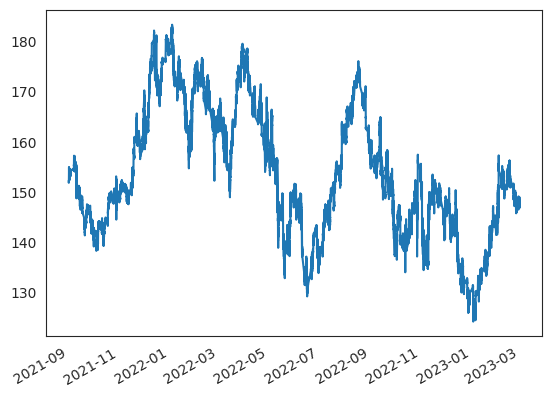

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_vol_spike_tick,
    params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_13388051396.1535_target.csv",
#     top_n=25,
#     spread=10.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [5]:
prun_perc       = 80
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.01, 0.1)      # median ~0.12
    max_down_prop   = trial.suggest_float("max_down_prop", 0.01, 0.1)     # median ~0.12
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.01, 0.07)   # median ~0.033
    tau_time        = trial.suggest_float("tau_time", 15.0, 25.0)          # median ~25.4 (narrow)
    tau_dur         = trial.suggest_float("tau_dur", 15.0, 40.0)          # median ~45, allow wider spread
    
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                           ["median_nonzero"])
    thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
                       if "roll" in thresh_mode else None)
    
    # --- Trading params (tighter) ---
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 1, 20)            # median ~9
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 55), 115)          # median ~89
    
    vol_thresh     = trial.suggest_float("vol_thresh", 0.01, 0.35)         # median ~0.35
    adx_thresh     = trial.suggest_float("adx_thresh", 3, 13)          # median ~10.5
    atr_mult       = trial.suggest_float("atr_mult", 0.1, 2)             # median ~1.4–1.6
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -7, 1)       # many good trials negative; allow some positive
    buy_factor     = trial.suggest_float("buy_factor", 0.05, 0.45)         # median ~0.45
    sell_factor    = trial.suggest_float("sell_factor", 0.01, 0.35)        # median ~0.05–0.10
    trailstop_pct  = trial.suggest_float("trailstop_pct", 1.0, 20.0)        # median ~3.0

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_vol_spike   = params.col_vol_spike_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            vol_thresh      = vol_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
            # sess_start      = params.sess_premark,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



Baseline mean daily B&H: -9.5162


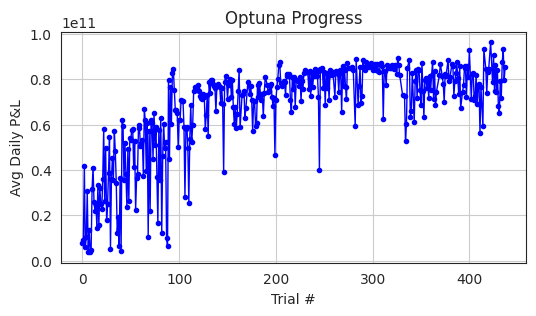

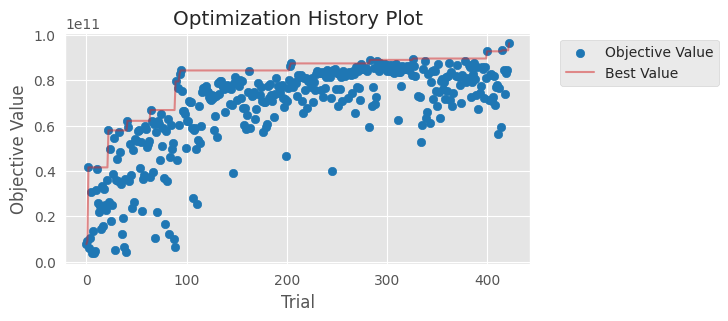

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01676018778978248; max_down_prop=0.07108568062298469; gain_tightfact=0.022115038812066713; tau_time=21.188879462118663; tau_dur=38.72478310695605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=81; vol_thresh=0.3242165319068316; adx_thresh=11.706840197313944; atr_mult=0.9645932776034681; vwap_atr_mult=-0.37674365856762737; buy_factor=0.2191086440760992; sell_factor=0.10777699660869615; trailstop_pct=18.82375626170731


Trial 0: 100%|██████████| 375/375 [00:59<00:00,  6.34it/s]


[Results] mean_pnl:7735995891.3526 mean_bh:-8.7491 mean_excess:7735995900.1017 improv_vs_bh:88420570718.00%
Action counts: {'Buy': 34884, 'Sell': 57300, 'Hold': 258527}
Best trial is: 0 with best_val: 7735995900.1017
[save_results] wrote optuna_results/AAPL_7735995900.1017_target.csv
[save_best_json] wrote optuna_results/AAPL_7735995900.1017_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.06781896459829262; max_down_prop=0.07456999575193066; gain_tightfact=0.06431098488919844; tau_time=19.94501490015191; tau_dur=21.07320262018609; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=90; vol_thresh=0.1796282224650452; adx_thresh=4.753358145742483; atr_mult=0.7091295346949317; vwap_atr_mult=-3.4386863744389453; buy_factor=0.08160105314554561; sell_factor=0.2210858540867646; trailstop_pct=7.875111363965671


Trial 1: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:9210293199.4456 mean_bh:-8.7491 mean_excess:9210293208.1947 improv_vs_bh:105271434016.40%
Action counts: {'Buy': 36748, 'Sell': 50538, 'Hold': 263425}
Best trial is: 1 with best_val: 9210293208.1947
[save_results] wrote optuna_results/AAPL_9210293208.1947_target.csv
[save_best_json] wrote optuna_results/AAPL_9210293208.1947_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.07896778470760146; max_down_prop=0.08903235971089148; gain_tightfact=0.028613375242515567; tau_time=15.083963092549531; tau_dur=18.45177563818189; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=64; vol_thresh=0.2267383311502383; adx_thresh=4.037135349857195; atr_mult=0.1409877816532681; vwap_atr_mult=-2.710957876374425; buy_factor=0.10299891522784846; sell_factor=0.2791540410535878; trailstop_pct=14.231689656467042


Trial 2: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:41601276232.2996 mean_bh:-8.7491 mean_excess:41601276241.0486 improv_vs_bh:475492572040.04%
Action counts: {'Buy': 35706, 'Sell': 49012, 'Hold': 265993}
Best trial is: 2 with best_val: 41601276241.0486
[save_results] wrote optuna_results/AAPL_41601276241.0486_target.csv
[save_best_json] wrote optuna_results/AAPL_41601276241.0486_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0568093667874124; max_down_prop=0.09002028056416128; gain_tightfact=0.04704364657875086; tau_time=21.857669195188958; tau_dur=18.378032259591457; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=99; vol_thresh=0.13907795017090965; adx_thresh=8.231309542870893; atr_mult=1.6097525890276925; vwap_atr_mult=-1.3801487410070692; buy_factor=0.38957857527140555; sell_factor=0.17261380244264246; trailstop_pct=19.117928789006864


Trial 3: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:5835882162.5309 mean_bh:-8.7491 mean_excess:5835882171.2800 improv_vs_bh:66702728244.82%
Action counts: {'Buy': 36811, 'Sell': 52137, 'Hold': 261763}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.07554354249502719; max_down_prop=0.05360749761893061; gain_tightfact=0.06489459259196416; tau_time=21.082092930111067; tau_dur=34.97646693808305; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=90; vol_thresh=0.1489585867973557; adx_thresh=4.534399273879476; atr_mult=1.167368110440646; vwap_atr_mult=-2.5739597388983046; buy_factor=0.21818780633956708; sell_factor=0.014615978891876685; trailstop_pct=16.080644781596398


Trial 4: 100%|██████████| 375/375 [00:43<00:00,  8.56it/s]


[Results] mean_pnl:10382053603.7208 mean_bh:-8.7491 mean_excess:10382053612.4699 improv_vs_bh:118664373339.10%
Action counts: {'Buy': 36646, 'Sell': 52605, 'Hold': 261460}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.09195099495789831; max_down_prop=0.057203805818671974; gain_tightfact=0.053110301427765974; tau_time=15.353997161070554; tau_dur=30.80284316700881; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=60; vol_thresh=0.020554493064587197; adx_thresh=6.415476458398893; atr_mult=0.9976511583631544; vwap_atr_mult=-1.1050156107800877; buy_factor=0.4379038784051169; sell_factor=0.030002045108121538; trailstop_pct=15.94229525208968


Trial 5: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:30655755032.4523 mean_bh:-8.7491 mean_excess:30655755041.2014 improv_vs_bh:350387899830.52%
Action counts: {'Buy': 33825, 'Sell': 46290, 'Hold': 270596}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0820216440186256; max_down_prop=0.09723734584408109; gain_tightfact=0.035995650458423366; tau_time=19.988084513283354; tau_dur=33.12499128912316; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=63; vol_thresh=0.26601674980241097; adx_thresh=8.20444887435387; atr_mult=0.6049857758500126; vwap_atr_mult=-1.117183218368556; buy_factor=0.3963044284432601; sell_factor=0.24521218240007503; trailstop_pct=10.11758485771413


Trial 6: 100%|██████████| 375/375 [00:55<00:00,  6.71it/s]


[Results] mean_pnl:3979263122.9641 mean_bh:-8.7491 mean_excess:3979263131.7132 improv_vs_bh:45482019598.61%
Action counts: {'Buy': 31635, 'Sell': 44642, 'Hold': 274434}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.07449157036552262; max_down_prop=0.0774796009543112; gain_tightfact=0.033142906382716816; tau_time=18.11372856990281; tau_dur=17.188833675479817; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=71; vol_thresh=0.06568737659162319; adx_thresh=9.644821564023442; atr_mult=1.1455175793896883; vwap_atr_mult=0.356695512080222; buy_factor=0.05103051893725344; sell_factor=0.19052485099066427; trailstop_pct=4.011788966136823


Trial 7: 100%|██████████| 375/375 [00:48<00:00,  7.70it/s]


[Results] mean_pnl:13708665633.7855 mean_bh:-8.7491 mean_excess:13708665642.5346 improv_vs_bh:156686747969.86%
Action counts: {'Buy': 36211, 'Sell': 48279, 'Hold': 266221}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04880648886022122; max_down_prop=0.011737073002513632; gain_tightfact=0.0368418691242538; tau_time=24.605495307486038; tau_dur=27.287156854187856; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=109; vol_thresh=0.15825224088618178; adx_thresh=7.290792457865606; atr_mult=0.8952371789716136; vwap_atr_mult=-4.590726039045427; buy_factor=0.37272912592268387; sell_factor=0.21884767899095037; trailstop_pct=10.39271397184875


Trial 8: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:3728410781.2262 mean_bh:-8.7491 mean_excess:3728410789.9753 improv_vs_bh:42614837724.57%
Action counts: {'Buy': 37422, 'Sell': 55504, 'Hold': 257785}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.06575741419804552; max_down_prop=0.0346125425315732; gain_tightfact=0.024293924023439363; tau_time=22.774212134030265; tau_dur=38.03451457978582; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=87; vol_thresh=0.2530553718785756; adx_thresh=4.284711558963493; atr_mult=1.7508766861238472; vwap_atr_mult=-0.66232224849725; buy_factor=0.10236420151319342; sell_factor=0.016803791233810067; trailstop_pct=16.696678560811655


Trial 9: 100%|██████████| 375/375 [00:48<00:00,  7.69it/s]


[Results] mean_pnl:4542827664.5981 mean_bh:-8.7491 mean_excess:4542827673.3472 improv_vs_bh:51923426632.84%
Action counts: {'Buy': 34690, 'Sell': 50307, 'Hold': 265714}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0342258390433576; max_down_prop=0.04433255416818038; gain_tightfact=0.011917737948452824; tau_time=15.93186957796966; tau_dur=24.200401070320112; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=55; vol_thresh=0.25319284330016933; adx_thresh=12.514829596405292; atr_mult=0.11858793355477507; vwap_atr_mult=-6.4279032373611775; buy_factor=0.16142401321465216; sell_factor=0.3494053917576463; trailstop_pct=1.794190081551207


Trial 10: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:31733874872.6673 mean_bh:-8.7491 mean_excess:31733874881.4164 improv_vs_bh:362710550049.73%
Action counts: {'Buy': 36180, 'Sell': 56979, 'Hold': 257552}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.034317457106269336; max_down_prop=0.03713622171086725; gain_tightfact=0.010926812768504414; tau_time=15.189375064073314; tau_dur=25.521934766952914; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=55; vol_thresh=0.24969303413342675; adx_thresh=12.888582494344236; atr_mult=0.17648120573925147; vwap_atr_mult=-6.623241545101045; buy_factor=0.15101330630718993; sell_factor=0.3339816424236169; trailstop_pct=2.2428326714589084


Trial 11: 100%|██████████| 375/375 [00:44<00:00,  8.44it/s]


[Results] mean_pnl:41066315427.6023 mean_bh:-8.7491 mean_excess:41066315436.3514 improv_vs_bh:469378098832.73%
Action counts: {'Buy': 36189, 'Sell': 57506, 'Hold': 257016}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03257750073549563; max_down_prop=0.027519790182009174; gain_tightfact=0.01193571206920509; tau_time=17.40942174469029; tau_dur=15.199298438939493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=72; vol_thresh=0.3488877109357067; adx_thresh=10.335407623272992; atr_mult=0.14804937911774993; vwap_atr_mult=-6.948207119890218; buy_factor=0.14049930691968854; sell_factor=0.34552479062618763; trailstop_pct=6.6616983269155


Trial 12: 100%|██████████| 375/375 [00:53<00:00,  7.05it/s]


[Results] mean_pnl:25783906240.8569 mean_bh:-8.7491 mean_excess:25783906249.6059 improv_vs_bh:294703841027.05%
Action counts: {'Buy': 37016, 'Sell': 57669, 'Hold': 256026}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010244000693555348; max_down_prop=0.025251704574372272; gain_tightfact=0.02183325693048867; tau_time=17.031479821600016; tau_dur=23.35089550104546; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=69; vol_thresh=0.21760614063175387; adx_thresh=3.4401510101285; atr_mult=0.43952111764436286; vwap_atr_mult=-4.79089874157376; buy_factor=0.27385692808779344; sell_factor=0.28886139449893056; trailstop_pct=13.217023230943491


Trial 13: 100%|██████████| 375/375 [01:19<00:00,  4.74it/s]


[Results] mean_pnl:22005191889.0595 mean_bh:-8.7491 mean_excess:22005191897.8086 improv_vs_bh:251514045701.31%
Action counts: {'Buy': 38774, 'Sell': 59578, 'Hold': 252359}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.09955666864211808; max_down_prop=0.05928486386145966; gain_tightfact=0.02605592171852851; tau_time=15.260838892369517; tau_dur=28.239444409542863; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=55; vol_thresh=0.2953447117233515; adx_thresh=6.328826944245433; atr_mult=0.377422954142245; vwap_atr_mult=-2.9135032435257155; buy_factor=0.16166040551003388; sell_factor=0.2899045595255003; trailstop_pct=13.807382634211793


Trial 14: 100%|██████████| 375/375 [00:28<00:00, 13.12it/s]


[Results] mean_pnl:24778809619.9980 mean_bh:-8.7491 mean_excess:24778809628.7471 improv_vs_bh:283215828624.94%
Action counts: {'Buy': 31375, 'Sell': 41927, 'Hold': 277409}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03792970806418601; max_down_prop=0.03710965370958058; gain_tightfact=0.010244616005518258; tau_time=18.32649262726935; tau_dur=21.192124132911708; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=80; vol_thresh=0.2178769221996503; adx_thresh=9.986548914669893; atr_mult=0.3582314649261983; vwap_atr_mult=-5.439983531909829; buy_factor=0.2856500715505097; sell_factor=0.2969159975075511; trailstop_pct=1.9534706311340297


Trial 15: 100%|██████████| 375/375 [00:47<00:00,  7.85it/s]


[Results] mean_pnl:14269991511.6472 mean_bh:-8.7491 mean_excess:14269991520.3963 improv_vs_bh:163102567616.13%
Action counts: {'Buy': 37769, 'Sell': 57213, 'Hold': 255729}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04721676032057248; max_down_prop=0.011483738331734272; gain_tightfact=0.017541443917048913; tau_time=16.131825365119383; tau_dur=26.144085686145846; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=64; vol_thresh=0.1016765154561114; adx_thresh=12.945262972561572; atr_mult=1.371599706918383; vwap_atr_mult=-3.8607151343326374; buy_factor=0.12431192512994849; sell_factor=0.31052981071225716; trailstop_pct=12.600559053002456


Trial 16: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:33540972721.9360 mean_bh:-8.7491 mean_excess:33540972730.6851 improv_vs_bh:383365243412.94%
Action counts: {'Buy': 37640, 'Sell': 54242, 'Hold': 258829}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022048185656701733; max_down_prop=0.08565922400179836; gain_tightfact=0.04543285933726601; tau_time=18.95044020243573; tau_dur=20.092608375610595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=76; vol_thresh=0.21251939120862579; adx_thresh=11.294461371841997; atr_mult=0.6145018569168108; vwap_atr_mult=-2.0704651113429335; buy_factor=0.19481265456966976; sell_factor=0.13042288775130081; trailstop_pct=6.109449661089165


Trial 17: 100%|██████████| 375/375 [00:34<00:00, 10.89it/s]


[Results] mean_pnl:15603396250.9674 mean_bh:-8.7491 mean_excess:15603396259.7165 improv_vs_bh:178343062772.96%
Action counts: {'Buy': 37304, 'Sell': 59308, 'Hold': 254099}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.05984136449733195; max_down_prop=0.06346827641032565; gain_tightfact=0.02882591869898013; tau_time=16.72195967360493; tau_dur=15.070698342718684; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=64; vol_thresh=0.29075526596739515; adx_thresh=5.807917365032381; atr_mult=0.24923157151090394; vwap_atr_mult=-5.652266668839567; buy_factor=0.058166805833776564; sell_factor=0.2571043594155256; trailstop_pct=8.119333230912497


Trial 18: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:32075693849.4235 mean_bh:-8.7491 mean_excess:32075693858.1726 improv_vs_bh:366617458662.06%
Action counts: {'Buy': 36657, 'Sell': 53946, 'Hold': 260108}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.08551943019944719; max_down_prop=0.04684628643276739; gain_tightfact=0.01888289317844978; tau_time=15.121816746564413; tau_dur=30.007665845185826; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=97; vol_thresh=0.18823329139410802; adx_thresh=3.2730005944285283; atr_mult=0.7542238856754023; vwap_atr_mult=-3.80294960446825; buy_factor=0.18179481105241654; sell_factor=0.32676472334742335; trailstop_pct=4.121771614957314


Trial 19: 100%|██████████| 375/375 [00:34<00:00, 11.03it/s]


[Results] mean_pnl:24814922537.4128 mean_bh:-8.7491 mean_excess:24814922546.1619 improv_vs_bh:283628590576.90%
Action counts: {'Buy': 34748, 'Sell': 44452, 'Hold': 271511}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04733451951640884; max_down_prop=0.09711913938730231; gain_tightfact=0.04276173628939008; tau_time=16.49521543290058; tau_dur=23.981651475441346; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=59; vol_thresh=0.1110503574247741; adx_thresh=8.840227670402122; atr_mult=0.5038523540519124; vwap_atr_mult=-2.060924148826877; buy_factor=0.31877442412349033; sell_factor=0.2612211552473184; trailstop_pct=11.642594245714397


Trial 20: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:22652754535.8247 mean_bh:-8.7491 mean_excess:22652754544.5738 improv_vs_bh:258915530854.87%
Action counts: {'Buy': 37197, 'Sell': 55395, 'Hold': 258119}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.044587259278666025; max_down_prop=0.01141543467961299; gain_tightfact=0.01662240270381858; tau_time=16.121612975206446; tau_dur=26.303610764163047; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=67; vol_thresh=0.07527345713494256; adx_thresh=12.54302933618514; atr_mult=1.3845571070415317; vwap_atr_mult=-4.463125004393261; buy_factor=0.1193497892704682; sell_factor=0.31367137684590674; trailstop_pct=13.520912068006641


Trial 21: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:36132799007.6492 mean_bh:-8.7491 mean_excess:36132799016.3983 improv_vs_bh:412989193883.45%
Action counts: {'Buy': 38637, 'Sell': 55252, 'Hold': 256822}
Best trial is: 2 with best_val: 41601276241.0486
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025231192380714675; max_down_prop=0.0228293051259462; gain_tightfact=0.01599331009867469; tau_time=15.008564776123599; tau_dur=26.028125787997602; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=69; vol_thresh=0.01292088343397399; adx_thresh=11.727599245714684; atr_mult=1.6451536563651996; vwap_atr_mult=-5.854422484564226; buy_factor=0.12048601974283933; sell_factor=0.3237572111733647; trailstop_pct=14.742473062395895


Trial 22: 100%|██████████| 375/375 [00:36<00:00, 10.14it/s]


[Results] mean_pnl:57915579078.4586 mean_bh:-8.7491 mean_excess:57915579087.2077 improv_vs_bh:661961125947.20%
Action counts: {'Buy': 40583, 'Sell': 58521, 'Hold': 251607}
Best trial is: 22 with best_val: 57915579087.2077
[save_results] wrote optuna_results/AAPL_57915579087.2077_target.csv
[save_best_json] wrote optuna_results/AAPL_57915579087.2077_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024706866970056817; max_down_prop=0.024732492183902065; gain_tightfact=0.029731891196139965; tau_time=17.885308386775918; tau_dur=22.90391768708993; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=74; vol_thresh=0.023227817377005307; adx_thresh=11.460403062098193; atr_mult=1.813830221376307; vwap_atr_mult=-6.087776168361471; buy_factor=0.08993458419746282; sell_factor=0.2670152297984316; trailstop_pct=14.676108976927942


Trial 23: 100%|██████████| 375/375 [00:48<00:00,  7.71it/s]


[Results] mean_pnl:26139350883.4036 mean_bh:-8.7491 mean_excess:26139350892.1527 improv_vs_bh:298766487719.02%
Action counts: {'Buy': 40434, 'Sell': 57606, 'Hold': 252671}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028215124063149622; max_down_prop=0.019413804985594404; gain_tightfact=0.015756300292311655; tau_time=15.279213522459221; tau_dur=30.07804471788912; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=59; vol_thresh=0.23475624248627652; adx_thresh=10.901966346080137; atr_mult=1.939186381822868; vwap_atr_mult=-5.30235220010291; buy_factor=0.1283512115518346; sell_factor=0.33220271103188087; trailstop_pct=17.393496689311043


Trial 24: 100%|██████████| 375/375 [00:34<00:00, 10.82it/s]


[Results] mean_pnl:49925978332.6840 mean_bh:-8.7491 mean_excess:49925978341.4331 improv_vs_bh:570641912897.84%
Action counts: {'Buy': 38336, 'Sell': 56670, 'Hold': 255705}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02324444343603637; max_down_prop=0.02246194155737862; gain_tightfact=0.016258281243135952; tau_time=18.76801183945652; tau_dur=34.196958438339266; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=78; vol_thresh=0.22715172455292598; adx_thresh=10.7206491137598; atr_mult=1.9086949486291769; vwap_atr_mult=-5.500979569172888; buy_factor=0.08488989390460805; sell_factor=0.2928418360867092; trailstop_pct=17.781959879669508


Trial 25: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:18166081875.5415 mean_bh:-8.7491 mean_excess:18166081884.2906 improv_vs_bh:207633942502.18%
Action counts: {'Buy': 38338, 'Sell': 55757, 'Hold': 256616}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011551679701027794; max_down_prop=0.017248654761662208; gain_tightfact=0.029352370956732203; tau_time=17.278039806788346; tau_dur=30.54327376790124; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=67; vol_thresh=0.18822723222305332; adx_thresh=9.173220662233316; atr_mult=1.960456863274437; vwap_atr_mult=-4.680188942917104; buy_factor=0.24290589711500415; sell_factor=0.230731019317077; trailstop_pct=19.892403678945996


Trial 26: 100%|██████████| 375/375 [00:39<00:00,  9.50it/s]


[Results] mean_pnl:25211329602.1780 mean_bh:-8.7491 mean_excess:25211329610.9271 improv_vs_bh:288159427893.24%
Action counts: {'Buy': 39372, 'Sell': 58784, 'Hold': 252555}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026618912534399956; max_down_prop=0.04642735551462698; gain_tightfact=0.022520619435692776; tau_time=15.760031544354254; tau_dur=31.911003545682377; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=60; vol_thresh=0.3046246718245605; adx_thresh=7.661199992142932; atr_mult=1.5678770087558809; vwap_atr_mult=-3.9671196994295554; buy_factor=0.12128477917319075; sell_factor=0.3235053442207996; trailstop_pct=14.90233862050947


Trial 27: 100%|██████████| 375/375 [00:36<00:00, 10.30it/s]


[Results] mean_pnl:38860699828.8179 mean_bh:-8.7491 mean_excess:38860699837.5670 improv_vs_bh:444168443534.63%
Action counts: {'Buy': 37400, 'Sell': 56435, 'Hold': 256876}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018402704141018005; max_down_prop=0.03300726134718362; gain_tightfact=0.01682929329117015; tau_time=15.009517768655572; tau_dur=28.33357899892929; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=60; vol_thresh=0.05067760517188122; adx_thresh=10.92056408456144; atr_mult=1.6265062412671074; vwap_atr_mult=-5.118663871752256; buy_factor=0.19053799720746187; sell_factor=0.2740442026774056; trailstop_pct=17.743939725682942


Trial 28: 100%|██████████| 375/375 [00:43<00:00,  8.61it/s]


[Results] mean_pnl:54386909980.0812 mean_bh:-8.7491 mean_excess:54386909988.8303 improv_vs_bh:621629287670.32%
Action counts: {'Buy': 40185, 'Sell': 59415, 'Hold': 251111}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016619804780124578; max_down_prop=0.031511832862507465; gain_tightfact=0.01991919114898103; tau_time=24.85526434975149; tau_dur=28.006033037823823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=84; vol_thresh=0.05851248304601055; adx_thresh=11.996593497580424; atr_mult=1.6168296414284729; vwap_atr_mult=-5.189343935428279; buy_factor=0.20972575389314302; sell_factor=0.06871974265918405; trailstop_pct=18.311703730604147


Trial 29: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:5117610949.4482 mean_bh:-8.7491 mean_excess:5117610958.1973 improv_vs_bh:58493061201.15%
Action counts: {'Buy': 37990, 'Sell': 58531, 'Hold': 254190}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01655383683443479; max_down_prop=0.019281723317091506; gain_tightfact=0.014293249025300186; tau_time=16.51633725942774; tau_dur=35.98800525641783; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=69; vol_thresh=0.01064180445315198; adx_thresh=10.883812647305307; atr_mult=1.3716791397670756; vwap_atr_mult=-6.131354831639177; buy_factor=0.24371743883307878; sell_factor=0.18212416348414315; trailstop_pct=17.87230982212243


Trial 30: 100%|██████████| 375/375 [00:42<00:00,  8.88it/s]


[Results] mean_pnl:36234908601.2487 mean_bh:-8.7491 mean_excess:36234908609.9978 improv_vs_bh:414156281955.68%
Action counts: {'Buy': 40569, 'Sell': 61493, 'Hold': 248649}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029280687777040633; max_down_prop=0.06707090146433743; gain_tightfact=0.02640281909040122; tau_time=15.059815706927575; tau_dur=28.56000096901393; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=60; vol_thresh=0.04937040512627165; adx_thresh=11.972188338829781; atr_mult=1.7125470484717287; vwap_atr_mult=-5.768693724904647; buy_factor=0.18824356748480364; sell_factor=0.27190247074775253; trailstop_pct=16.756664801514805


Trial 31: 100%|██████████| 375/375 [00:53<00:00,  6.95it/s]


[Results] mean_pnl:45316942231.2642 mean_bh:-8.7491 mean_excess:45316942240.0134 improv_vs_bh:517961739871.63%
Action counts: {'Buy': 38809, 'Sell': 56900, 'Hold': 255002}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029621381159366834; max_down_prop=0.06739683297106125; gain_tightfact=0.02112248572824493; tau_time=15.769854353081673; tau_dur=28.731798293858777; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=60; vol_thresh=0.040335608319541943; adx_thresh=11.905519264084232; atr_mult=1.7427853025869435; vwap_atr_mult=-5.828307270163043; buy_factor=0.17831103267126666; sell_factor=0.31040265803891787; trailstop_pct=16.976280334715252


Trial 32: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:35621194955.2076 mean_bh:-8.7491 mean_excess:35621194963.9567 improv_vs_bh:407141682731.33%
Action counts: {'Buy': 38839, 'Sell': 55921, 'Hold': 255951}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.038669659518028886; max_down_prop=0.030226712347624172; gain_tightfact=0.024948523712357746; tau_time=15.042749661165777; tau_dur=29.501634652572147; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=58; vol_thresh=0.09693376727841405; adx_thresh=11.095968820876259; atr_mult=1.4967026942002226; vwap_atr_mult=-5.1884695291127265; buy_factor=0.1905715572279301; sell_factor=0.24058686679896804; trailstop_pct=15.460981075291272


Trial 33: 100%|██████████| 375/375 [00:43<00:00,  8.65it/s]


[Results] mean_pnl:57147675481.0867 mean_bh:-8.7491 mean_excess:57147675489.8358 improv_vs_bh:653184172699.96%
Action counts: {'Buy': 39440, 'Sell': 58748, 'Hold': 252523}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03977916523361967; max_down_prop=0.031795166519061877; gain_tightfact=0.014725119415822543; tau_time=15.852208036614655; tau_dur=31.55346551557877; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=57; vol_thresh=0.08864770427937205; adx_thresh=10.90600596062305; atr_mult=1.4828309502315558; vwap_atr_mult=-5.128272276860235; buy_factor=0.14013171998981572; sell_factor=0.21515085821870936; trailstop_pct=15.419488458786892


Trial 34: 100%|██████████| 375/375 [00:57<00:00,  6.48it/s]


[Results] mean_pnl:48325455488.9137 mean_bh:-8.7491 mean_excess:48325455497.6628 improv_vs_bh:552348322115.11%
Action counts: {'Buy': 39382, 'Sell': 58417, 'Hold': 252912}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019947844838138315; max_down_prop=0.01723269346197119; gain_tightfact=0.05627321430804044; tau_time=16.341303388884928; tau_dur=32.88871857075345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=64; vol_thresh=0.12604710813915765; adx_thresh=10.136146390497267; atr_mult=1.8813254094521; vwap_atr_mult=-3.411240799088998; buy_factor=0.21764350206078212; sell_factor=0.23631208465360126; trailstop_pct=19.62873197208653


Trial 35: 100%|██████████| 375/375 [01:02<00:00,  6.04it/s]


[Results] mean_pnl:34265587230.8030 mean_bh:-8.7491 mean_excess:34265587239.5521 improv_vs_bh:391647412800.30%
Action counts: {'Buy': 39728, 'Sell': 58892, 'Hold': 252091}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04009838480865733; max_down_prop=0.04241747632292675; gain_tightfact=0.018839677699312152; tau_time=20.650254462750773; tau_dur=29.87660756499368; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=67; vol_thresh=0.03889413369819759; adx_thresh=9.341545105004577; atr_mult=1.9903834699471958; vwap_atr_mult=-4.182976620785684; buy_factor=0.16571833195783967; sell_factor=0.15777347055896668; trailstop_pct=11.632284405421254


Trial 36: 100%|██████████| 375/375 [00:54<00:00,  6.92it/s]


[Results] mean_pnl:12011442678.6232 mean_bh:-8.7491 mean_excess:12011442687.3723 improv_vs_bh:137287898194.21%
Action counts: {'Buy': 39552, 'Sell': 56975, 'Hold': 254184}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015709127725244847; max_down_prop=0.03134883689320551; gain_tightfact=0.0327444705534895; tau_time=19.307161842398767; tau_dur=25.007395652032063; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=62; vol_thresh=0.03129713111100141; adx_thresh=11.253344826220111; atr_mult=1.4871005515421964; vwap_atr_mult=-5.112313766336648; buy_factor=0.07199552544692697; sell_factor=0.24779230299909183; trailstop_pct=18.74475517886924


Trial 37: 100%|██████████| 375/375 [00:53<00:00,  6.99it/s]


[Results] mean_pnl:19117602247.2708 mean_bh:-8.7491 mean_excess:19117602256.0199 improv_vs_bh:218509591275.09%
Action counts: {'Buy': 39713, 'Sell': 58190, 'Hold': 252808}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.05185935541043924; max_down_prop=0.05259570828438608; gain_tightfact=0.013982748920550847; tau_time=22.411334254306645; tau_dur=26.956489167314675; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=58; vol_thresh=0.08232808651769272; adx_thresh=10.396311384925891; atr_mult=1.1467682229249787; vwap_atr_mult=-6.9231648778547195; buy_factor=0.19764093617721812; sell_factor=0.20968945377173814; trailstop_pct=16.0462793668914


Trial 38: 100%|██████████| 375/375 [01:01<00:00,  6.11it/s]


[Results] mean_pnl:6561977173.8518 mean_bh:-8.7491 mean_excess:6561977182.6009 improv_vs_bh:75001819418.81%
Action counts: {'Buy': 37693, 'Sell': 54361, 'Hold': 258657}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02800951771190619; max_down_prop=0.040379353146899596; gain_tightfact=0.024466755529573576; tau_time=15.546880561724121; tau_dur=29.32282008025434; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=110; vol_thresh=0.1743141041201513; adx_thresh=8.705386620056304; atr_mult=1.2602142163795351; vwap_atr_mult=-3.2870553110719714; buy_factor=0.2695584911007444; sell_factor=0.2774646024396539; trailstop_pct=17.599131153317845


Trial 39: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:36681098970.4367 mean_bh:-8.7491 mean_excess:36681098979.1858 improv_vs_bh:419256130456.37%
Action counts: {'Buy': 39585, 'Sell': 58573, 'Hold': 252553}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.041445560305634836; max_down_prop=0.020973958106546082; gain_tightfact=0.06046647026127731; tau_time=23.9307807796698; tau_dur=37.296814356367435; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=96; vol_thresh=0.12986625772574456; adx_thresh=12.26158480532662; atr_mult=1.6518699668447108; vwap_atr_mult=-6.111240887296053; buy_factor=0.316126762311569; sell_factor=0.20162766313982772; trailstop_pct=15.341859005405897


Trial 40: 100%|██████████| 375/375 [01:03<00:00,  5.87it/s]


[Results] mean_pnl:4349004612.2528 mean_bh:-8.7491 mean_excess:4349004621.0019 improv_vs_bh:49708075806.91%
Action counts: {'Buy': 36493, 'Sell': 54413, 'Hold': 259805}
Best trial is: 22 with best_val: 57915579087.2077
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03564669575309491; max_down_prop=0.029561822488283714; gain_tightfact=0.014703664848745086; tau_time=15.00791226618815; tau_dur=31.933719098049266; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=57; vol_thresh=0.0868536298264745; adx_thresh=11.138852305929454; atr_mult=1.4906328637650654; vwap_atr_mult=-4.934130443876233; buy_factor=0.13768841549550373; sell_factor=0.23579209368754178; trailstop_pct=14.424752431185311


Trial 41: 100%|██████████| 375/375 [01:09<00:00,  5.38it/s]


[Results] mean_pnl:62150409750.3921 mean_bh:-8.7491 mean_excess:62150409759.1412 improv_vs_bh:710364221003.33%
Action counts: {'Buy': 39476, 'Sell': 59075, 'Hold': 252160}
Best trial is: 41 with best_val: 62150409759.1412
[save_results] wrote optuna_results/AAPL_62150409759.1412_target.csv
[save_best_json] wrote optuna_results/AAPL_62150409759.1412_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03444288201371448; max_down_prop=0.02894438308107508; gain_tightfact=0.013809216753985231; tau_time=15.046026811183514; tau_dur=32.745074338667; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=114; vol_thresh=0.06066116027743586; adx_thresh=11.621798874236793; atr_mult=1.5315696215945094; vwap_atr_mult=-5.0611127974406225; buy_factor=0.10885767879864101; sell_factor=0.3026500194198432; trailstop_pct=12.275800025875682


Trial 42: 100%|██████████| 375/375 [00:56<00:00,  6.66it/s]


[Results] mean_pnl:59580956779.8214 mean_bh:-8.7491 mean_excess:59580956788.5705 improv_vs_bh:680995992138.58%
Action counts: {'Buy': 40437, 'Sell': 58042, 'Hold': 252232}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.036222145914997624; max_down_prop=0.027747181643266356; gain_tightfact=0.013685146313246743; tau_time=16.80802800201706; tau_dur=32.997512646057835; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=107; vol_thresh=0.06919256738049964; adx_thresh=11.392560897045307; atr_mult=1.504843257405026; vwap_atr_mult=-4.2924168235101385; buy_factor=0.1022809263945858; sell_factor=0.24676773901037002; trailstop_pct=12.170497389489803


Trial 43: 100%|██████████| 375/375 [00:33<00:00, 11.27it/s]


[Results] mean_pnl:35575810539.0276 mean_bh:-8.7491 mean_excess:35575810547.7767 improv_vs_bh:406622949780.57%
Action counts: {'Buy': 40090, 'Sell': 57946, 'Hold': 252675}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.055090031019032815; max_down_prop=0.03525690317544193; gain_tightfact=0.06812561390964261; tau_time=15.618966425428448; tau_dur=39.53703618413348; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=113; vol_thresh=0.1014576042130215; adx_thresh=9.84947854491606; atr_mult=1.271029361893009; vwap_atr_mult=-4.863032914586649; buy_factor=0.14077638974740436; sell_factor=0.15124897109003485; trailstop_pct=9.564213774880042


Trial 44: 100%|██████████| 375/375 [00:46<00:00,  8.12it/s]


[Results] mean_pnl:51844904283.9987 mean_bh:-8.7491 mean_excess:51844904292.7478 improv_vs_bh:592574774545.12%
Action counts: {'Buy': 39334, 'Sell': 56376, 'Hold': 255001}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03245029978392709; max_down_prop=0.04961772250200477; gain_tightfact=0.02297933264871946; tau_time=16.168684632366222; tau_dur=34.15981893426136; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=105; vol_thresh=0.055927497954119526; adx_thresh=11.711710069560764; atr_mult=1.8211784381725653; vwap_atr_mult=-6.565392479513373; buy_factor=0.10660086826016237; sell_factor=0.2298357531345332; trailstop_pct=14.164055809272636


Trial 45: 100%|██████████| 375/375 [00:59<00:00,  6.35it/s]


[Results] mean_pnl:38247467202.8292 mean_bh:-8.7491 mean_excess:38247467211.5783 improv_vs_bh:437159342253.68%
Action counts: {'Buy': 39536, 'Sell': 57188, 'Hold': 253987}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.06053297387450055; max_down_prop=0.030443073945171123; gain_tightfact=0.010535513393096064; tau_time=17.557116225836484; tau_dur=31.339223688271083; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=92; vol_thresh=0.09088506606769284; adx_thresh=10.608080853673325; atr_mult=1.6868132331647956; vwap_atr_mult=-4.902251610884391; buy_factor=0.16775790855136394; sell_factor=0.30002887833497877; trailstop_pct=12.835062829708553


Trial 46: 100%|██████████| 375/375 [00:36<00:00, 10.37it/s]


[Results] mean_pnl:23644703723.9691 mean_bh:-8.7491 mean_excess:23644703732.7182 improv_vs_bh:270253271266.27%
Action counts: {'Buy': 38792, 'Sell': 51937, 'Hold': 259982}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020983147576944777; max_down_prop=0.040749123211713534; gain_tightfact=0.03782210085709294; tau_time=15.555363565046187; tau_dur=32.2958235365338; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=83; vol_thresh=0.01947940497148805; adx_thresh=12.345018323015617; atr_mult=1.0417706840407808; vwap_atr_mult=0.33878484589839086; buy_factor=0.14739384761983246; sell_factor=0.19427214530816017; trailstop_pct=11.001275721798866


Trial 47: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:49223705709.4565 mean_bh:-8.7491 mean_excess:49223705718.2056 improv_vs_bh:562615105884.59%
Action counts: {'Buy': 39608, 'Sell': 60663, 'Hold': 250440}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.043603796593343166; max_down_prop=0.01485048297414983; gain_tightfact=0.019730667713127762; tau_time=17.072129957521454; tau_dur=35.12817653114947; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=101; vol_thresh=0.04675394759640265; adx_thresh=9.721940402671134; atr_mult=1.56880327558773; vwap_atr_mult=-5.9655930400963255; buy_factor=0.23305834316736085; sell_factor=0.2787431649451418; trailstop_pct=9.296740759874057


Trial 48: 100%|██████████| 375/375 [00:36<00:00, 10.18it/s]


[Results] mean_pnl:26452050426.2106 mean_bh:-8.7491 mean_excess:26452050434.9597 improv_vs_bh:302340568211.73%
Action counts: {'Buy': 40307, 'Sell': 56581, 'Hold': 253823}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03439178838258313; max_down_prop=0.026402099796189026; gain_tightfact=0.03332418173549703; tau_time=15.04153207443809; tau_dur=27.23199353916331; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=89; vol_thresh=0.06419778778071437; adx_thresh=12.767308023882777; atr_mult=0.8978622130191333; vwap_atr_mult=-4.521290684154853; buy_factor=0.10531219144048656; sell_factor=0.3421953057827896; trailstop_pct=16.17228341850294


Trial 49: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:54202565766.8477 mean_bh:-8.7491 mean_excess:54202565775.5968 improv_vs_bh:619522277693.43%
Action counts: {'Buy': 39522, 'Sell': 57918, 'Hold': 253271}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012733660085093641; max_down_prop=0.03893396591864505; gain_tightfact=0.012976322633995327; tau_time=15.47177988442467; tau_dur=37.081758205439925; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=56; vol_thresh=0.11366814954737514; adx_thresh=11.601290614611587; atr_mult=1.2581180367780511; vwap_atr_mult=-6.277504166320871; buy_factor=0.06644676395747096; sell_factor=0.2536900112358193; trailstop_pct=14.108286114618004


Trial 50: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:53292141199.1923 mean_bh:-8.7491 mean_excess:53292141207.9413 improv_vs_bh:609116344067.39%
Action counts: {'Buy': 38927, 'Sell': 59213, 'Hold': 252571}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03255195176130016; max_down_prop=0.02540156427379271; gain_tightfact=0.0341299131158769; tau_time=15.009904494945038; tau_dur=26.61871409405026; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=88; vol_thresh=0.06712071972357221; adx_thresh=12.604731955994087; atr_mult=0.9033728815808272; vwap_atr_mult=-4.466580502223619; buy_factor=0.09950727552148002; sell_factor=0.34471098190381366; trailstop_pct=15.853146084061512


Trial 51: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:57801653423.5986 mean_bh:-8.7491 mean_excess:57801653432.3477 improv_vs_bh:660658983139.44%
Action counts: {'Buy': 39693, 'Sell': 58135, 'Hold': 252883}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03164358990233115; max_down_prop=0.034208921930019474; gain_tightfact=0.026015572385601454; tau_time=15.073010645933287; tau_dur=22.297011614565086; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=93; vol_thresh=0.14687927695735353; adx_thresh=12.236435159956505; atr_mult=1.4342545274239298; vwap_atr_mult=-5.521337785631387; buy_factor=0.08537526648036023; sell_factor=0.31778219319626544; trailstop_pct=15.348171641068866


Trial 52: 100%|██████████| 375/375 [00:45<00:00,  8.22it/s]


[Results] mean_pnl:58291186493.2672 mean_bh:-8.7491 mean_excess:58291186502.0163 improv_vs_bh:666254228271.99%
Action counts: {'Buy': 39325, 'Sell': 57438, 'Hold': 253948}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03235045229173351; max_down_prop=0.0234882602242945; gain_tightfact=0.03950549305774498; tau_time=15.957250704825137; tau_dur=22.266036481047365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=93; vol_thresh=0.15169417438391725; adx_thresh=12.99412804201606; atr_mult=1.4202810833240993; vwap_atr_mult=-5.554197847774351; buy_factor=0.08360019436456405; sell_factor=0.31899446099073736; trailstop_pct=15.069843951330556


Trial 53: 100%|██████████| 375/375 [00:36<00:00, 10.40it/s]


[Results] mean_pnl:41355609097.8874 mean_bh:-8.7491 mean_excess:41355609106.6365 improv_vs_bh:472684655837.41%
Action counts: {'Buy': 38524, 'Sell': 56700, 'Hold': 255487}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03697636461475171; max_down_prop=0.028224010598615408; gain_tightfact=0.02611947674182834; tau_time=15.475241010908725; tau_dur=20.015249139914353; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=87; vol_thresh=0.1403731814782249; adx_thresh=12.377348514342154; atr_mult=0.7932625439498677; vwap_atr_mult=-4.080844449216067; buy_factor=0.0946321696422062; sell_factor=0.30305379390679904; trailstop_pct=13.512913761922775


Trial 54: 100%|██████████| 375/375 [00:40<00:00,  9.22it/s]


[Results] mean_pnl:52665910721.7868 mean_bh:-8.7491 mean_excess:52665910730.5359 improv_vs_bh:601958680473.95%
Action counts: {'Buy': 39327, 'Sell': 58502, 'Hold': 252882}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.049911896207761014; max_down_prop=0.03642993117841449; gain_tightfact=0.03276550484420147; tau_time=16.381495831982352; tau_dur=25.105985181764495; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=115; vol_thresh=0.16364836237989516; adx_thresh=12.058561159632394; atr_mult=1.2934010969906713; vwap_atr_mult=-4.80896654024487; buy_factor=0.11702551359951484; sell_factor=0.34188538007204733; trailstop_pct=15.668898812392392


Trial 55: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:22310142816.5862 mean_bh:-8.7491 mean_excess:22310142825.3353 improv_vs_bh:254999561386.82%
Action counts: {'Buy': 36828, 'Sell': 51304, 'Hold': 262579}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04361455070948094; max_down_prop=0.013613243987515282; gain_tightfact=0.024345825470603932; tau_time=16.791595532686024; tau_dur=17.628576459791418; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.10001229375086562; adx_thresh=12.553443999281653; atr_mult=1.1122497851101587; vwap_atr_mult=-3.5699187277960096; buy_factor=0.05378300038562215; sell_factor=0.32767349114818384; trailstop_pct=14.6366539807145


Trial 56: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:36673004780.2479 mean_bh:-8.7491 mean_excess:36673004788.9970 improv_vs_bh:419163615811.16%
Action counts: {'Buy': 39206, 'Sell': 55923, 'Hold': 255582}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02457635625738012; max_down_prop=0.02348004816253593; gain_tightfact=0.03586308395284311; tau_time=15.987320619785836; tau_dur=21.592515409129653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=14; rsi_max_thresh=81; vol_thresh=0.11991231941687154; adx_thresh=11.201933313686654; atr_mult=1.5410817494332032; vwap_atr_mult=-5.62980545636439; buy_factor=0.0722123761615504; sell_factor=0.34648790387249423; trailstop_pct=12.75433559600646


Trial 57: 100%|██████████| 375/375 [00:41<00:00,  9.00it/s]


[Results] mean_pnl:38435152617.0350 mean_bh:-8.7491 mean_excess:38435152625.7841 improv_vs_bh:439304541353.30%
Action counts: {'Buy': 39584, 'Sell': 56295, 'Hold': 254832}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031676516738980545; max_down_prop=0.02860127991583967; gain_tightfact=0.030808777379454828; tau_time=15.005953027224683; tau_dur=24.219318306693168; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.07512479909433536; adx_thresh=11.69231272164555; atr_mult=1.451988404950728; vwap_atr_mult=-2.4948184000578184; buy_factor=0.15385132775790294; sell_factor=0.2911448759180643; trailstop_pct=16.44566227771901


Trial 58: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:59835566877.0670 mean_bh:-8.7491 mean_excess:59835566885.8161 improv_vs_bh:683906124253.40%
Action counts: {'Buy': 40170, 'Sell': 58781, 'Hold': 251760}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03040183346646255; max_down_prop=0.03432063320859426; gain_tightfact=0.04384928003314153; tau_time=15.430237222383651; tau_dur=23.850525168118644; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; vol_thresh=0.029709295970117275; adx_thresh=5.449445017139782; atr_mult=1.4249991160255187; vwap_atr_mult=-2.3533299542599098; buy_factor=0.131043390179226; sell_factor=0.2857922139621745; trailstop_pct=16.516476096181144


Trial 59: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:58365307906.9034 mean_bh:-8.7491 mean_excess:58365307915.6525 improv_vs_bh:667101418185.32%
Action counts: {'Buy': 41855, 'Sell': 59686, 'Hold': 249170}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.07019011143362075; max_down_prop=0.043783006674242564; gain_tightfact=0.04689583620175081; tau_time=15.444684461947318; tau_dur=19.929584719315464; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.029392427968172756; adx_thresh=7.055078283441794; atr_mult=1.4272910915066206; vwap_atr_mult=-1.9497481885600518; buy_factor=0.13175581718695148; sell_factor=0.2902680829910269; trailstop_pct=16.387420682989426


Trial 60: 100%|██████████| 375/375 [00:39<00:00,  9.51it/s]


[Results] mean_pnl:50496589272.3169 mean_bh:-8.7491 mean_excess:50496589281.0660 improv_vs_bh:577163858564.80%
Action counts: {'Buy': 39030, 'Sell': 50569, 'Hold': 261112}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031274029366040595; max_down_prop=0.027446402324360124; gain_tightfact=0.04066437706360397; tau_time=15.41402641818114; tau_dur=24.03085046389162; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; vol_thresh=0.07837386374377164; adx_thresh=11.62169470010976; atr_mult=1.1873784203997353; vwap_atr_mult=-1.5541852502534996; buy_factor=0.15434736542556365; sell_factor=0.3059632441638351; trailstop_pct=14.353044817663442


Trial 61: 100%|██████████| 375/375 [00:39<00:00,  9.53it/s]


[Results] mean_pnl:51898734118.8312 mean_bh:-8.7491 mean_excess:51898734127.5803 improv_vs_bh:593190036597.87%
Action counts: {'Buy': 40294, 'Sell': 58823, 'Hold': 251594}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025708009903759776; max_down_prop=0.034324431710265835; gain_tightfact=0.051342644012186314; tau_time=15.787746858600812; tau_dur=23.163404517409433; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=71; vol_thresh=0.010212770265557343; adx_thresh=5.3090369338906225; atr_mult=0.9484315605734563; vwap_atr_mult=-2.8909258887269718; buy_factor=0.11198595914889578; sell_factor=0.31853255637994315; trailstop_pct=16.99032053044934


Trial 62: 100%|██████████| 375/375 [00:42<00:00,  8.85it/s]


[Results] mean_pnl:53164298973.6926 mean_bh:-8.7491 mean_excess:53164298982.4417 improv_vs_bh:607655138207.60%
Action counts: {'Buy': 42021, 'Sell': 60487, 'Hold': 248203}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.034334919488938895; max_down_prop=0.020899788937033082; gain_tightfact=0.0430168184137629; tau_time=16.172629575101922; tau_dur=26.285860281111713; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=80; vol_thresh=0.06687446976126232; adx_thresh=3.7455654034492194; atr_mult=1.3169322794213185; vwap_atr_mult=-2.4157325990885696; buy_factor=0.09372708049184114; sell_factor=0.33375972073345095; trailstop_pct=13.315621560023985


Trial 63: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:37283956996.2793 mean_bh:-8.7491 mean_excess:37283957005.0284 improv_vs_bh:426146652555.30%
Action counts: {'Buy': 40991, 'Sell': 57080, 'Hold': 252640}
Best trial is: 41 with best_val: 62150409759.1412
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03578105467892018; max_down_prop=0.01669489572893385; gain_tightfact=0.031105589739835855; tau_time=15.012790455578113; tau_dur=25.562399202554978; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=75; vol_thresh=0.035835319422080875; adx_thresh=6.685321957300461; atr_mult=1.799081030105866; vwap_atr_mult=-2.3875073934511652; buy_factor=0.12991942910012738; sell_factor=0.2851617475022586; trailstop_pct=16.15517827461156


Trial 64: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:66906072840.5981 mean_bh:-8.7491 mean_excess:66906072849.3472 improv_vs_bh:764720305211.31%
Action counts: {'Buy': 41934, 'Sell': 59034, 'Hold': 249743}
Best trial is: 64 with best_val: 66906072849.3472
[save_results] wrote optuna_results/AAPL_66906072849.3472_target.csv
[save_best_json] wrote optuna_results/AAPL_66906072849.3472_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022082482866883798; max_down_prop=0.01760491297560514; gain_tightfact=0.030328150430974542; tau_time=15.314293576802966; tau_dur=25.591824813866374; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.0362345236793495; adx_thresh=5.08780776762096; atr_mult=1.8047627387551282; vwap_atr_mult=-2.5223324729779937; buy_factor=0.13423609821636945; sell_factor=0.2629970233565184; trailstop_pct=16.667750175385724


Trial 65: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:61891738393.9281 mean_bh:-8.7491 mean_excess:61891738402.6772 improv_vs_bh:707407669673.37%
Action counts: {'Buy': 42047, 'Sell': 60356, 'Hold': 248308}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022282539240111924; max_down_prop=0.016199620918985226; gain_tightfact=0.030017783873557143; tau_time=16.56006324115561; tau_dur=24.515378267581397; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=74; vol_thresh=0.035579590553183216; adx_thresh=5.073402998701428; atr_mult=1.8023881561931447; vwap_atr_mult=-2.337380832438434; buy_factor=0.15495443240438725; sell_factor=0.263734986269368; trailstop_pct=18.811656079036865


Trial 66: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:39765269930.1035 mean_bh:-8.7491 mean_excess:39765269938.8526 improv_vs_bh:454507462019.51%
Action counts: {'Buy': 41858, 'Sell': 59752, 'Hold': 249101}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028461046829523832; max_down_prop=0.01054525689903927; gain_tightfact=0.030190526823810775; tau_time=15.319763890398416; tau_dur=25.54823179532833; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=78; vol_thresh=0.024244434847735828; adx_thresh=6.537861952516279; atr_mult=1.7882649615538102; vwap_atr_mult=-1.6835096332169615; buy_factor=0.13655853090460338; sell_factor=0.28716567654195013; trailstop_pct=18.298871381863034


Trial 67: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:60690624688.7481 mean_bh:-8.7491 mean_excess:60690624697.4972 improv_vs_bh:693679229188.05%
Action counts: {'Buy': 42147, 'Sell': 59582, 'Hold': 248982}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03668866768954658; max_down_prop=0.01100391287901541; gain_tightfact=0.05064973361520132; tau_time=21.17660523262358; tau_dur=25.56865838443563; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=76; vol_thresh=0.02271857288035321; adx_thresh=6.140019922231946; atr_mult=1.8576017721785303; vwap_atr_mult=-1.5932616967000983; buy_factor=0.13182436026231273; sell_factor=0.29190562086982297; trailstop_pct=18.1432131299139


Trial 68: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:10402620816.1483 mean_bh:-8.7491 mean_excess:10402620824.8974 improv_vs_bh:118899451625.65%
Action counts: {'Buy': 40758, 'Sell': 55991, 'Hold': 253962}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027785852682136045; max_down_prop=0.010023549929555679; gain_tightfact=0.030540913466486675; tau_time=15.357431976544051; tau_dur=23.6512915209308; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=72; vol_thresh=0.044552412410613695; adx_thresh=6.853174491784873; atr_mult=1.7534266636907896; vwap_atr_mult=-1.1610706141546354; buy_factor=0.1708066785142073; sell_factor=0.2843533457945911; trailstop_pct=19.286527745039493


Trial 69: 100%|██████████| 375/375 [00:41<00:00,  9.01it/s]


[Results] mean_pnl:57236326624.9152 mean_bh:-8.7491 mean_excess:57236326633.6643 improv_vs_bh:654197433931.39%
Action counts: {'Buy': 41813, 'Sell': 59771, 'Hold': 249127}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019858283536572548; max_down_prop=0.013427847059978095; gain_tightfact=0.043146180869730606; tau_time=15.826554332138745; tau_dur=27.517988727151803; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=16; rsi_max_thresh=78; vol_thresh=0.029009175253895684; adx_thresh=5.522467051105181; atr_mult=1.770014553130784; vwap_atr_mult=-0.5971701243246077; buy_factor=0.4251598416776996; sell_factor=0.26605356171945294; trailstop_pct=17.226000455761195


Trial 70: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:21826833120.1296 mean_bh:-8.7491 mean_excess:21826833128.8787 improv_vs_bh:249475447911.83%
Action counts: {'Buy': 39683, 'Sell': 57524, 'Hold': 253504}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031000007817524943; max_down_prop=0.018182303446878705; gain_tightfact=0.031528897806792106; tau_time=15.26727315006365; tau_dur=22.174437248462265; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; vol_thresh=0.05646408482093498; adx_thresh=4.223841159451103; atr_mult=1.6688607388904508; vwap_atr_mult=-2.7824084688889315; buy_factor=0.13922904240239928; sell_factor=0.2820902397994819; trailstop_pct=16.28749535946666


Trial 71: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:61910447090.0663 mean_bh:-8.7491 mean_excess:61910447098.8154 improv_vs_bh:707621505566.17%
Action counts: {'Buy': 42173, 'Sell': 59685, 'Hold': 248853}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04137501259582616; max_down_prop=0.018672011767897623; gain_tightfact=0.027755224169511223; tau_time=15.348591269681732; tau_dur=24.68456696719558; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=85; vol_thresh=0.053177709611479836; adx_thresh=4.497985897498025; atr_mult=1.6885892563690166; vwap_atr_mult=-2.667661751489927; buy_factor=0.1296476785478026; sell_factor=0.25471942074722986; trailstop_pct=16.366551747949853


Trial 72: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:60682319258.1613 mean_bh:-8.7491 mean_excess:60682319266.9104 improv_vs_bh:693584300115.96%
Action counts: {'Buy': 41678, 'Sell': 58466, 'Hold': 250567}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04605151655001664; max_down_prop=0.01849600564882045; gain_tightfact=0.0276282463232403; tau_time=16.13626962001679; tau_dur=24.84589512947246; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; vol_thresh=0.056454509974267306; adx_thresh=4.46773420130637; atr_mult=1.682499835952031; vwap_atr_mult=-3.182081035880712; buy_factor=0.14792288952975136; sell_factor=0.25672837192150394; trailstop_pct=18.209736580658895


Trial 73: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:44947254736.3298 mean_bh:-8.7491 mean_excess:44947254745.0788 improv_vs_bh:513736300805.80%
Action counts: {'Buy': 41344, 'Sell': 57338, 'Hold': 252029}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03473109127215393; max_down_prop=0.014705264307972574; gain_tightfact=0.035176744393031895; tau_time=15.272906164346145; tau_dur=22.53928164773912; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=79; vol_thresh=0.08369767947193016; adx_thresh=4.042839711972832; atr_mult=1.5678730707307134; vwap_atr_mult=-2.6361231638554306; buy_factor=0.11477946176515252; sell_factor=0.22472941509084382; trailstop_pct=16.700867769521647


Trial 74: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:65033657037.4645 mean_bh:-8.7491 mean_excess:65033657046.2136 improv_vs_bh:743319043360.55%
Action counts: {'Buy': 41761, 'Sell': 60284, 'Hold': 248666}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04136861475821414; max_down_prop=0.014946470272180514; gain_tightfact=0.035472457614116895; tau_time=15.72892267447647; tau_dur=22.39792694829763; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=82; vol_thresh=0.0786423123855982; adx_thresh=4.113513815843996; atr_mult=1.5818059139920568; vwap_atr_mult=-2.646473618685652; buy_factor=0.175470508111153; sell_factor=0.22553002144927087; trailstop_pct=16.596750281658434


Trial 75: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:51247005720.2555 mean_bh:-8.7491 mean_excess:51247005729.0046 improv_vs_bh:585740937904.00%
Action counts: {'Buy': 41223, 'Sell': 58921, 'Hold': 250567}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03752328835726692; max_down_prop=0.019615502699201915; gain_tightfact=0.03156143961717892; tau_time=15.323051325919963; tau_dur=25.989127327795387; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=85; vol_thresh=0.04212103148109901; adx_thresh=4.902550805022667; atr_mult=1.8565440832804152; vwap_atr_mult=-1.9089522564236245; buy_factor=0.15918119818770649; sell_factor=0.24050877019596856; trailstop_pct=17.107203497690147


Trial 76: 100%|██████████| 375/375 [00:41<00:00,  9.04it/s]


[Results] mean_pnl:59147767356.3691 mean_bh:-8.7491 mean_excess:59147767365.1182 improv_vs_bh:676044741317.71%
Action counts: {'Buy': 41853, 'Sell': 59214, 'Hold': 249644}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027263872326873967; max_down_prop=0.07926471438606555; gain_tightfact=0.028082283692425353; tau_time=16.267780832900367; tau_dur=20.795700122383746; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=85; vol_thresh=0.05223591869433739; adx_thresh=3.703115888318803; atr_mult=1.9122760624609432; vwap_atr_mult=-2.833034922528187; buy_factor=0.14264941888835425; sell_factor=0.2188882167292398; trailstop_pct=18.5166989273123


Trial 77: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:36711130505.4379 mean_bh:-8.7491 mean_excess:36711130514.1870 improv_vs_bh:419599383671.42%
Action counts: {'Buy': 40737, 'Sell': 57400, 'Hold': 252574}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04189800899883039; max_down_prop=0.013582073035186494; gain_tightfact=0.0377863914054755; tau_time=19.480285724438563; tau_dur=23.102691819741704; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=80; vol_thresh=0.08523284213578936; adx_thresh=3.114947588123747; atr_mult=1.714847461264778; vwap_atr_mult=-3.0801166616563527; buy_factor=0.1298459492093642; sell_factor=0.27205811259036317; trailstop_pct=19.178983326237944


Trial 78: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:16408707967.2223 mean_bh:-8.7491 mean_excess:16408707975.9714 improv_vs_bh:187547581813.13%
Action counts: {'Buy': 40569, 'Sell': 56292, 'Hold': 253850}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023992523043737182; max_down_prop=0.017408022805505092; gain_tightfact=0.03169840606067391; tau_time=15.658627700724596; tau_dur=21.475259767035507; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=79; vol_thresh=0.07272519815130886; adx_thresh=4.612669626633393; atr_mult=1.6344996872938453; vwap_atr_mult=-3.6177034686711136; buy_factor=0.1230036043299956; sell_factor=0.2357255888382384; trailstop_pct=17.567382318345594


Trial 79: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:57653695960.4121 mean_bh:-8.7491 mean_excess:57653695969.1612 improv_vs_bh:658967864955.58%
Action counts: {'Buy': 41916, 'Sell': 60669, 'Hold': 248126}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029702855191774367; max_down_prop=0.021166170643777564; gain_tightfact=0.033915026549819545; tau_time=17.088675281608822; tau_dur=25.482560266501803; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=75; vol_thresh=0.017361940700176035; adx_thresh=7.67744776012381; atr_mult=1.8284505537461544; vwap_atr_mult=-2.2047269362505553; buy_factor=0.11537148235809203; sell_factor=0.2545665342709976; trailstop_pct=16.15807055893088


Trial 80: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:35580161564.7386 mean_bh:-8.7491 mean_excess:35580161573.4877 improv_vs_bh:406672680956.95%
Action counts: {'Buy': 41652, 'Sell': 58914, 'Hold': 250145}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.035421853139359076; max_down_prop=0.012399031698527484; gain_tightfact=0.028150507709526006; tau_time=15.231457611287762; tau_dur=24.447567844238442; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=77; vol_thresh=0.0610195229116778; adx_thresh=6.03399172786532; atr_mult=1.5419511446807657; vwap_atr_mult=-2.56442417449634; buy_factor=0.13646023886591072; sell_factor=0.28218508332267295; trailstop_pct=15.796410694485706


Trial 81: 100%|██████████| 375/375 [00:39<00:00,  9.48it/s]


[Results] mean_pnl:62936163083.4652 mean_bh:-8.7491 mean_excess:62936163092.2142 improv_vs_bh:719345192432.35%
Action counts: {'Buy': 41864, 'Sell': 59508, 'Hold': 249339}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.035951713180944075; max_down_prop=0.016092570137077364; gain_tightfact=0.028269078237952456; tau_time=20.571216778290363; tau_dur=24.548527050912146; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=77; vol_thresh=0.037856433314800625; adx_thresh=5.87815014051091; atr_mult=1.7757609505158456; vwap_atr_mult=-1.729266490588921; buy_factor=0.13786688351165657; sell_factor=0.26600336812800807; trailstop_pct=15.869410152664441


Trial 82: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:12342259571.1637 mean_bh:-8.7491 mean_excess:12342259579.9127 improv_vs_bh:141069055632.67%
Action counts: {'Buy': 40923, 'Sell': 56870, 'Hold': 252918}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03799128597336914; max_down_prop=0.012264504082031266; gain_tightfact=0.03142714936899023; tau_time=15.983006540146668; tau_dur=22.72222293972033; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; vol_thresh=0.11040948811333967; adx_thresh=6.602351049377097; atr_mult=1.6765597368359948; vwap_atr_mult=-2.5218740433992393; buy_factor=0.1550942521577018; sell_factor=0.280930633185462; trailstop_pct=16.729386636046904


Trial 83: 100%|██████████| 375/375 [00:43<00:00,  8.63it/s]


[Results] mean_pnl:46193886794.7294 mean_bh:-8.7491 mean_excess:46193886803.4784 improv_vs_bh:527985005110.00%
Action counts: {'Buy': 41251, 'Sell': 58537, 'Hold': 250923}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04017914350962494; max_down_prop=0.010171621635876833; gain_tightfact=0.035387971448616135; tau_time=15.267469754375867; tau_dur=25.767454461479062; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=70; vol_thresh=0.050760272293929494; adx_thresh=4.207072367758411; atr_mult=1.7130751576942498; vwap_atr_mult=-2.152711888385141; buy_factor=0.16433938822399444; sell_factor=0.2486850304791839; trailstop_pct=17.30269913191824


Trial 84: 100%|██████████| 375/375 [00:42<00:00,  8.89it/s]


[Results] mean_pnl:60454079542.7679 mean_bh:-8.7491 mean_excess:60454079551.5169 improv_vs_bh:690975575117.11%
Action counts: {'Buy': 41427, 'Sell': 58886, 'Hold': 250398}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04655061808031687; max_down_prop=0.011938983317545771; gain_tightfact=0.04030763879983993; tau_time=15.673321270676734; tau_dur=25.791852921579068; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=70; vol_thresh=0.04985932030752288; adx_thresh=4.401234350749145; atr_mult=1.5953843367631997; vwap_atr_mult=-2.6735864166849157; buy_factor=0.18163504756669752; sell_factor=0.24992175812276507; trailstop_pct=17.34399195984357


Trial 85: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:49689003621.2432 mean_bh:-8.7491 mean_excess:49689003629.9923 improv_vs_bh:567933348997.10%
Action counts: {'Buy': 40936, 'Sell': 57552, 'Hold': 252223}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.040769245099543834; max_down_prop=0.014795951151812082; gain_tightfact=0.03506735932531835; tau_time=15.275089380247607; tau_dur=27.48123005181002; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=81; vol_thresh=0.05876654464263367; adx_thresh=3.9046179161051056; atr_mult=1.7281630645174804; vwap_atr_mult=-1.2910736544705248; buy_factor=0.2073327160053049; sell_factor=0.2711273909540097; trailstop_pct=17.845088265480033


Trial 86: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:52323034693.0819 mean_bh:-8.7491 mean_excess:52323034701.8310 improv_vs_bh:598039690012.33%
Action counts: {'Buy': 41317, 'Sell': 58128, 'Hold': 251266}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.049463768747693836; max_down_prop=0.010142442070440518; gain_tightfact=0.03679230562484623; tau_time=21.562316792722253; tau_dur=25.196990862819742; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=78; vol_thresh=0.027020355535725536; adx_thresh=4.178354998542628; atr_mult=1.9299511782199832; vwap_atr_mult=-2.11487217235823; buy_factor=0.1652437731320154; sell_factor=0.20289968133030514; trailstop_pct=19.98455018448974


Trial 87: 100%|██████████| 375/375 [00:33<00:00, 11.34it/s]


[Results] mean_pnl:10049812610.7540 mean_bh:-8.7491 mean_excess:10049812619.5031 improv_vs_bh:114866938775.62%
Action counts: {'Buy': 40210, 'Sell': 55362, 'Hold': 255139}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03910289384059475; max_down_prop=0.017283359805959724; gain_tightfact=0.02267138573904314; tau_time=23.772260919579494; tau_dur=19.289769315676565; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=68; vol_thresh=0.09014552020638311; adx_thresh=4.8497892068531305; atr_mult=1.6276116496830872; vwap_atr_mult=-2.9909374968596145; buy_factor=0.13880806395815212; sell_factor=0.24462262945849178; trailstop_pct=14.969955955787274


Trial 88: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:6266926842.9907 mean_bh:-8.7491 mean_excess:6266926851.7398 improv_vs_bh:71629465169.63%
Action counts: {'Buy': 39650, 'Sell': 56050, 'Hold': 255011}
Best trial is: 64 with best_val: 66906072849.3472
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0350199745722631; max_down_prop=0.020172070090514263; gain_tightfact=0.029082531828165583; tau_time=15.252141801354139; tau_dur=26.682916579586756; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=65; vol_thresh=0.04422688875021641; adx_thresh=3.3875317953909247; atr_mult=1.9815447887249984; vwap_atr_mult=-1.8235367246409329; buy_factor=0.11410287510644779; sell_factor=0.05581241887076782; trailstop_pct=18.24071204654598


Trial 89: 100%|██████████| 375/375 [00:35<00:00, 10.47it/s]


[Results] mean_pnl:79534583387.4728 mean_bh:-8.7491 mean_excess:79534583396.2219 improv_vs_bh:909061140482.20%
Action counts: {'Buy': 41373, 'Sell': 62076, 'Hold': 247262}
Best trial is: 89 with best_val: 79534583396.2219
[save_results] wrote optuna_results/AAPL_79534583396.2219_target.csv
[save_best_json] wrote optuna_results/AAPL_79534583396.2219_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03456571966839424; max_down_prop=0.021391454179227203; gain_tightfact=0.0275792722585112; tau_time=16.700193951067373; tau_dur=26.82674687660803; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=66; vol_thresh=0.03802738562613082; adx_thresh=3.446290574884284; atr_mult=1.9888810728537842; vwap_atr_mult=-1.8158213703244406; buy_factor=0.12090778088858262; sell_factor=0.12504319067770023; trailstop_pct=18.428182266213707


Trial 90: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:44954111547.0022 mean_bh:-8.7491 mean_excess:44954111555.7513 improv_vs_bh:513814672501.03%
Action counts: {'Buy': 41046, 'Sell': 60295, 'Hold': 249370}
Best trial is: 89 with best_val: 79534583396.2219
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029615546994981767; max_down_prop=0.019559214815579856; gain_tightfact=0.02903040419296253; tau_time=15.203160890247089; tau_dur=28.984587290707204; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=76; vol_thresh=0.0476107000886309; adx_thresh=3.4648016572115137; atr_mult=1.893400039699915; vwap_atr_mult=-2.237709878241722; buy_factor=0.11240620311272644; sell_factor=0.07456265047557388; trailstop_pct=1.0410921107813156


Trial 91: 100%|██████████| 375/375 [00:48<00:00,  7.70it/s]


[Results] mean_pnl:76687447906.9608 mean_bh:-8.7491 mean_excess:76687447915.7099 improv_vs_bh:876519067380.15%
Action counts: {'Buy': 41774, 'Sell': 62330, 'Hold': 246607}
Best trial is: 89 with best_val: 79534583396.2219
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026468798236476725; max_down_prop=0.018976080045753466; gain_tightfact=0.029314474922576918; tau_time=15.970726608089828; tau_dur=28.347177009426034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=76; vol_thresh=0.01811355534942348; adx_thresh=3.6615888825734295; atr_mult=1.8728505306554675; vwap_atr_mult=-0.8459109952163111; buy_factor=0.1071527269357507; sell_factor=0.08281788258992735; trailstop_pct=8.177575303049128


Trial 92: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s]


[Results] mean_pnl:60459644054.9685 mean_bh:-8.7491 mean_excess:60459644063.7176 improv_vs_bh:691039176151.92%
Action counts: {'Buy': 41889, 'Sell': 62568, 'Hold': 246254}
Best trial is: 89 with best_val: 79534583396.2219
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01443738032452719; max_down_prop=0.02499371767742593; gain_tightfact=0.02652988283892497; tau_time=15.251970762815684; tau_dur=29.08855925912159; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; vol_thresh=0.06059906377642976; adx_thresh=3.3993215254984257; atr_mult=1.79915552839664; vwap_atr_mult=-2.8291183487830804; buy_factor=0.07594169165513273; sell_factor=0.03725413439322134; trailstop_pct=5.196468969677637


Trial 93: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:82953978470.9058 mean_bh:-8.7491 mean_excess:82953978479.6549 improv_vs_bh:948144003075.69%
Action counts: {'Buy': 41839, 'Sell': 63882, 'Hold': 244990}
Best trial is: 93 with best_val: 82953978479.6549
[save_results] wrote optuna_results/AAPL_82953978479.6549_target.csv
[save_best_json] wrote optuna_results/AAPL_82953978479.6549_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017975357103083994; max_down_prop=0.02446012491483346; gain_tightfact=0.025644283549464346; tau_time=15.236502316896607; tau_dur=29.119868935907185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; vol_thresh=0.06254665380605083; adx_thresh=3.3977462849472397; atr_mult=1.9603623871346592; vwap_atr_mult=-3.380310502673206; buy_factor=0.0627368332218684; sell_factor=0.028524960167680278; trailstop_pct=6.759000206497576


Trial 94: 100%|██████████| 375/375 [00:41<00:00,  9.07it/s]


[Results] mean_pnl:84376957637.6172 mean_bh:-8.7491 mean_excess:84376957646.3663 improv_vs_bh:964408312372.80%
Action counts: {'Buy': 41847, 'Sell': 63601, 'Hold': 245263}
Best trial is: 94 with best_val: 84376957646.3663
[save_results] wrote optuna_results/AAPL_84376957646.3663_target.csv
[save_best_json] wrote optuna_results/AAPL_84376957646.3663_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01821465436910952; max_down_prop=0.02527184772485013; gain_tightfact=0.02575741777134344; tau_time=15.571894716456146; tau_dur=28.91709351958534; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=83; vol_thresh=0.06358469181561062; adx_thresh=3.1546707571837205; atr_mult=1.9420361299466466; vwap_atr_mult=-3.315214783776481; buy_factor=0.07701788982896443; sell_factor=0.031675959904226454; trailstop_pct=4.026973152450465


Trial 95: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:75287094981.2154 mean_bh:-8.7491 mean_excess:75287094989.9645 improv_vs_bh:860513370570.07%
Action counts: {'Buy': 41742, 'Sell': 63499, 'Hold': 245470}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013740986190621498; max_down_prop=0.024810807822659292; gain_tightfact=0.023502149642802915; tau_time=15.59482339634724; tau_dur=29.25470934386912; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=87; vol_thresh=0.06564301952969145; adx_thresh=3.0115533075413503; atr_mult=1.9485346700766937; vwap_atr_mult=-3.3543456096348736; buy_factor=0.06444476886048656; sell_factor=0.03755342034664452; trailstop_pct=1.1258436657594413


Trial 96: 100%|██████████| 375/375 [01:00<00:00,  6.17it/s]


[Results] mean_pnl:66580179363.9372 mean_bh:-8.7491 mean_excess:66580179372.6863 improv_vs_bh:760995421231.05%
Action counts: {'Buy': 41401, 'Sell': 62685, 'Hold': 246625}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014032726562419572; max_down_prop=0.024947160680183256; gain_tightfact=0.023805451150557894; tau_time=15.710435180131135; tau_dur=30.706393016198593; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=90; vol_thresh=0.09282433682553612; adx_thresh=3.1271971234762246; atr_mult=1.9562922886383214; vwap_atr_mult=-3.3454492768983983; buy_factor=0.06245141403497425; sell_factor=0.03491645458070553; trailstop_pct=3.2923270354805485


Trial 97: 100%|██████████| 375/375 [01:07<00:00,  5.53it/s]


[Results] mean_pnl:66481452285.7589 mean_bh:-8.7491 mean_excess:66481452294.5079 improv_vs_bh:759866994495.75%
Action counts: {'Buy': 41331, 'Sell': 62729, 'Hold': 246651}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010004690775325101; max_down_prop=0.024957646310780544; gain_tightfact=0.021387912918436683; tau_time=15.627991280003192; tau_dur=29.159997610900746; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=90; vol_thresh=0.06663689899653505; adx_thresh=3.0869085667995204; atr_mult=1.9636213446284323; vwap_atr_mult=-3.3362542836406788; buy_factor=0.06250281850918457; sell_factor=0.04082096057588326; trailstop_pct=2.653301397154176


Trial 98: 100%|██████████| 375/375 [01:02<00:00,  6.04it/s]


[Results] mean_pnl:65268081429.1685 mean_bh:-8.7491 mean_excess:65268081437.9176 improv_vs_bh:745998457720.69%
Action counts: {'Buy': 41388, 'Sell': 62611, 'Hold': 246712}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013856669873085464; max_down_prop=0.024579910809958666; gain_tightfact=0.02134943034541808; tau_time=16.44299376697118; tau_dur=28.85808495218823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=89; vol_thresh=0.09363464861779283; adx_thresh=3.0271897834373545; atr_mult=1.964659719252318; vwap_atr_mult=-3.7335736113347053; buy_factor=0.06101903893289992; sell_factor=0.03279707696179797; trailstop_pct=1.174259969384223


Trial 99: 100%|██████████| 375/375 [00:53<00:00,  7.07it/s]


[Results] mean_pnl:50279368379.3689 mean_bh:-8.7491 mean_excess:50279368388.1180 improv_vs_bh:574681076053.75%
Action counts: {'Buy': 41168, 'Sell': 62138, 'Hold': 247405}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010755951158587396; max_down_prop=0.025431868925105225; gain_tightfact=0.023589492876024284; tau_time=15.574789146112371; tau_dur=30.83464163733057; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=91; vol_thresh=0.10627224051889801; adx_thresh=3.3393480234573216; atr_mult=1.9091590226585253; vwap_atr_mult=-3.3254723584814654; buy_factor=0.07783306258139455; sell_factor=0.040006541768478114; trailstop_pct=3.3333518902878247


Trial 100: 100%|██████████| 375/375 [01:02<00:00,  6.05it/s]


[Results] mean_pnl:62106441894.3217 mean_bh:-8.7491 mean_excess:62106441903.0707 improv_vs_bh:709861678993.58%
Action counts: {'Buy': 40908, 'Sell': 62307, 'Hold': 247496}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014271749716820815; max_down_prop=0.02326824516863025; gain_tightfact=0.025557268310658954; tau_time=15.872183113665102; tau_dur=29.024601453575926; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=87; vol_thresh=0.06531003796109615; adx_thresh=3.5179820886810496; atr_mult=1.9944061122373409; vwap_atr_mult=-3.4919461832479484; buy_factor=0.05206043014285813; sell_factor=0.04948726217450512; trailstop_pct=4.93643834950071


Trial 101: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:61967207135.1843 mean_bh:-8.7491 mean_excess:61967207143.9334 improv_vs_bh:708270259217.04%
Action counts: {'Buy': 41617, 'Sell': 62440, 'Hold': 246654}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018026535157894336; max_down_prop=0.026271676596663948; gain_tightfact=0.018176328971632294; tau_time=15.609552606475436; tau_dur=30.247112634974357; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=94; vol_thresh=0.07276957464698415; adx_thresh=3.1642362359597485; atr_mult=1.9528842154099257; vwap_atr_mult=-3.1178886384361713; buy_factor=0.0679569743326767; sell_factor=0.011249256586035178; trailstop_pct=2.6625716253842926


Trial 102: 100%|██████████| 375/375 [00:49<00:00,  7.62it/s]


[Results] mean_pnl:71009604316.7054 mean_bh:-8.7491 mean_excess:71009604325.4545 improv_vs_bh:811622682069.07%
Action counts: {'Buy': 41481, 'Sell': 63127, 'Hold': 246103}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01889928321904713; max_down_prop=0.02631091639357857; gain_tightfact=0.01810668731422745; tau_time=15.602540014158485; tau_dur=30.462034168546833; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=95; vol_thresh=0.07234623333637868; adx_thresh=3.146459951104378; atr_mult=1.9513764053790996; vwap_atr_mult=-3.2599488720553222; buy_factor=0.062467335168105015; sell_factor=0.02355058230856554; trailstop_pct=2.731139303498167


Trial 103: 100%|██████████| 375/375 [00:45<00:00,  8.21it/s]


[Results] mean_pnl:70611415256.0686 mean_bh:-8.7491 mean_excess:70611415264.8177 improv_vs_bh:807071476968.93%
Action counts: {'Buy': 41514, 'Sell': 62942, 'Hold': 246255}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017927159202217498; max_down_prop=0.027091062566504103; gain_tightfact=0.018429549356495316; tau_time=15.63711862002715; tau_dur=30.502756793618335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=96; vol_thresh=0.07272615561265564; adx_thresh=3.209635475697847; atr_mult=1.9425491629751146; vwap_atr_mult=-3.818740172711411; buy_factor=0.06376836028865322; sell_factor=0.013033408437456023; trailstop_pct=2.810901538513806


Trial 104: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:70321379554.3165 mean_bh:-8.7491 mean_excess:70321379563.0656 improv_vs_bh:803756438723.22%
Action counts: {'Buy': 41510, 'Sell': 63103, 'Hold': 246098}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019057266523566655; max_down_prop=0.026776536962975293; gain_tightfact=0.018043168349777042; tau_time=16.205750891672505; tau_dur=30.38804492575246; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=95; vol_thresh=0.044298395391305104; adx_thresh=3.3167674847058244; atr_mult=1.8904015335992146; vwap_atr_mult=-3.0932023946356635; buy_factor=0.07339762572814759; sell_factor=0.012441506992944579; trailstop_pct=4.269180425067944


Trial 105: 100%|██████████| 375/375 [01:01<00:00,  6.05it/s]


[Results] mean_pnl:58892766967.7527 mean_bh:-8.7491 mean_excess:58892766976.5018 improv_vs_bh:673130148266.48%
Action counts: {'Buy': 41657, 'Sell': 63088, 'Hold': 245966}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01731924708813167; max_down_prop=0.022194145023224112; gain_tightfact=0.020413917142194052; tau_time=18.511495285553888; tau_dur=29.66523450265491; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=95; vol_thresh=0.07232223685802197; adx_thresh=3.8809095363073904; atr_mult=1.9432630716436514; vwap_atr_mult=-3.8215289771139735; buy_factor=0.06905539194289426; sell_factor=0.01981055739340893; trailstop_pct=2.848492018452909


Trial 106: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:28081986752.8228 mean_bh:-8.7491 mean_excess:28081986761.5719 improv_vs_bh:320970348022.13%
Action counts: {'Buy': 40913, 'Sell': 61634, 'Hold': 248164}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01443675880877707; max_down_prop=0.031873935513816; gain_tightfact=0.018917054027520863; tau_time=16.027963703953112; tau_dur=28.066443107539385; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=98; vol_thresh=0.07965297301811058; adx_thresh=3.216205576712799; atr_mult=1.8405160031823022; vwap_atr_mult=-3.9710677933944654; buy_factor=0.08114825543202987; sell_factor=0.06508930837207891; trailstop_pct=1.631457042290426


Trial 107: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:57906702417.4523 mean_bh:-8.7491 mean_excess:57906702426.2014 improv_vs_bh:661859667848.93%
Action counts: {'Buy': 41454, 'Sell': 62387, 'Hold': 246870}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012176476957119759; max_down_prop=0.02985076174295253; gain_tightfact=0.0238577396099914; tau_time=15.75248630966583; tau_dur=31.107517042371132; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=93; vol_thresh=0.20015580943538297; adx_thresh=3.571810688654104; atr_mult=1.931758294486764; vwap_atr_mult=-3.658041364654123; buy_factor=0.09168334855149987; sell_factor=0.019165648300207713; trailstop_pct=5.684777363418714


Trial 108: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:59044928904.0326 mean_bh:-8.7491 mean_excess:59044928912.7816 improv_vs_bh:674869322565.58%
Action counts: {'Buy': 40037, 'Sell': 62409, 'Hold': 248265}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01635254336220148; max_down_prop=0.026584939155813836; gain_tightfact=0.017666536813400635; tau_time=16.566546171280862; tau_dur=30.45733050532269; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=100; vol_thresh=0.07239038738587714; adx_thresh=3.0217413189765288; atr_mult=1.866450129355061; vwap_atr_mult=-4.290521653164499; buy_factor=0.062003138536897304; sell_factor=0.055994106807189914; trailstop_pct=3.643708158005424


Trial 109: 100%|██████████| 375/375 [00:44<00:00,  8.49it/s]


[Results] mean_pnl:49761667250.2602 mean_bh:-8.7491 mean_excess:49761667259.0092 improv_vs_bh:568763876783.19%
Action counts: {'Buy': 41478, 'Sell': 62139, 'Hold': 247094}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018035272062197856; max_down_prop=0.05925250709424475; gain_tightfact=0.02509391936860058; tau_time=17.93245484490243; tau_dur=31.98322683835189; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=7; rsi_max_thresh=91; vol_thresh=0.2764846639176927; adx_thresh=3.837179291821949; atr_mult=1.9956748872205425; vwap_atr_mult=-3.2343734237656454; buy_factor=0.05238958836269854; sell_factor=0.02789078116662686; trailstop_pct=2.1486800045443335


Trial 110: 100%|██████████| 375/375 [00:46<00:00,  8.14it/s]


[Results] mean_pnl:25506486239.1659 mean_bh:-8.7491 mean_excess:25506486247.9150 improv_vs_bh:291532997195.84%
Action counts: {'Buy': 37851, 'Sell': 59120, 'Hold': 253740}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010697104937595231; max_down_prop=0.024202906397167136; gain_tightfact=0.021345897654300828; tau_time=15.591796362832874; tau_dur=29.220875179612886; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=90; vol_thresh=0.34796908352474565; adx_thresh=3.186034395412898; atr_mult=1.948599235688032; vwap_atr_mult=-3.4233121839107152; buy_factor=0.0655956111317569; sell_factor=0.043201020569776566; trailstop_pct=2.7513644255436533


Trial 111: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:53681827656.1213 mean_bh:-8.7491 mean_excess:53681827664.8704 improv_vs_bh:613570366454.13%
Action counts: {'Buy': 37487, 'Sell': 60542, 'Hold': 252682}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015064355449747987; max_down_prop=0.020694654597766697; gain_tightfact=0.022465497971595777; tau_time=15.55138335629116; tau_dur=29.712554495554343; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=8; rsi_max_thresh=97; vol_thresh=0.0660083231881561; adx_thresh=3.4658118173957098; atr_mult=1.9021132703394643; vwap_atr_mult=-3.3420690088732616; buy_factor=0.07522696724750275; sell_factor=0.028082085726733604; trailstop_pct=1.0943991596220446


Trial 112: 100%|██████████| 375/375 [00:55<00:00,  6.72it/s]


[Results] mean_pnl:68756647370.3370 mean_bh:-8.7491 mean_excess:68756647379.0861 improv_vs_bh:785871926565.39%
Action counts: {'Buy': 41517, 'Sell': 63075, 'Hold': 246119}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020863282850896593; max_down_prop=0.020972831427586044; gain_tightfact=0.026780068679082877; tau_time=16.30567253456488; tau_dur=29.923756264238765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=9; rsi_max_thresh=96; vol_thresh=0.062750317202058; adx_thresh=3.453255066889137; atr_mult=1.889604340613708; vwap_atr_mult=-3.06230056499768; buy_factor=0.07800301073547544; sell_factor=0.025904192612733766; trailstop_pct=1.3751016702415058


Trial 113: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:52279682539.1230 mean_bh:-8.7491 mean_excess:52279682547.8721 improv_vs_bh:597544185329.50%
Action counts: {'Buy': 41302, 'Sell': 62451, 'Hold': 246958}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015031373399827812; max_down_prop=0.022334282777382353; gain_tightfact=0.015497888074924296; tau_time=15.858105552592399; tau_dur=27.809104746748808; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=6; rsi_max_thresh=98; vol_thresh=0.09413527371544787; adx_thresh=3.2935184297617344; atr_mult=1.9106375205425987; vwap_atr_mult=-2.90168181715719; buy_factor=0.09010292239694132; sell_factor=0.07527457219650839; trailstop_pct=4.548802196348734


Trial 114: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:59663658556.8690 mean_bh:-8.7491 mean_excess:59663658565.6181 improv_vs_bh:681941253540.00%
Action counts: {'Buy': 41460, 'Sell': 62264, 'Hold': 246987}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013432772873649019; max_down_prop=0.03009502707472185; gain_tightfact=0.022239002997186126; tau_time=15.513452937219995; tau_dur=30.21349558616735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=94; vol_thresh=0.045156294840707156; adx_thresh=3.6169317843518978; atr_mult=1.8243378962888672; vwap_atr_mult=-3.483447721178674; buy_factor=0.057940044697653; sell_factor=0.03310377500809993; trailstop_pct=3.324749000656871


Trial 115: 100%|██████████| 375/375 [00:46<00:00,  8.10it/s]


[Results] mean_pnl:74655860423.6772 mean_bh:-8.7491 mean_excess:74655860432.4264 improv_vs_bh:853298511545.43%
Action counts: {'Buy': 41841, 'Sell': 63503, 'Hold': 245367}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017116911341479257; max_down_prop=0.02841645963894963; gain_tightfact=0.02246448528954991; tau_time=15.178029250976664; tau_dur=31.517625710384458; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=103; vol_thresh=0.045061229256729576; adx_thresh=3.529956817506371; atr_mult=1.8318046002241193; vwap_atr_mult=-4.025722004825378; buy_factor=0.10095784782186212; sell_factor=0.05477792353172667; trailstop_pct=1.9288105215052374


Trial 116: 100%|██████████| 375/375 [00:55<00:00,  6.71it/s]


[Results] mean_pnl:76615384055.5834 mean_bh:-8.7491 mean_excess:76615384064.3325 improv_vs_bh:875695394908.08%
Action counts: {'Buy': 41847, 'Sell': 63291, 'Hold': 245573}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018135039855498466; max_down_prop=0.0321298653493211; gain_tightfact=0.01977098169450931; tau_time=15.156030833338356; tau_dur=31.230656835254177; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=101; vol_thresh=0.04608802362090632; adx_thresh=3.5891221479317283; atr_mult=1.8136345957417066; vwap_atr_mult=-4.019164820625924; buy_factor=0.10109274503672917; sell_factor=0.05167782222849779; trailstop_pct=2.394611009842238


Trial 117: 100%|██████████| 375/375 [00:43<00:00,  8.71it/s]


[Results] mean_pnl:76778941671.7190 mean_bh:-8.7491 mean_excess:76778941680.4681 improv_vs_bh:877564819084.45%
Action counts: {'Buy': 41778, 'Sell': 63250, 'Hold': 245683}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01833532391535441; max_down_prop=0.03757037710998187; gain_tightfact=0.018861666541282372; tau_time=15.192158094627798; tau_dur=33.383142216626425; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=103; vol_thresh=0.042845975790917694; adx_thresh=3.596268270328231; atr_mult=1.8353559504841914; vwap_atr_mult=-3.947977049273928; buy_factor=0.08338965786045215; sell_factor=0.053421665597088955; trailstop_pct=1.8235785986734396


Trial 118: 100%|██████████| 375/375 [00:45<00:00,  8.31it/s]


[Results] mean_pnl:75151397759.0056 mean_bh:-8.7491 mean_excess:75151397767.7547 improv_vs_bh:858962383988.95%
Action counts: {'Buy': 41695, 'Sell': 62959, 'Hold': 246057}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018406802508313037; max_down_prop=0.032697195972919785; gain_tightfact=0.019722849905007892; tau_time=15.143943808901128; tau_dur=31.42478482636333; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=102; vol_thresh=0.042388022215709704; adx_thresh=3.975081755053494; atr_mult=1.8254862398865563; vwap_atr_mult=-3.9347881120465305; buy_factor=0.09738335333006883; sell_factor=0.0491597840547731; trailstop_pct=2.4388447261294637


Trial 119: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:77617401888.5559 mean_bh:-8.7491 mean_excess:77617401897.3050 improv_vs_bh:887148217505.86%
Action counts: {'Buy': 41799, 'Sell': 63264, 'Hold': 245648}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02352318177577712; max_down_prop=0.03684708187048059; gain_tightfact=0.01987002969138839; tau_time=15.15060274717188; tau_dur=33.38041780888653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=103; vol_thresh=0.042438997763266; adx_thresh=3.9674206814389286; atr_mult=1.830946779471772; vwap_atr_mult=-4.065626244857503; buy_factor=0.09780106082987668; sell_factor=0.05443416240252848; trailstop_pct=2.353630344929517


Trial 120: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:75148888443.8155 mean_bh:-8.7491 mean_excess:75148888452.5647 improv_vs_bh:858933703120.44%
Action counts: {'Buy': 41633, 'Sell': 62732, 'Hold': 246346}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022992720966152375; max_down_prop=0.03803485787106775; gain_tightfact=0.01995535550224601; tau_time=15.139997687491967; tau_dur=33.61191636114375; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=104; vol_thresh=0.04576168538515434; adx_thresh=3.9837290240050764; atr_mult=1.8318622213791098; vwap_atr_mult=-4.095127092185402; buy_factor=0.09888439509503436; sell_factor=0.05536223528373589; trailstop_pct=1.868626103088983


Trial 121: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


[Results] mean_pnl:74673271380.0909 mean_bh:-8.7491 mean_excess:74673271388.8400 improv_vs_bh:853497514585.59%
Action counts: {'Buy': 41551, 'Sell': 62716, 'Hold': 246444}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02263105795307669; max_down_prop=0.03799162894083793; gain_tightfact=0.019940865218803328; tau_time=15.191444904549293; tau_dur=34.93655987495636; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=105; vol_thresh=0.04480629342164264; adx_thresh=3.697469389969024; atr_mult=1.8373406292607268; vwap_atr_mult=-4.129176696844215; buy_factor=0.097391485855494; sell_factor=0.05679902687485511; trailstop_pct=1.753061011030859


Trial 122: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:72807839330.2164 mean_bh:-8.7491 mean_excess:72807839338.9655 improv_vs_bh:832176075353.27%
Action counts: {'Buy': 41552, 'Sell': 62640, 'Hold': 246519}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022054811168810057; max_down_prop=0.037601339921321815; gain_tightfact=0.020055832367105498; tau_time=15.147492765416033; tau_dur=33.77087286843192; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=103; vol_thresh=0.045658233800548474; adx_thresh=3.965043227973547; atr_mult=1.7560782107064021; vwap_atr_mult=-4.138766303026491; buy_factor=0.0990548637640265; sell_factor=0.09215815711278993; trailstop_pct=1.8072242488163837


Trial 123: 100%|██████████| 375/375 [00:44<00:00,  8.38it/s]


[Results] mean_pnl:71590140982.0403 mean_bh:-8.7491 mean_excess:71590140990.7894 improv_vs_bh:818258076391.21%
Action counts: {'Buy': 41581, 'Sell': 62277, 'Hold': 246853}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023104405005716762; max_down_prop=0.04133460171688095; gain_tightfact=0.016716319380447958; tau_time=15.226691086411654; tau_dur=35.77045927126996; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=105; vol_thresh=0.04180729446501005; adx_thresh=3.7653432896916224; atr_mult=1.8286427271299392; vwap_atr_mult=-4.6364642680508386; buy_factor=0.08752162321662313; sell_factor=0.05531620954399387; trailstop_pct=2.0456027338940155


Trial 124: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:71270350069.8326 mean_bh:-8.7491 mean_excess:71270350078.5817 improv_vs_bh:814602943253.48%
Action counts: {'Buy': 41518, 'Sell': 62486, 'Hold': 246707}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02056705234662454; max_down_prop=0.03916486973639719; gain_tightfact=0.019690489647717444; tau_time=15.199193748474494; tau_dur=34.51657892762986; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=104; vol_thresh=0.03256768010820696; adx_thresh=3.6443944818399743; atr_mult=1.8411064282975393; vwap_atr_mult=-4.013207304870729; buy_factor=0.1005083534005839; sell_factor=0.048522052327774005; trailstop_pct=2.2846861086952455


Trial 125: 100%|██████████| 375/375 [00:47<00:00,  7.89it/s]


[Results] mean_pnl:73572478083.8834 mean_bh:-8.7491 mean_excess:73572478092.6325 improv_vs_bh:840915712222.96%
Action counts: {'Buy': 41617, 'Sell': 62897, 'Hold': 246197}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016086792064032372; max_down_prop=0.0329783791456904; gain_tightfact=0.02222789489707085; tau_time=15.417464031813628; tau_dur=33.58134701932536; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=108; vol_thresh=0.032144641796143764; adx_thresh=4.051730588181797; atr_mult=1.804492397650476; vwap_atr_mult=-4.337692108438386; buy_factor=0.08664776749082401; sell_factor=0.04826382231108531; trailstop_pct=3.7448346698792876


Trial 126: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:72431914526.1182 mean_bh:-8.7491 mean_excess:72431914534.8673 improv_vs_bh:827879345345.31%
Action counts: {'Buy': 41762, 'Sell': 63259, 'Hold': 245690}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020620111700160863; max_down_prop=0.03602953114347658; gain_tightfact=0.01935696794593591; tau_time=15.124216245145696; tau_dur=31.470749539666055; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=103; vol_thresh=0.023226213664882228; adx_thresh=4.658833164506737; atr_mult=1.7666861483000091; vwap_atr_mult=-3.9990847696251417; buy_factor=0.34576061496913263; sell_factor=0.06702617892857173; trailstop_pct=2.3135085326185325


Trial 127: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:57944032379.1785 mean_bh:-8.7491 mean_excess:57944032387.9276 improv_vs_bh:662286340324.37%
Action counts: {'Buy': 41318, 'Sell': 63265, 'Hold': 246128}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024718897223554522; max_down_prop=0.04758187253121743; gain_tightfact=0.02517502446377326; tau_time=15.436961366334431; tau_dur=34.69304134843772; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=110; vol_thresh=0.033414312227962054; adx_thresh=4.2880133285599085; atr_mult=1.8583447114099574; vwap_atr_mult=-3.9242383593801167; buy_factor=0.10577417544468434; sell_factor=0.06176578598641724; trailstop_pct=6.792842900261174


Trial 128: 100%|██████████| 375/375 [00:44<00:00,  8.46it/s]


[Results] mean_pnl:64249320058.9933 mean_bh:-8.7491 mean_excess:64249320067.7424 improv_vs_bh:734354260523.64%
Action counts: {'Buy': 41422, 'Sell': 61988, 'Hold': 247301}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019962022742151787; max_down_prop=0.043821896645267075; gain_tightfact=0.01570494368720934; tau_time=15.005425750045545; tau_dur=32.68776382329345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=101; vol_thresh=0.05580877172648352; adx_thresh=3.6093363467948634; atr_mult=1.728141158773689; vwap_atr_mult=-4.3415355462255345; buy_factor=0.10057406110038908; sell_factor=0.0896317350462264; trailstop_pct=3.3086532403242543


Trial 129: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:72916956153.4450 mean_bh:-8.7491 mean_excess:72916956162.1941 improv_vs_bh:833423254373.19%
Action counts: {'Buy': 41510, 'Sell': 62392, 'Hold': 246809}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012216780760215182; max_down_prop=0.03967668727127915; gain_tightfact=0.021104215171096005; tau_time=15.412983722748766; tau_dur=32.0142286931195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=104; vol_thresh=0.04965728093758752; adx_thresh=3.8736466429462904; atr_mult=1.87002732206969; vwap_atr_mult=-3.6784271179249397; buy_factor=0.08225424380772262; sell_factor=0.04809653478858023; trailstop_pct=2.4112668326046687


Trial 130: 100%|██████████| 375/375 [00:50<00:00,  7.42it/s]


[Results] mean_pnl:55013793630.7977 mean_bh:-8.7491 mean_excess:55013793639.5468 improv_vs_bh:628794416877.46%
Action counts: {'Buy': 40801, 'Sell': 61502, 'Hold': 248408}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020658052756805927; max_down_prop=0.03278446128808792; gain_tightfact=0.012667984210302796; tau_time=15.030700195081472; tau_dur=32.67461933856907; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=101; vol_thresh=0.05466961465612988; adx_thresh=3.5404590620837153; atr_mult=1.748436521869478; vwap_atr_mult=-4.361708049282652; buy_factor=0.09950851801285227; sell_factor=0.06949208254199743; trailstop_pct=5.321104274768372


Trial 131: 100%|██████████| 375/375 [00:46<00:00,  8.00it/s]


[Results] mean_pnl:78754647731.1954 mean_bh:-8.7491 mean_excess:78754647739.9445 improv_vs_bh:900146663698.36%
Action counts: {'Buy': 41681, 'Sell': 62992, 'Hold': 246038}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016353636538932067; max_down_prop=0.032863509718439876; gain_tightfact=0.026639079923301896; tau_time=15.187690632492988; tau_dur=33.37749177665547; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=107; vol_thresh=0.014357821837940168; adx_thresh=3.5469057044340073; atr_mult=1.7928294620098764; vwap_atr_mult=-4.478234138584152; buy_factor=0.11166977877778023; sell_factor=0.07576324593583293; trailstop_pct=6.6185933138818775


Trial 132: 100%|██████████| 375/375 [00:58<00:00,  6.44it/s]


[Results] mean_pnl:73775120653.1353 mean_bh:-8.7491 mean_excess:73775120661.8844 improv_vs_bh:843231868003.86%
Action counts: {'Buy': 42047, 'Sell': 63216, 'Hold': 245448}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016518753484702667; max_down_prop=0.032485384755205585; gain_tightfact=0.012064611245719555; tau_time=15.005385205565423; tau_dur=33.48621597198383; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=106; vol_thresh=0.0173617536151351; adx_thresh=3.4202085926749133; atr_mult=1.768950863468098; vwap_atr_mult=-4.70583378492984; buy_factor=0.11079372202013746; sell_factor=0.0726453054918359; trailstop_pct=5.19978323882248


Trial 133: 100%|██████████| 375/375 [00:43<00:00,  8.69it/s]


[Results] mean_pnl:79828398686.1037 mean_bh:-8.7491 mean_excess:79828398694.8528 improv_vs_bh:912419378610.31%
Action counts: {'Buy': 42088, 'Sell': 63545, 'Hold': 245078}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02395524192946638; max_down_prop=0.030716214494608086; gain_tightfact=0.011150994170572325; tau_time=15.011819025758866; tau_dur=32.99436412257589; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.053448578480037034; adx_thresh=4.031044747256505; atr_mult=1.754316316406187; vwap_atr_mult=-3.5384056172088045; buy_factor=0.09065055939894189; sell_factor=0.07505679970440791; trailstop_pct=3.7866772885221947


Trial 134: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:79800862951.4189 mean_bh:-8.7491 mean_excess:79800862960.1680 improv_vs_bh:912104651792.02%
Action counts: {'Buy': 41808, 'Sell': 62893, 'Hold': 246010}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024986728239205003; max_down_prop=0.0346595883229285; gain_tightfact=0.011966322828158925; tau_time=15.027173732214655; tau_dur=32.52213085108219; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.05233830904127054; adx_thresh=4.354895432918671; atr_mult=1.7450685714057204; vwap_atr_mult=-4.67034368598332; buy_factor=0.09213395929207771; sell_factor=0.0751965511603172; trailstop_pct=5.50258105165036


Trial 135: 100%|██████████| 375/375 [00:55<00:00,  6.81it/s]


[Results] mean_pnl:78094244758.7665 mean_bh:-8.7491 mean_excess:78094244767.5156 improv_vs_bh:892598416713.73%
Action counts: {'Buy': 41726, 'Sell': 62771, 'Hold': 246214}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025742608285078517; max_down_prop=0.034533267715129365; gain_tightfact=0.012774178083460234; tau_time=15.007230096218521; tau_dur=32.4401220138042; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.053372549633894185; adx_thresh=4.4058733533662515; atr_mult=1.7325407977716625; vwap_atr_mult=-4.710334560543932; buy_factor=0.08846280204284923; sell_factor=0.10001476794952144; trailstop_pct=5.04985565906202


Trial 136: 100%|██████████| 375/375 [00:44<00:00,  8.35it/s]


[Results] mean_pnl:77135360917.5626 mean_bh:-8.7491 mean_excess:77135360926.3117 improv_vs_bh:881638605257.47%
Action counts: {'Buy': 41821, 'Sell': 62398, 'Hold': 246492}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024779962442102434; max_down_prop=0.03457337685091397; gain_tightfact=0.012537485359302722; tau_time=15.040385179426451; tau_dur=32.43115481870096; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.05512899015354016; adx_thresh=4.253136760016208; atr_mult=1.7593285767757243; vwap_atr_mult=-4.69492654935531; buy_factor=0.08893978617375824; sell_factor=0.0952994897277845; trailstop_pct=5.142530464581214


Trial 137: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:76321063448.4350 mean_bh:-8.7491 mean_excess:76321063457.1841 improv_vs_bh:872331381225.27%
Action counts: {'Buy': 41709, 'Sell': 62384, 'Hold': 246618}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02576782006535864; max_down_prop=0.03410804324540507; gain_tightfact=0.011729990261671213; tau_time=15.395356057155443; tau_dur=32.650269549180784; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.05332703666133355; adx_thresh=4.282577130715362; atr_mult=1.7407987883010816; vwap_atr_mult=-4.663320376829012; buy_factor=0.11011055524058845; sell_factor=0.10210001955690337; trailstop_pct=5.111763251304862


Trial 138: 100%|██████████| 375/375 [00:54<00:00,  6.84it/s]


[Results] mean_pnl:66007186322.8361 mean_bh:-8.7491 mean_excess:66007186331.5852 improv_vs_bh:754446248717.79%
Action counts: {'Buy': 41616, 'Sell': 62126, 'Hold': 246969}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026657724015173995; max_down_prop=0.03125779323245215; gain_tightfact=0.012718655295202953; tau_time=15.010330341218001; tau_dur=32.23731394310561; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=99; vol_thresh=0.05219537532746041; adx_thresh=4.465792876839746; atr_mult=1.7693980015065403; vwap_atr_mult=-5.371597183516952; buy_factor=0.12087314782027693; sell_factor=0.0732798983153421; trailstop_pct=5.684004637127505


Trial 139: 100%|██████████| 375/375 [00:52<00:00,  7.09it/s]


[Results] mean_pnl:77003676368.7391 mean_bh:-8.7491 mean_excess:77003676377.4882 improv_vs_bh:880133482567.12%
Action counts: {'Buy': 41787, 'Sell': 62846, 'Hold': 246078}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02854424543348842; max_down_prop=0.030903843253361003; gain_tightfact=0.010027397478793432; tau_time=15.008073132360858; tau_dur=32.22047330786704; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.057081361417767706; adx_thresh=4.448760956098965; atr_mult=1.6529230921284148; vwap_atr_mult=-5.0222841750015075; buy_factor=0.12068408851512541; sell_factor=0.07195627097622011; trailstop_pct=5.509962627129221


Trial 140: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:77755690040.6710 mean_bh:-8.7491 mean_excess:77755690049.4201 improv_vs_bh:888728817792.04%
Action counts: {'Buy': 41741, 'Sell': 62752, 'Hold': 246218}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029138841448665645; max_down_prop=0.03156397147069742; gain_tightfact=0.012163051382764509; tau_time=15.007655155333277; tau_dur=32.491327428168326; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=100; vol_thresh=0.05469012599316701; adx_thresh=4.452377599754689; atr_mult=1.7005046795151924; vwap_atr_mult=-5.383641683658364; buy_factor=0.12158448842572232; sell_factor=0.0743087330737924; trailstop_pct=5.731671619633354


Trial 141: 100%|██████████| 375/375 [00:47<00:00,  7.86it/s]


[Results] mean_pnl:77015464518.8563 mean_bh:-8.7491 mean_excess:77015464527.6054 improv_vs_bh:880268218285.00%
Action counts: {'Buy': 41716, 'Sell': 62554, 'Hold': 246441}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028142082857679312; max_down_prop=0.0292622870162658; gain_tightfact=0.01002945811412555; tau_time=15.034881630197484; tau_dur=31.57612008019793; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=99; vol_thresh=0.06068233706435561; adx_thresh=4.430669542907162; atr_mult=1.6955001947163137; vwap_atr_mult=-5.327594150759056; buy_factor=0.12125328230215525; sell_factor=0.07753817803085727; trailstop_pct=5.906246134579552


Trial 142: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:76843005042.2106 mean_bh:-8.7491 mean_excess:76843005050.9596 improv_vs_bh:878297047986.09%
Action counts: {'Buy': 41712, 'Sell': 62706, 'Hold': 246293}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0263525809687399; max_down_prop=0.030544467963165855; gain_tightfact=0.010160182571303366; tau_time=15.38922982327142; tau_dur=33.99546370581683; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=99; vol_thresh=0.059606245931540736; adx_thresh=5.017875446269306; atr_mult=1.6495800755161962; vwap_atr_mult=-5.257887800714031; buy_factor=0.11726310626608255; sell_factor=0.07367515218157757; trailstop_pct=5.800746757950835


Trial 143: 100%|██████████| 375/375 [00:51<00:00,  7.24it/s]


[Results] mean_pnl:69519908892.4815 mean_bh:-8.7491 mean_excess:69519908901.2306 improv_vs_bh:794595822010.35%
Action counts: {'Buy': 41650, 'Sell': 62870, 'Hold': 246191}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029455973427878264; max_down_prop=0.0319513474598694; gain_tightfact=0.011955991583282456; tau_time=15.003612129488324; tau_dur=32.98121289200681; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=101; vol_thresh=0.06008574151840696; adx_thresh=4.796166647499193; atr_mult=1.7132809542722274; vwap_atr_mult=-5.072533080707157; buy_factor=0.12276321463251469; sell_factor=0.08125719939467597; trailstop_pct=6.529532557337382


Trial 144: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:76043350266.6951 mean_bh:-8.7491 mean_excess:76043350275.4442 improv_vs_bh:869157186416.68%
Action counts: {'Buy': 41612, 'Sell': 62370, 'Hold': 246729}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02764733534356028; max_down_prop=0.028842155088854383; gain_tightfact=0.011229822304420734; tau_time=15.35871907041285; tau_dur=32.179616212444756; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=99; vol_thresh=0.05226836593989244; adx_thresh=4.511210952066935; atr_mult=1.689567497960127; vwap_atr_mult=-4.946966982268497; buy_factor=0.1230136324229969; sell_factor=0.07914068933144003; trailstop_pct=7.108545129397557


Trial 145: 100%|██████████| 375/375 [00:43<00:00,  8.72it/s]


[Results] mean_pnl:69093382059.8223 mean_bh:-8.7491 mean_excess:69093382068.5714 improv_vs_bh:789720722998.24%
Action counts: {'Buy': 41713, 'Sell': 62604, 'Hold': 246394}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.08967376928244118; max_down_prop=0.031049865281242744; gain_tightfact=0.013393104925430726; tau_time=15.80844664950625; tau_dur=31.934873805361324; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=98; vol_thresh=0.026597166712396956; adx_thresh=5.26682568614653; atr_mult=1.6223253892370353; vwap_atr_mult=-4.804888055516606; buy_factor=0.11311980155475364; sell_factor=0.11333326840261916; trailstop_pct=5.68388376411347


Trial 146: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:38971813221.0265 mean_bh:-8.7491 mean_excess:38971813229.7756 improv_vs_bh:445438442857.33%
Action counts: {'Buy': 36927, 'Sell': 46412, 'Hold': 267372}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028390315944487876; max_down_prop=0.033072489631622654; gain_tightfact=0.010517305352584988; tau_time=15.049622615255862; tau_dur=31.668037002272857; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=101; vol_thresh=0.03589049093234709; adx_thresh=4.696898571848961; atr_mult=1.777793778805127; vwap_atr_mult=-5.300709664276199; buy_factor=0.10723869216435801; sell_factor=0.08582867572071046; trailstop_pct=6.2133886044580215


Trial 147: 100%|██████████| 375/375 [00:46<00:00,  7.99it/s]


[Results] mean_pnl:78786011518.5768 mean_bh:-8.7491 mean_excess:78786011527.3259 improv_vs_bh:900505144237.38%
Action counts: {'Buy': 41878, 'Sell': 62360, 'Hold': 246473}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027644768494770346; max_down_prop=0.03294243155429217; gain_tightfact=0.010174451583528513; tau_time=15.03318329139182; tau_dur=31.23680637544523; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.0376372526663538; adx_thresh=4.752863275788183; atr_mult=1.6603039946313334; vwap_atr_mult=-5.344643308052556; buy_factor=0.09055865377759433; sell_factor=0.0854879935316193; trailstop_pct=4.681812197669101


Trial 148: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s]


[Results] mean_pnl:81465267387.0936 mean_bh:-8.7491 mean_excess:81465267395.8427 improv_vs_bh:931128393790.90%
Action counts: {'Buy': 41949, 'Sell': 62740, 'Hold': 246022}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027311893306288176; max_down_prop=0.03497324306047608; gain_tightfact=0.01023177399014357; tau_time=15.043068777280252; tau_dur=32.497748264490205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=106; vol_thresh=0.037943344471290774; adx_thresh=4.613704785282239; atr_mult=1.6585175040808635; vwap_atr_mult=-5.386381222920584; buy_factor=0.0921082153558509; sell_factor=0.08915731505996538; trailstop_pct=5.963409187041648


Trial 149: 100%|██████████| 375/375 [00:44<00:00,  8.35it/s]


[Results] mean_pnl:78947997614.2642 mean_bh:-8.7491 mean_excess:78947997623.0133 improv_vs_bh:902356606313.37%
Action counts: {'Buy': 41842, 'Sell': 62622, 'Hold': 246247}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02690663965899038; max_down_prop=0.03523392148164035; gain_tightfact=0.012571347158746492; tau_time=15.401070779381884; tau_dur=32.838736356358645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.020889024857778507; adx_thresh=4.69278249595587; atr_mult=1.6570165443754317; vwap_atr_mult=-5.65279326426365; buy_factor=0.09216173372090598; sell_factor=0.08493114978582349; trailstop_pct=4.643936476842266


Trial 150: 100%|██████████| 375/375 [00:49<00:00,  7.57it/s]


[Results] mean_pnl:71485559728.6818 mean_bh:-8.7491 mean_excess:71485559737.4309 improv_vs_bh:817062737842.98%
Action counts: {'Buy': 41856, 'Sell': 62730, 'Hold': 246125}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028304776341764704; max_down_prop=0.03343025518335869; gain_tightfact=0.010134506048046641; tau_time=15.013538554358092; tau_dur=31.581942557824952; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.03698221796947848; adx_thresh=5.010026619469424; atr_mult=1.6115529232812908; vwap_atr_mult=-5.398391952923385; buy_factor=0.10801383073409916; sell_factor=0.09975217995884851; trailstop_pct=5.368284173324617


Trial 151: 100%|██████████| 375/375 [00:56<00:00,  6.63it/s]


[Results] mean_pnl:78300545165.8274 mean_bh:-8.7491 mean_excess:78300545174.5765 improv_vs_bh:894956380700.17%
Action counts: {'Buy': 41903, 'Sell': 62498, 'Hold': 246310}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032757901385748585; max_down_prop=0.03557309093110819; gain_tightfact=0.011514714536446466; tau_time=15.014732707854831; tau_dur=31.042436917674603; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.034470657468191626; adx_thresh=5.221641091695374; atr_mult=1.5943315210355056; vwap_atr_mult=-5.334792036759038; buy_factor=0.10670410393938551; sell_factor=0.10202351445138443; trailstop_pct=5.374785252700282


Trial 152: 100%|██████████| 375/375 [00:47<00:00,  7.89it/s]


[Results] mean_pnl:77433100103.4073 mean_bh:-8.7491 mean_excess:77433100112.1564 improv_vs_bh:885041692471.77%
Action counts: {'Buy': 41836, 'Sell': 62129, 'Hold': 246746}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03257720481864649; max_down_prop=0.03327122707760374; gain_tightfact=0.011396753902027153; tau_time=15.003214393969778; tau_dur=31.301530493902057; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=106; vol_thresh=0.034676380064252416; adx_thresh=5.108639493064597; atr_mult=1.5833924375916681; vwap_atr_mult=-5.948040487900604; buy_factor=0.09216827176288812; sell_factor=0.11172694700008654; trailstop_pct=5.362635784513325


Trial 153: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:80087935447.8698 mean_bh:-8.7491 mean_excess:80087935456.6189 improv_vs_bh:915385821314.52%
Action counts: {'Buy': 41931, 'Sell': 62058, 'Hold': 246722}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.033091171249561555; max_down_prop=0.033661627056535304; gain_tightfact=0.014341142025479444; tau_time=15.307304316360788; tau_dur=31.047709463800413; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.03753712880807314; adx_thresh=5.382967134409632; atr_mult=1.6031543110831725; vwap_atr_mult=-5.9206879999839614; buy_factor=0.09117516747685465; sell_factor=0.11226538632046022; trailstop_pct=6.221119716090637


Trial 154: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:72125406949.5037 mean_bh:-8.7491 mean_excess:72125406958.2528 improv_vs_bh:824376037535.48%
Action counts: {'Buy': 41859, 'Sell': 61841, 'Hold': 247011}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.031230475639959086; max_down_prop=0.03463495078221512; gain_tightfact=0.010892978086285754; tau_time=15.000821685113557; tau_dur=31.50879006550871; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=106; vol_thresh=0.013106375523058433; adx_thresh=5.731167470004592; atr_mult=1.5817132532693674; vwap_atr_mult=-5.028821885650756; buy_factor=0.10829870128319119; sell_factor=0.10058783199522214; trailstop_pct=5.240755988272149


Trial 155: 100%|██████████| 375/375 [00:42<00:00,  8.75it/s]


[Results] mean_pnl:79711279863.6928 mean_bh:-8.7491 mean_excess:79711279872.4419 improv_vs_bh:911080738666.20%
Action counts: {'Buy': 42092, 'Sell': 62578, 'Hold': 246041}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0332180344896391; max_down_prop=0.036446084750405235; gain_tightfact=0.011011818270207314; tau_time=15.387363481605247; tau_dur=31.639335224787093; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.013614407683008277; adx_thresh=5.129310383562856; atr_mult=1.5251279150499233; vwap_atr_mult=-5.731346769800519; buy_factor=0.1095238404737862; sell_factor=0.12608583540698123; trailstop_pct=7.265992129907648


Trial 156: 100%|██████████| 375/375 [00:43<00:00,  8.57it/s]


[Results] mean_pnl:67717335245.5797 mean_bh:-8.7491 mean_excess:67717335254.3288 improv_vs_bh:773992839191.01%
Action counts: {'Buy': 41887, 'Sell': 61832, 'Hold': 246992}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029768819720337295; max_down_prop=0.04152209720347246; gain_tightfact=0.010814642073962098; tau_time=15.864906238928178; tau_dur=30.971601187226454; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=106; vol_thresh=0.02674486107740949; adx_thresh=5.549392234990295; atr_mult=1.565333715075872; vwap_atr_mult=-4.987590931774125; buy_factor=0.07783210798419937; sell_factor=0.10023064674773692; trailstop_pct=6.203246368785475


Trial 157: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:60320893168.6014 mean_bh:-8.7491 mean_excess:60320893177.3505 improv_vs_bh:689453286924.64%
Action counts: {'Buy': 41590, 'Sell': 61757, 'Hold': 247364}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03130127731507721; max_down_prop=0.03295444261514776; gain_tightfact=0.01476207178108833; tau_time=15.491180131029196; tau_dur=31.72493014925845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.01861432098118216; adx_thresh=5.721667170654628; atr_mult=1.6192111763868677; vwap_atr_mult=-5.509622810097131; buy_factor=0.10535678193873411; sell_factor=0.10819667838119443; trailstop_pct=5.234315684842037


Trial 158: 100%|██████████| 375/375 [00:42<00:00,  8.86it/s]


[Results] mean_pnl:67691494729.8294 mean_bh:-8.7491 mean_excess:67691494738.5785 improv_vs_bh:773697488317.02%
Action counts: {'Buy': 41865, 'Sell': 62217, 'Hold': 246629}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.07705908600090133; max_down_prop=0.035996629940951284; gain_tightfact=0.011537821264979358; tau_time=15.30911617431199; tau_dur=33.029944370642774; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=106; vol_thresh=0.010148735010678686; adx_thresh=4.858040856254756; atr_mult=1.6511446100951779; vwap_atr_mult=-5.165074263454183; buy_factor=0.09449787790219125; sell_factor=0.08659958554368119; trailstop_pct=5.394206411761976


Trial 159: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:58682733915.2229 mean_bh:-8.7491 mean_excess:58682733923.9720 improv_vs_bh:670729521040.95%
Action counts: {'Buy': 38554, 'Sell': 50816, 'Hold': 261341}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03163136394330558; max_down_prop=0.028411819465233284; gain_tightfact=0.013785420717736504; tau_time=15.732981781862831; tau_dur=34.15630144769502; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.03228276235151889; adx_thresh=4.723682506898287; atr_mult=1.4730626961778548; vwap_atr_mult=-5.266130660702436; buy_factor=0.07208374969794351; sell_factor=0.1193091078924616; trailstop_pct=4.184928344441936


Trial 160: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


[Results] mean_pnl:64690761997.7604 mean_bh:-8.7491 mean_excess:64690762006.5094 improv_vs_bh:739399835607.79%
Action counts: {'Buy': 41793, 'Sell': 61980, 'Hold': 246938}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02518398484407339; max_down_prop=0.0352201896636654; gain_tightfact=0.01039199888527465; tau_time=15.225562090434115; tau_dur=31.088509926216254; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=106; vol_thresh=0.03769456419595003; adx_thresh=5.0136407359471145; atr_mult=1.581227912721106; vwap_atr_mult=-4.902883872764489; buy_factor=0.08737308887313744; sell_factor=0.0955367496803259; trailstop_pct=4.814159809120923


Trial 161: 100%|██████████| 375/375 [00:48<00:00,  7.74it/s]


[Results] mean_pnl:74761936323.6496 mean_bh:-8.7491 mean_excess:74761936332.3987 improv_vs_bh:854510933544.62%
Action counts: {'Buy': 41909, 'Sell': 62815, 'Hold': 245987}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024051995462224456; max_down_prop=0.034618071905998554; gain_tightfact=0.010036412366910597; tau_time=15.015021860501369; tau_dur=32.36222770523872; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=102; vol_thresh=0.0222706584656039; adx_thresh=5.102574449868497; atr_mult=1.721324892934549; vwap_atr_mult=-5.052060028126716; buy_factor=0.08093420345744474; sell_factor=0.06251159979870229; trailstop_pct=5.382886063740882


Trial 162: 100%|██████████| 375/375 [00:42<00:00,  8.76it/s]


[Results] mean_pnl:84331317870.4424 mean_bh:-8.7491 mean_excess:84331317879.1915 improv_vs_bh:963886660821.65%
Action counts: {'Buy': 42091, 'Sell': 63364, 'Hold': 245256}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02392231968148712; max_down_prop=0.03377306186701556; gain_tightfact=0.010048043640953512; tau_time=15.497879145971499; tau_dur=32.012998478636916; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=102; vol_thresh=0.026010578925134482; adx_thresh=5.229813829167565; atr_mult=1.670525616233893; vwap_atr_mult=-6.261508698012741; buy_factor=0.2657049419870511; sell_factor=0.06289416671951238; trailstop_pct=4.552572276949093


Trial 163: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:58809359814.3127 mean_bh:-8.7491 mean_excess:58809359823.0618 improv_vs_bh:672176824582.71%
Action counts: {'Buy': 41556, 'Sell': 63306, 'Hold': 245849}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02136565650376502; max_down_prop=0.02993935608157938; gain_tightfact=0.011220791201220118; tau_time=22.360871176064926; tau_dur=15.961370008755969; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=110; vol_thresh=0.017952948915122665; adx_thresh=5.632910453586369; atr_mult=1.5214863362420261; vwap_atr_mult=-5.508737396979988; buy_factor=0.07781743694440235; sell_factor=0.06813818888253623; trailstop_pct=5.397659853323268


Trial 164:  40%|███▉      | 149/375 [00:25<00:38,  5.83it/s]


[PRUNE] value=369272.029320 thr=669048.814557
[Results] mean_pnl:369370.7901 mean_bh:98.7608 mean_excess:369272.0293 improv_vs_bh:373905.59%
Action counts: {'Buy': 16277, 'Sell': 20851, 'Hold': 103185}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03053383514445762; max_down_prop=0.03924137499592841; gain_tightfact=0.013522177994020128; tau_time=15.001705480423372; tau_dur=31.346238261856065; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=105; vol_thresh=0.032129173319647486; adx_thresh=4.87112531340332; atr_mult=1.5938711991602392; vwap_atr_mult=-5.173675605262; buy_factor=0.10776575516579451; sell_factor=0.1491282170438354; trailstop_pct=6.295667124306458


Trial 165: 100%|██████████| 375/375 [00:53<00:00,  7.06it/s]


[Results] mean_pnl:72918948977.1937 mean_bh:-8.7491 mean_excess:72918948985.9427 improv_vs_bh:833446031868.87%
Action counts: {'Buy': 41763, 'Sell': 61337, 'Hold': 247611}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028368106395465408; max_down_prop=0.036291613522119764; gain_tightfact=0.014750629707826535; tau_time=15.268270712191503; tau_dur=33.056561551591265; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=108; vol_thresh=0.02262951846744935; adx_thresh=5.166864565690359; atr_mult=1.655787816033352; vwap_atr_mult=-5.824483446926065; buy_factor=0.09484601251130755; sell_factor=0.08877607901472093; trailstop_pct=4.502162223480621


Trial 166: 100%|██████████| 375/375 [00:47<00:00,  7.92it/s]


[Results] mean_pnl:73568266401.5325 mean_bh:-8.7491 mean_excess:73568266410.2816 improv_vs_bh:840867573707.64%
Action counts: {'Buy': 41939, 'Sell': 62474, 'Hold': 246298}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.03276959129438036; max_down_prop=0.032697756427741205; gain_tightfact=0.011535256271839203; tau_time=15.260273913975935; tau_dur=30.795239403851305; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=104; vol_thresh=0.03590803704160175; adx_thresh=4.610258299346243; atr_mult=1.7331787176538782; vwap_atr_mult=-5.037774667396295; buy_factor=0.081167387594101; sell_factor=0.10278164834193221; trailstop_pct=5.551534157880835


Trial 167: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:74849920278.2517 mean_bh:-8.7491 mean_excess:74849920287.0008 improv_vs_bh:855516568963.83%
Action counts: {'Buy': 41950, 'Sell': 61805, 'Hold': 246956}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.06398791847591397; max_down_prop=0.030424223056814095; gain_tightfact=0.013083900730903115; tau_time=15.508819902578534; tau_dur=32.51457448108174; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=102; vol_thresh=0.028373697659268393; adx_thresh=5.919761868537196; atr_mult=0.28123217220343544; vwap_atr_mult=-0.20666083049352602; buy_factor=0.10592429322135823; sell_factor=0.13538925440867391; trailstop_pct=7.6318780442666725


Trial 168: 100%|██████████| 375/375 [00:48<00:00,  7.80it/s]


[Results] mean_pnl:63038471822.6205 mean_bh:-8.7491 mean_excess:63038471831.3696 improv_vs_bh:720514556690.35%
Action counts: {'Buy': 39816, 'Sell': 57034, 'Hold': 253861}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022280251639133605; max_down_prop=0.027663170864189096; gain_tightfact=0.01159412881000911; tau_time=15.709111288857187; tau_dur=31.659273411550775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=108; vol_thresh=0.03723107232917844; adx_thresh=5.354081258925391; atr_mult=1.7783236400065403; vwap_atr_mult=-4.833335530675261; buy_factor=0.09472005779884105; sell_factor=0.0622494777274006; trailstop_pct=6.037401747845172


Trial 169: 100%|██████████| 375/375 [01:19<00:00,  4.72it/s]


[Results] mean_pnl:67408742597.9444 mean_bh:-8.7491 mean_excess:67408742606.6935 improv_vs_bh:770465699521.39%
Action counts: {'Buy': 41864, 'Sell': 63030, 'Hold': 245817}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027791293843504327; max_down_prop=0.033036748904276575; gain_tightfact=0.015404321234939927; tau_time=20.3579487671665; tau_dur=35.51311000549022; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=97; vol_thresh=0.017642736995674254; adx_thresh=4.159378189430002; atr_mult=0.6366126708407676; vwap_atr_mult=-4.45427483967374; buy_factor=0.11441819407153266; sell_factor=0.08490393860277311; trailstop_pct=4.866183019528195


Trial 170:  40%|███▉      | 149/375 [00:21<00:33,  6.78it/s]

[PRUNE] value=405866.815727 thr=669048.814557
[Results] mean_pnl:405965.5765 mean_bh:98.7608 mean_excess:405866.8157 improv_vs_bh:410959.56%
Action counts: {'Buy': 16112, 'Sell': 21270, 'Hold': 102931}
Best trial is: 94 with best_val: 84376957646.3663


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026014320406199838; max_down_prop=0.034626248380684316; gain_tightfact=0.012507596673693064; tau_time=15.000953159474696; tau_dur=32.434970618426796; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=101; vol_thresh=0.038013614760390294; adx_thresh=4.876444790273067; atr_mult=1.699575828186228; vwap_atr_mult=-4.734797677016888; buy_factor=0.08506299414297808; sell_factor=0.09654456126262578; trailstop_pct=5.14474093397197


Trial 171: 100%|██████████| 375/375 [01:05<00:00,  5.75it/s]


[Results] mean_pnl:78665254604.7183 mean_bh:-8.7491 mean_excess:78665254613.4674 improv_vs_bh:899124921783.88%
Action counts: {'Buy': 41932, 'Sell': 62554, 'Hold': 246225}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.09810930071028612; max_down_prop=0.03535117923145534; gain_tightfact=0.010286033563146906; tau_time=15.007623650103339; tau_dur=33.20460931215036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=105; vol_thresh=0.03938299927047609; adx_thresh=4.9829446469734195; atr_mult=1.7005418104408965; vwap_atr_mult=-5.046678354798444; buy_factor=0.07114709336148137; sell_factor=0.09554347919386573; trailstop_pct=5.25507094348201


Trial 172:  40%|███▉      | 149/375 [00:21<00:32,  6.86it/s]


[PRUNE] value=464742.136240 thr=669885.155088
[Results] mean_pnl:464840.8970 mean_bh:98.7608 mean_excess:464742.1362 improv_vs_bh:470573.64%
Action counts: {'Buy': 13009, 'Sell': 13316, 'Hold': 113988}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024813666279300504; max_down_prop=0.03748496789098161; gain_tightfact=0.012496129640272646; tau_time=15.23058109521087; tau_dur=32.157944118325815; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=103; vol_thresh=0.02801384561105806; adx_thresh=4.693308831481907; atr_mult=1.5501886356688677; vwap_atr_mult=-4.579046272896772; buy_factor=0.0853850172020305; sell_factor=0.10817751272126717; trailstop_pct=3.950980608362097


Trial 173: 100%|██████████| 375/375 [01:05<00:00,  5.69it/s]


[Results] mean_pnl:73587008711.8017 mean_bh:-8.7491 mean_excess:73587008720.5508 improv_vs_bh:841081793801.86%
Action counts: {'Buy': 41914, 'Sell': 62713, 'Hold': 246084}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.029350787298371074; max_down_prop=0.03958118100155479; gain_tightfact=0.013824651073856926; tau_time=15.17469154682641; tau_dur=31.054967874728423; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=101; vol_thresh=0.011919100255381707; adx_thresh=4.8865359546385365; atr_mult=1.6222346488350627; vwap_atr_mult=-5.471267407811621; buy_factor=0.10229231248607334; sell_factor=0.06705902988688045; trailstop_pct=4.444457114175674


Trial 174: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:77276591580.1871 mean_bh:-8.7491 mean_excess:77276591588.9361 improv_vs_bh:883252837730.37%
Action counts: {'Buy': 41989, 'Sell': 62908, 'Hold': 245814}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.026716762180088966; max_down_prop=0.03142764662700871; gain_tightfact=0.011349902063806932; tau_time=15.00114756864376; tau_dur=34.014190427601356; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.24080665612984462; adx_thresh=5.128470589504485; atr_mult=1.7390891984674186; vwap_atr_mult=-5.997680507750312; buy_factor=0.08418725096098366; sell_factor=0.09001917605265639; trailstop_pct=8.645630553532955


Trial 175: 100%|██████████| 375/375 [01:07<00:00,  5.54it/s]


[Results] mean_pnl:70929790651.9342 mean_bh:-8.7491 mean_excess:70929790660.6832 improv_vs_bh:810710431095.66%
Action counts: {'Buy': 39651, 'Sell': 61490, 'Hold': 249570}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023693398633283423; max_down_prop=0.09139745702597163; gain_tightfact=0.01649769169637142; tau_time=15.412058024751595; tau_dur=29.84073168410552; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=104; vol_thresh=0.022697916800507333; adx_thresh=4.15719494430779; atr_mult=1.6538487705895384; vwap_atr_mult=-5.2339455885918955; buy_factor=0.0926927562665492; sell_factor=0.081683596871431; trailstop_pct=4.877457102904413


Trial 176: 100%|██████████| 375/375 [00:52<00:00,  7.13it/s]


[Results] mean_pnl:57060503310.8442 mean_bh:-8.7491 mean_excess:57060503319.5933 improv_vs_bh:652187815780.55%
Action counts: {'Buy': 40989, 'Sell': 60466, 'Hold': 249256}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01991644212744756; max_down_prop=0.0340261965024364; gain_tightfact=0.010045962046933142; tau_time=15.254605479752339; tau_dur=32.66445291667556; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=102; vol_thresh=0.03413202460557879; adx_thresh=4.622851093676481; atr_mult=1.778155046869747; vwap_atr_mult=-4.745736715154996; buy_factor=0.10690310195299556; sell_factor=0.11557795734836045; trailstop_pct=5.992135538848253


Trial 177: 100%|██████████| 375/375 [01:05<00:00,  5.70it/s]


[Results] mean_pnl:70348031648.4915 mean_bh:-8.7491 mean_excess:70348031657.2406 improv_vs_bh:804061065743.22%
Action counts: {'Buy': 41942, 'Sell': 62465, 'Hold': 246304}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.030277860605444233; max_down_prop=0.03598712389324387; gain_tightfact=0.012333230063698719; tau_time=15.524465796644439; tau_dur=31.874938095919937; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=106; vol_thresh=0.03930506645924446; adx_thresh=5.503716931989952; atr_mult=1.683795074615316; vwap_atr_mult=-5.583285025915434; buy_factor=0.07912005841601044; sell_factor=0.06900987435693104; trailstop_pct=6.986915086376923


Trial 178: 100%|██████████| 375/375 [00:50<00:00,  7.46it/s]


[Results] mean_pnl:70376799618.2384 mean_bh:-8.7491 mean_excess:70376799626.9875 improv_vs_bh:804389876711.62%
Action counts: {'Buy': 41661, 'Sell': 62257, 'Hold': 246793}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.032476668121572815; max_down_prop=0.029102136775016323; gain_tightfact=0.013646839731066673; tau_time=15.20711271856968; tau_dur=31.34604683060995; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=18; rsi_max_thresh=98; vol_thresh=0.04857436459050189; adx_thresh=4.017355007739468; atr_mult=1.6117811436069633; vwap_atr_mult=-4.9348028231088055; buy_factor=0.05033627390446768; sell_factor=0.04360314002057841; trailstop_pct=6.493393430911254


Trial 179: 100%|██████████| 375/375 [00:42<00:00,  8.89it/s]


[Results] mean_pnl:59371445579.1083 mean_bh:-8.7491 mean_excess:59371445587.8574 improv_vs_bh:678601329553.69%
Action counts: {'Buy': 40705, 'Sell': 60580, 'Hold': 249426}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020867999123682233; max_down_prop=0.032452328556636365; gain_tightfact=0.011189848312115933; tau_time=15.014171133541597; tau_dur=33.61222092336515; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=101; vol_thresh=0.030221750107642123; adx_thresh=8.558122039191055; atr_mult=1.7154667882761903; vwap_atr_mult=-4.48536293936532; buy_factor=0.2930184958136627; sell_factor=0.09727597323936893; trailstop_pct=5.407929877908055


Trial 180: 100%|██████████| 375/375 [00:53<00:00,  6.96it/s]


[Results] mean_pnl:60711361776.9672 mean_bh:-8.7491 mean_excess:60711361785.7162 improv_vs_bh:693916249114.00%
Action counts: {'Buy': 41356, 'Sell': 62795, 'Hold': 246560}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028988424287628527; max_down_prop=0.038811496094055896; gain_tightfact=0.014526645026586047; tau_time=15.205250623695967; tau_dur=30.769430812606995; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=101; vol_thresh=0.01056422528122817; adx_thresh=4.880341199291388; atr_mult=1.6288995435544844; vwap_atr_mult=-5.34516180950966; buy_factor=0.1003718560949684; sell_factor=0.06811449948836161; trailstop_pct=4.300576548271726


Trial 181: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:77599557701.1805 mean_bh:-8.7491 mean_excess:77599557709.9296 improv_vs_bh:886944262740.10%
Action counts: {'Buy': 42054, 'Sell': 62989, 'Hold': 245668}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.027864620751172662; max_down_prop=0.03787520079291627; gain_tightfact=0.010057795479753521; tau_time=15.361502311195558; tau_dur=30.575100099195616; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=100; vol_thresh=0.021061470427664215; adx_thresh=4.81626728242974; atr_mult=1.5828462668744974; vwap_atr_mult=-5.322392623119115; buy_factor=0.09611064931437382; sell_factor=0.08135903382645662; trailstop_pct=4.879680554727169


Trial 182: 100%|██████████| 375/375 [00:55<00:00,  6.77it/s]


[Results] mean_pnl:72280269719.2137 mean_bh:-8.7491 mean_excess:72280269727.9628 improv_vs_bh:826146081710.47%
Action counts: {'Buy': 41848, 'Sell': 62807, 'Hold': 246056}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025150077950573273; max_down_prop=0.034541488943504006; gain_tightfact=0.012549795143922342; tau_time=15.178980709485515; tau_dur=32.31892451399767; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=101; vol_thresh=0.01163016602507684; adx_thresh=4.360847963609852; atr_mult=1.6789042054262233; vwap_atr_mult=-5.069525775963295; buy_factor=0.07070915644375121; sell_factor=0.10506507996130313; trailstop_pct=3.8291955158208593


Trial 183: 100%|██████████| 375/375 [00:53<00:00,  7.00it/s]


[Results] mean_pnl:78583112464.2512 mean_bh:-8.7491 mean_excess:78583112473.0003 improv_vs_bh:898186056893.84%
Action counts: {'Buy': 42231, 'Sell': 62819, 'Hold': 245661}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02599325373252316; max_down_prop=0.03430753914697972; gain_tightfact=0.01470824404249955; tau_time=15.53656827557748; tau_dur=32.29109183343507; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=101; vol_thresh=0.01588946257237797; adx_thresh=4.346596351652352; atr_mult=1.6684687468176664; vwap_atr_mult=-5.102283044307434; buy_factor=0.06986547993464035; sell_factor=0.06084393009014633; trailstop_pct=3.758451033788577


Trial 184: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:73455011957.8475 mean_bh:-8.7491 mean_excess:73455011966.5966 improv_vs_bh:839573102682.02%
Action counts: {'Buy': 42014, 'Sell': 63223, 'Hold': 245474}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023159142030309016; max_down_prop=0.05334285795378259; gain_tightfact=0.013045017296857418; tau_time=15.233289545527734; tau_dur=33.023594002102705; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=62; vol_thresh=0.015432644679875221; adx_thresh=4.5798854744385356; atr_mult=1.7555386192874487; vwap_atr_mult=-4.8415051224932; buy_factor=0.07387077026627659; sell_factor=0.08619044616743142; trailstop_pct=4.250325386552101


Trial 185: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:70993681729.3268 mean_bh:-8.7491 mean_excess:70993681738.0759 improv_vs_bh:811440690728.65%
Action counts: {'Buy': 41188, 'Sell': 62070, 'Hold': 247453}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024693049921446036; max_down_prop=0.030904883044376545; gain_tightfact=0.012182855986844657; tau_time=15.38579625451165; tau_dur=31.924374089978205; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=99; vol_thresh=0.02466813416386379; adx_thresh=3.886385043792813; atr_mult=1.7044905508860964; vwap_atr_mult=-5.697490867560065; buy_factor=0.0835555493008648; sell_factor=0.07278609824698674; trailstop_pct=4.661408653713397


Trial 186: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:73430503730.5582 mean_bh:-8.7491 mean_excess:73430503739.3073 improv_vs_bh:839292979544.40%
Action counts: {'Buy': 41993, 'Sell': 63042, 'Hold': 245676}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.028198621830429142; max_down_prop=0.032741831274705445; gain_tightfact=0.015666602369186433; tau_time=15.718708451428206; tau_dur=32.6178496874153; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=104; vol_thresh=0.041634884101166114; adx_thresh=4.160790883944675; atr_mult=1.784843082968173; vwap_atr_mult=-6.559393661135894; buy_factor=0.11500400389258301; sell_factor=0.06953171432518222; trailstop_pct=4.043015374727985


Trial 187: 100%|██████████| 375/375 [00:47<00:00,  7.94it/s]


[Results] mean_pnl:63647293795.5175 mean_bh:-8.7491 mean_excess:63647293804.2666 improv_vs_bh:727473245268.31%
Action counts: {'Buy': 41659, 'Sell': 62280, 'Hold': 246772}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0262080871230864; max_down_prop=0.030391344872595476; gain_tightfact=0.014110688374023241; tau_time=15.214213486278243; tau_dur=30.054363502099385; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=97; vol_thresh=0.01403135208832953; adx_thresh=6.316659001201031; atr_mult=1.7399460019585158; vwap_atr_mult=0.8401926088055385; buy_factor=0.09833829157140551; sell_factor=0.09116199453476401; trailstop_pct=5.859470149333687


Trial 188: 100%|██████████| 375/375 [01:05<00:00,  5.72it/s]


[Results] mean_pnl:74139043651.4636 mean_bh:-8.7491 mean_excess:74139043660.2127 improv_vs_bh:847391420261.27%
Action counts: {'Buy': 42093, 'Sell': 62815, 'Hold': 245803}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021879038774939845; max_down_prop=0.042040545741574634; gain_tightfact=0.010012048682450942; tau_time=15.003927437256507; tau_dur=31.501155172747094; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.011234479470257564; adx_thresh=3.8066895397768263; atr_mult=1.6348225081403718; vwap_atr_mult=-5.002646426950203; buy_factor=0.08893020486874345; sell_factor=0.07831092762745549; trailstop_pct=10.162085571169092


Trial 189: 100%|██████████| 375/375 [00:51<00:00,  7.27it/s]


[Results] mean_pnl:81153889444.4967 mean_bh:-8.7491 mean_excess:81153889453.2457 improv_vs_bh:927569418870.42%
Action counts: {'Buy': 42029, 'Sell': 63119, 'Hold': 245563}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02180933217066303; max_down_prop=0.027605761961855865; gain_tightfact=0.011051960890542894; tau_time=19.608858488696082; tau_dur=33.329840836235746; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=109; vol_thresh=0.02530950884462184; adx_thresh=3.337800448658139; atr_mult=1.6685297008746571; vwap_atr_mult=-4.3118570717426286; buy_factor=0.05720577434764272; sell_factor=0.07915915112354989; trailstop_pct=10.436631139966304


Trial 190:  40%|███▉      | 149/375 [00:26<00:40,  5.60it/s]


[PRUNE] value=446030.090140 thr=671843.137061
[Results] mean_pnl:446128.8509 mean_bh:98.7608 mean_excess:446030.0901 improv_vs_bh:451626.80%
Action counts: {'Buy': 16301, 'Sell': 20763, 'Hold': 103249}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01970678223268838; max_down_prop=0.042394339917406626; gain_tightfact=0.012244046441900032; tau_time=15.147450250473929; tau_dur=31.69409420467835; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.01621489828234493; adx_thresh=3.8000359552228886; atr_mult=1.6313713363885578; vwap_atr_mult=-5.1114152002305016; buy_factor=0.08909022942807222; sell_factor=0.06666038074928989; trailstop_pct=5.105747052507239


Trial 191: 100%|██████████| 375/375 [00:47<00:00,  7.95it/s]


[Results] mean_pnl:77636084892.5180 mean_bh:-8.7491 mean_excess:77636084901.2671 improv_vs_bh:887361759743.27%
Action counts: {'Buy': 41941, 'Sell': 63425, 'Hold': 245345}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019600882633642888; max_down_prop=0.0497295455623628; gain_tightfact=0.012657133955005381; tau_time=15.006610965958927; tau_dur=31.611925802722034; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.022758187464143223; adx_thresh=3.835287593750895; atr_mult=1.6400323980265585; vwap_atr_mult=-4.999291717893721; buy_factor=0.08874782402348066; sell_factor=0.10638870482996257; trailstop_pct=11.317622137343932


Trial 192: 100%|██████████| 375/375 [00:48<00:00,  7.68it/s]


[Results] mean_pnl:74396529657.9566 mean_bh:-8.7491 mean_excess:74396529666.7056 improv_vs_bh:850334423326.42%
Action counts: {'Buy': 41782, 'Sell': 62482, 'Hold': 246447}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.022417279135705598; max_down_prop=0.03452106897126065; gain_tightfact=0.011947063395151239; tau_time=15.42408647139505; tau_dur=32.3025939805605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=108; vol_thresh=0.0101612769831143; adx_thresh=3.777655677411859; atr_mult=1.702099783219877; vwap_atr_mult=-4.670721472519947; buy_factor=0.07589167749841841; sell_factor=0.05893586658969413; trailstop_pct=5.174738970161626


Trial 193: 100%|██████████| 375/375 [00:49<00:00,  7.62it/s]


[Results] mean_pnl:74932416118.6254 mean_bh:-8.7491 mean_excess:74932416127.3745 improv_vs_bh:856459476558.65%
Action counts: {'Buy': 42045, 'Sell': 63443, 'Hold': 245223}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015742099349401312; max_down_prop=0.04505356905315711; gain_tightfact=0.010016741266170408; tau_time=15.200517492283344; tau_dur=32.80860039507358; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=106; vol_thresh=0.030608195729448805; adx_thresh=4.097475552944559; atr_mult=0.824482174182899; vwap_atr_mult=-4.843700584526163; buy_factor=0.0692605144807355; sell_factor=0.09265279596416352; trailstop_pct=6.212224535399098


Trial 194: 100%|██████████| 375/375 [00:53<00:00,  7.00it/s]


[Results] mean_pnl:77267069219.5023 mean_bh:-8.7491 mean_excess:77267069228.2514 improv_vs_bh:883143999440.23%
Action counts: {'Buy': 41854, 'Sell': 64464, 'Hold': 244393}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019049998487883423; max_down_prop=0.04264872634874445; gain_tightfact=0.012997746054239784; tau_time=15.011576852390805; tau_dur=31.458958461842506; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=105; vol_thresh=0.04818011847418837; adx_thresh=3.366765104591905; atr_mult=1.5514963628922922; vwap_atr_mult=-5.180027980720909; buy_factor=0.08560510478407167; sell_factor=0.07943049747879569; trailstop_pct=9.60842448023207


Trial 195: 100%|██████████| 375/375 [01:00<00:00,  6.15it/s]


[Results] mean_pnl:78086987218.8575 mean_bh:-8.7491 mean_excess:78086987227.6066 improv_vs_bh:892515464779.81%
Action counts: {'Buy': 41675, 'Sell': 63049, 'Hold': 245987}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02392802256434914; max_down_prop=0.042586375495930445; gain_tightfact=0.011229653178087494; tau_time=15.017164157573523; tau_dur=26.858440154289944; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=105; vol_thresh=0.04975423337529496; adx_thresh=4.372254741616762; atr_mult=1.5329567644537652; vwap_atr_mult=-5.150192539822277; buy_factor=0.08440003366507581; sell_factor=0.17706542944464826; trailstop_pct=9.64271767220515


Trial 196: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:72190275347.6155 mean_bh:-8.7491 mean_excess:72190275356.3645 improv_vs_bh:825117467709.00%
Action counts: {'Buy': 41738, 'Sell': 61314, 'Hold': 247659}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01934513357979378; max_down_prop=0.04172316998374222; gain_tightfact=0.01313420043861718; tau_time=15.456334503706056; tau_dur=34.43211797516198; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=107; vol_thresh=0.022528626632042165; adx_thresh=3.7402954775674075; atr_mult=1.5583822192026617; vwap_atr_mult=-5.073778577950835; buy_factor=0.0886882253210685; sell_factor=0.08145434022963755; trailstop_pct=5.6680732943899415


Trial 197: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:68449828833.1613 mean_bh:-8.7491 mean_excess:68449828841.9104 improv_vs_bh:782365064551.21%
Action counts: {'Buy': 41795, 'Sell': 63064, 'Hold': 245852}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020624900373406713; max_down_prop=0.040730278530438216; gain_tightfact=0.012120727223338134; tau_time=15.327697311440723; tau_dur=31.9126169455329; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=104; vol_thresh=0.0598523595496349; adx_thresh=3.3788743958245924; atr_mult=1.607406631950291; vwap_atr_mult=-5.443293740330287; buy_factor=0.07767173071985717; sell_factor=0.07541987525093734; trailstop_pct=9.359052599595982


Trial 198: 100%|██████████| 375/375 [01:03<00:00,  5.88it/s]


[Results] mean_pnl:71740890409.3577 mean_bh:-8.7491 mean_excess:71740890418.1068 improv_vs_bh:819981106052.93%
Action counts: {'Buy': 41490, 'Sell': 62798, 'Hold': 246423}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.025270489125736487; max_down_prop=0.0556457159506699; gain_tightfact=0.010918819010195821; tau_time=15.657100396164976; tau_dur=32.36752948292929; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=109; vol_thresh=0.018427731664850996; adx_thresh=3.256815575043057; atr_mult=1.6455095094588552; vwap_atr_mult=-4.751404966171506; buy_factor=0.06951572084692764; sell_factor=0.08518624616440201; trailstop_pct=10.265048892107757


Trial 199: 100%|██████████| 375/375 [00:55<00:00,  6.80it/s]


[Results] mean_pnl:46622219822.3558 mean_bh:-8.7491 mean_excess:46622219831.1049 improv_vs_bh:532880748495.75%
Action counts: {'Buy': 40568, 'Sell': 60138, 'Hold': 250005}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02206879576217643; max_down_prop=0.04905825960946398; gain_tightfact=0.010103765302130724; tau_time=15.188099243826066; tau_dur=33.77740597410151; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=103; vol_thresh=0.03151423256184476; adx_thresh=3.3550408288174656; atr_mult=1.4781762609676772; vwap_atr_mult=-5.218218137397161; buy_factor=0.09117580637405663; sell_factor=0.09050605948860752; trailstop_pct=9.740031020501455


Trial 200: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


[Results] mean_pnl:70731311888.9898 mean_bh:-8.7491 mean_excess:70731311897.7389 improv_vs_bh:808441866618.43%
Action counts: {'Buy': 41563, 'Sell': 62648, 'Hold': 246500}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019004811621828686; max_down_prop=0.036750577505566887; gain_tightfact=0.012826948947354604; tau_time=15.11515995815027; tau_dur=31.47271662112157; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=106; vol_thresh=0.04306057479800081; adx_thresh=3.991814671815728; atr_mult=1.733367989704952; vwap_atr_mult=-4.540507563993432; buy_factor=0.10274370944316899; sell_factor=0.06201642852284102; trailstop_pct=5.094084618760309


Trial 201: 100%|██████████| 375/375 [00:42<00:00,  8.87it/s]


[Results] mean_pnl:76543976927.6881 mean_bh:-8.7491 mean_excess:76543976936.4372 improv_vs_bh:874879228627.31%
Action counts: {'Buy': 41750, 'Sell': 63250, 'Hold': 245711}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023638088602995926; max_down_prop=0.032508379219919246; gain_tightfact=0.010007799525204983; tau_time=15.157015898086625; tau_dur=31.48911473945137; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=103; vol_thresh=0.04783661104898474; adx_thresh=4.543885401856512; atr_mult=1.800184546167539; vwap_atr_mult=-4.959329653080966; buy_factor=0.09479279338151986; sell_factor=0.044327541412577484; trailstop_pct=5.438457214327572


Trial 202: 100%|██████████| 375/375 [00:57<00:00,  6.57it/s]


[Results] mean_pnl:80287456760.7819 mean_bh:-8.7491 mean_excess:80287456769.5309 improv_vs_bh:917666301886.89%
Action counts: {'Buy': 41864, 'Sell': 63258, 'Hold': 245589}
Best trial is: 94 with best_val: 84376957646.3663
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.024058769161012114; max_down_prop=0.03149428008395102; gain_tightfact=0.011372340306832037; tau_time=15.013052155789877; tau_dur=32.051587502668305; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=105; vol_thresh=0.049496518497765554; adx_thresh=4.620809969141358; atr_mult=1.6820765828929436; vwap_atr_mult=-4.9668984262112446; buy_factor=0.08136885391573427; sell_factor=0.04184152930513678; trailstop_pct=5.5365541300601


Trial 203: 100%|██████████| 375/375 [00:50<00:00,  7.47it/s]


[Results] mean_pnl:86253939165.6081 mean_bh:-8.7491 mean_excess:86253939174.3572 improv_vs_bh:985861759359.50%
Action counts: {'Buy': 41929, 'Sell': 63605, 'Hold': 245177}
Best trial is: 203 with best_val: 86253939174.3572
[save_results] wrote optuna_results/AAPL_86253939174.3572_target.csv
[save_best_json] wrote optuna_results/AAPL_86253939174.3572_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0268896493018313; max_down_prop=0.03156011103408403; gain_tightfact=0.011251625626424996; tau_time=15.006207753692046; tau_dur=32.80394212142199; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=105; vol_thresh=0.04893779237803277; adx_thresh=4.599328964551554; atr_mult=1.6861615559268524; vwap_atr_mult=-4.948036941310066; buy_factor=0.08176250796515855; sell_factor=0.03331718251564278; trailstop_pct=5.668340269563366


Trial 204: 100%|██████████| 375/375 [00:56<00:00,  6.60it/s]


[Results] mean_pnl:87483645259.2225 mean_bh:-8.7491 mean_excess:87483645267.9716 improv_vs_bh:999917003961.08%
Action counts: {'Buy': 41908, 'Sell': 63628, 'Hold': 245175}
Best trial is: 204 with best_val: 87483645267.9716
[save_results] wrote optuna_results/AAPL_87483645267.9716_target.csv
[save_best_json] wrote optuna_results/AAPL_87483645267.9716_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.023852693250553378; max_down_prop=0.03354873925251574; gain_tightfact=0.011693091982300795; tau_time=15.365299798286474; tau_dur=33.12150637374081; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=104; vol_thresh=0.0492576906667478; adx_thresh=4.706586056118421; atr_mult=1.7769154272736445; vwap_atr_mult=-4.836570243548667; buy_factor=0.07528647365684214; sell_factor=0.035680195286172625; trailstop_pct=6.431221641775079


Trial 205: 100%|██████████| 375/375 [00:57<00:00,  6.55it/s]


[Results] mean_pnl:78300999309.1209 mean_bh:-8.7491 mean_excess:78300999317.8700 improv_vs_bh:894961571448.68%
Action counts: {'Buy': 41771, 'Sell': 63310, 'Hold': 245630}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02475452229002108; max_down_prop=0.03405979472801245; gain_tightfact=0.011516304611662578; tau_time=15.478461738144937; tau_dur=33.165335511799036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=103; vol_thresh=0.03956045736061727; adx_thresh=4.690941884139655; atr_mult=1.7649977305417321; vwap_atr_mult=-4.848912380639034; buy_factor=0.057984586676084256; sell_factor=0.038178631240366294; trailstop_pct=6.61560871946413


Trial 206: 100%|██████████| 375/375 [00:55<00:00,  6.73it/s]


[Results] mean_pnl:77215852909.1356 mean_bh:-8.7491 mean_excess:77215852917.8847 improv_vs_bh:882558609342.92%
Action counts: {'Buy': 41859, 'Sell': 63263, 'Hold': 245589}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0265014272891935; max_down_prop=0.03215347255303231; gain_tightfact=0.011213751115106703; tau_time=23.473814414526792; tau_dur=32.89872992968365; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=104; vol_thresh=0.04913398571008317; adx_thresh=4.671565990017098; atr_mult=1.7932259051489132; vwap_atr_mult=-4.561544442547239; buy_factor=0.07989044474843139; sell_factor=0.02156872186163343; trailstop_pct=6.0476461508880375


Trial 207:  39%|███▉      | 148/375 [00:16<00:26,  8.72it/s]

[PRUNE] value=330057.920693 thr=676546.200397
[Results] mean_pnl:330156.6815 mean_bh:98.7608 mean_excess:330057.9207 improv_vs_bh:334199.43%
Action counts: {'Buy': 15715, 'Sell': 20377, 'Hold': 104221}
Best trial is: 204 with best_val: 87483645267.9716


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02345995730095807; max_down_prop=0.029585049155562607; gain_tightfact=0.014020302005010468; tau_time=15.343984978543757; tau_dur=33.81133673143536; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.06596415966392472; adx_thresh=5.024240245734361; atr_mult=1.7077888564592345; vwap_atr_mult=-4.9711012879517105; buy_factor=0.06638045746270775; sell_factor=0.04375367548285397; trailstop_pct=7.315138472548131


Trial 208: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:79071966259.2074 mean_bh:-8.7491 mean_excess:79071966267.9565 improv_vs_bh:903773538079.96%
Action counts: {'Buy': 41759, 'Sell': 63358, 'Hold': 245594}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02325087297115873; max_down_prop=0.02858988867928743; gain_tightfact=0.013846554687420864; tau_time=15.38062224559544; tau_dur=33.62890838414668; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.06794344001395507; adx_thresh=5.045618914313051; atr_mult=1.6957798585026385; vwap_atr_mult=-4.941566007127418; buy_factor=0.06598412162639222; sell_factor=0.040839841011942025; trailstop_pct=7.417834462431485


Trial 209: 100%|██████████| 375/375 [00:44<00:00,  8.36it/s]


[Results] mean_pnl:78801783592.8081 mean_bh:-8.7491 mean_excess:78801783601.5572 improv_vs_bh:900685415248.76%
Action counts: {'Buy': 41718, 'Sell': 63437, 'Hold': 245556}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0225956690913752; max_down_prop=0.02930555563906371; gain_tightfact=0.013689754294905137; tau_time=15.592208363533517; tau_dur=34.14070818548525; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=106; vol_thresh=0.06603492436767566; adx_thresh=5.049175456335776; atr_mult=1.6916785447121312; vwap_atr_mult=-4.943779232367786; buy_factor=0.06533478082775573; sell_factor=0.04249316988837957; trailstop_pct=7.510987089634951


Trial 210: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:73118484887.5298 mean_bh:-8.7491 mean_excess:73118484896.2789 improv_vs_bh:835726679286.28%
Action counts: {'Buy': 41669, 'Sell': 63261, 'Hold': 245781}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02408430448870901; max_down_prop=0.027762244753725764; gain_tightfact=0.010928928171147332; tau_time=15.272177473395407; tau_dur=33.56862729173235; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.06248918249789204; adx_thresh=4.975384645445287; atr_mult=1.7145077333820837; vwap_atr_mult=-4.910166009115049; buy_factor=0.07137770735832433; sell_factor=0.029801999765486684; trailstop_pct=6.7215179967851135


Trial 211: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:82393693803.7537 mean_bh:-8.7491 mean_excess:82393693812.5028 improv_vs_bh:941740084217.17%
Action counts: {'Buy': 41839, 'Sell': 63717, 'Hold': 245155}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02374638420116465; max_down_prop=0.028211050955904947; gain_tightfact=0.013725869666422199; tau_time=15.357058941045512; tau_dur=33.5729036031796; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.061754028335012354; adx_thresh=5.294205080828577; atr_mult=1.706771224417549; vwap_atr_mult=-4.901096585878335; buy_factor=0.06225101510516339; sell_factor=0.03220482489021302; trailstop_pct=6.786916656910369


Trial 212: 100%|██████████| 375/375 [00:45<00:00,  8.30it/s]


[Results] mean_pnl:81544877664.1729 mean_bh:-8.7491 mean_excess:81544877672.9220 improv_vs_bh:932038320091.96%
Action counts: {'Buy': 41805, 'Sell': 63603, 'Hold': 245303}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02144948035008142; max_down_prop=0.02701626473107153; gain_tightfact=0.014412581578749965; tau_time=15.333856850666496; tau_dur=34.74787386612684; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.08149901469354726; adx_thresh=5.236405152955633; atr_mult=1.7136113676106577; vwap_atr_mult=-4.890872177851182; buy_factor=0.05751382807804027; sell_factor=0.030261558167263086; trailstop_pct=6.936161081037584


Trial 213: 100%|██████████| 375/375 [00:56<00:00,  6.62it/s]


[Results] mean_pnl:81601758396.3670 mean_bh:-8.7491 mean_excess:81601758405.1161 improv_vs_bh:932688453167.05%
Action counts: {'Buy': 41624, 'Sell': 63551, 'Hold': 245536}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021906835412878446; max_down_prop=0.02645361371574919; gain_tightfact=0.015658610735827295; tau_time=15.347160301512632; tau_dur=34.67833737778664; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.0760254229211616; adx_thresh=5.424601987148791; atr_mult=1.7158139921246331; vwap_atr_mult=-4.943079348247617; buy_factor=0.05004092739590663; sell_factor=0.030124096273432713; trailstop_pct=7.790056340139067


Trial 214: 100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


[Results] mean_pnl:82486259850.8693 mean_bh:-8.7491 mean_excess:82486259859.6184 improv_vs_bh:942798091850.67%
Action counts: {'Buy': 41677, 'Sell': 63518, 'Hold': 245516}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021651050876367945; max_down_prop=0.027059984673533016; gain_tightfact=0.0168725029085767; tau_time=15.749050737700054; tau_dur=35.010059980618735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.08020760150805582; adx_thresh=5.367134340443799; atr_mult=1.728115436897663; vwap_atr_mult=-4.941845848748446; buy_factor=0.05382393795157135; sell_factor=0.03013032037789882; trailstop_pct=8.30178871467129


Trial 215: 100%|██████████| 375/375 [00:57<00:00,  6.58it/s]


[Results] mean_pnl:71005033429.2490 mean_bh:-8.7491 mean_excess:71005033437.9980 improv_vs_bh:811570437925.87%
Action counts: {'Buy': 41576, 'Sell': 63290, 'Hold': 245845}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02303230664608745; max_down_prop=0.026531273688744823; gain_tightfact=0.014705781187206267; tau_time=16.02828688887459; tau_dur=34.72134965102339; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=108; vol_thresh=0.07026396000904819; adx_thresh=5.266981215287894; atr_mult=1.728294823090776; vwap_atr_mult=-4.950741215172625; buy_factor=0.05082275253404418; sell_factor=0.03223616268790051; trailstop_pct=7.8553601466324725


Trial 216: 100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


[Results] mean_pnl:65408794175.0377 mean_bh:-8.7491 mean_excess:65408794183.7868 improv_vs_bh:747606770529.76%
Action counts: {'Buy': 41587, 'Sell': 63183, 'Hold': 245941}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016825222675271558; max_down_prop=0.02498878975145704; gain_tightfact=0.01385870666641558; tau_time=15.38754740247396; tau_dur=35.5760084289134; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=106; vol_thresh=0.07710403860825152; adx_thresh=5.393431276686451; atr_mult=1.7958573426118893; vwap_atr_mult=-5.203605618868598; buy_factor=0.05977127524836532; sell_factor=0.023602287115763516; trailstop_pct=7.220686821077712


Trial 217: 100%|██████████| 375/375 [00:43<00:00,  8.70it/s]


[Results] mean_pnl:80836080769.9534 mean_bh:-8.7491 mean_excess:80836080778.7025 improv_vs_bh:923936942231.97%
Action counts: {'Buy': 41610, 'Sell': 63719, 'Hold': 245382}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01635416168230295; max_down_prop=0.023693573599749173; gain_tightfact=0.015745522309425327; tau_time=15.576811725979793; tau_dur=36.449596354452005; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=106; vol_thresh=0.08508732519768797; adx_thresh=5.535151373113189; atr_mult=1.798724607120038; vwap_atr_mult=-5.179161145302625; buy_factor=0.05800834539394394; sell_factor=0.021338606800456735; trailstop_pct=7.238126999033383


Trial 218: 100%|██████████| 375/375 [00:46<00:00,  8.08it/s]


[Results] mean_pnl:75933029742.0912 mean_bh:-8.7491 mean_excess:75933029750.8403 improv_vs_bh:867896249379.83%
Action counts: {'Buy': 41508, 'Sell': 63670, 'Hold': 245533}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017499901704645313; max_down_prop=0.023242221940827926; gain_tightfact=0.014368202486806834; tau_time=15.3898567333092; tau_dur=36.29813924847273; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=107; vol_thresh=0.07326875909111094; adx_thresh=5.765541173476773; atr_mult=1.7026225454464794; vwap_atr_mult=-5.328056883723815; buy_factor=0.062296884013646026; sell_factor=0.025775206824955425; trailstop_pct=6.911479450867039


Trial 219: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:80999575278.3221 mean_bh:-8.7491 mean_excess:80999575287.0712 improv_vs_bh:925805645101.76%
Action counts: {'Buy': 41670, 'Sell': 63970, 'Hold': 245071}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016938246076317703; max_down_prop=0.022989475980840616; gain_tightfact=0.016434291025406087; tau_time=15.912122417525435; tau_dur=36.40150309921874; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=107; vol_thresh=0.07726570560119768; adx_thresh=5.6579943179505845; atr_mult=1.6970307760842382; vwap_atr_mult=-4.968528817505151; buy_factor=0.062175470402810004; sell_factor=0.02708278817171218; trailstop_pct=6.919314976264789


Trial 220: 100%|██████████| 375/375 [00:45<00:00,  8.23it/s]


[Results] mean_pnl:67882932007.3004 mean_bh:-8.7491 mean_excess:67882932016.0495 improv_vs_bh:775885570310.50%
Action counts: {'Buy': 41593, 'Sell': 63647, 'Hold': 245471}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.02098274826239891; max_down_prop=0.02478895384221327; gain_tightfact=0.014343600555337283; tau_time=15.361860096828932; tau_dur=35.51032160694682; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.0677887598552568; adx_thresh=5.388369050040277; atr_mult=1.7182960662523796; vwap_atr_mult=-5.233136301428962; buy_factor=0.0656121458754048; sell_factor=0.04272663407295439; trailstop_pct=7.32773485272317


Trial 221: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:79597565476.3062 mean_bh:-8.7491 mean_excess:79597565485.0553 improv_vs_bh:909781010594.80%
Action counts: {'Buy': 41679, 'Sell': 63505, 'Hold': 245527}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.020862607620139223; max_down_prop=0.0255297241036151; gain_tightfact=0.014177966735458618; tau_time=15.363691514278742; tau_dur=35.39464141224165; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=105; vol_thresh=0.06945791168518428; adx_thresh=5.878063001510784; atr_mult=1.6685859749760867; vwap_atr_mult=-5.227981310757584; buy_factor=0.06230012386803427; sell_factor=0.043230270604140954; trailstop_pct=7.768929495359563


Trial 222: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


[Results] mean_pnl:79928011773.6942 mean_bh:-8.7491 mean_excess:79928011782.4433 improv_vs_bh:913557932219.89%
Action counts: {'Buy': 41667, 'Sell': 63535, 'Hold': 245509}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021070968903758334; max_down_prop=0.024803547038710468; gain_tightfact=0.015338217433352074; tau_time=15.360024423335949; tau_dur=35.58381389750971; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=107; vol_thresh=0.07477649326844955; adx_thresh=5.760136108393002; atr_mult=1.6726148706536401; vwap_atr_mult=-5.219553755277647; buy_factor=0.06448642538408235; sell_factor=0.04621663354612237; trailstop_pct=8.642063458762467


Trial 223: 100%|██████████| 375/375 [00:46<00:00,  8.07it/s]


[Results] mean_pnl:79352562484.1903 mean_bh:-8.7491 mean_excess:79352562492.9394 improv_vs_bh:906980685378.73%
Action counts: {'Buy': 41623, 'Sell': 63464, 'Hold': 245624}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01691158988660929; max_down_prop=0.023849306650648737; gain_tightfact=0.01498391378682174; tau_time=15.585395482862705; tau_dur=35.561948253465566; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=110; vol_thresh=0.07568921981389609; adx_thresh=5.846063447418169; atr_mult=1.7250759890252345; vwap_atr_mult=-6.906312328343532; buy_factor=0.05704807366068567; sell_factor=0.016156266827778886; trailstop_pct=8.6912250477341


Trial 224: 100%|██████████| 375/375 [00:44<00:00,  8.40it/s]


[Results] mean_pnl:77120617995.2310 mean_bh:-8.7491 mean_excess:77120618003.9801 improv_vs_bh:881470097204.54%
Action counts: {'Buy': 41641, 'Sell': 63956, 'Hold': 245114}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0207599697296158; max_down_prop=0.025338290688226135; gain_tightfact=0.01721122681594501; tau_time=15.343037839845065; tau_dur=35.69411197889502; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=108; vol_thresh=0.08309720309491701; adx_thresh=6.055022179927615; atr_mult=1.7477572003887705; vwap_atr_mult=-5.200850288165798; buy_factor=0.05139654676388084; sell_factor=0.04511403890085809; trailstop_pct=8.141492205043964


Trial 225: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:80997008044.8605 mean_bh:-8.7491 mean_excess:80997008053.6096 improv_vs_bh:925776302241.35%
Action counts: {'Buy': 41545, 'Sell': 63289, 'Hold': 245877}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.021078784830608124; max_down_prop=0.025399090911131718; gain_tightfact=0.017351047892058737; tau_time=15.78677276000935; tau_dur=37.12828973905267; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=109; vol_thresh=0.08294285210051582; adx_thresh=6.1524338356904344; atr_mult=1.7534935970573706; vwap_atr_mult=-5.485691152607567; buy_factor=0.05307191656186972; sell_factor=0.028513973189447185; trailstop_pct=7.979697828981605


Trial 226: 100%|██████████| 375/375 [00:40<00:00,  9.17it/s]


[Results] mean_pnl:70459194317.8222 mean_bh:-8.7491 mean_excess:70459194326.5713 improv_vs_bh:805331628291.56%
Action counts: {'Buy': 41491, 'Sell': 63202, 'Hold': 246018}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014423175928556744; max_down_prop=0.02263762452227606; gain_tightfact=0.015617692805292082; tau_time=15.413666726629412; tau_dur=36.27414199322491; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=107; vol_thresh=0.08756987485757665; adx_thresh=5.678078801087667; atr_mult=1.6587444514922849; vwap_atr_mult=-5.220502980759054; buy_factor=0.06001118759631716; sell_factor=0.037202574748464695; trailstop_pct=8.749741979991079


Trial 227: 100%|██████████| 375/375 [00:49<00:00,  7.55it/s]


[Results] mean_pnl:79363542301.1793 mean_bh:-8.7491 mean_excess:79363542309.9284 improv_vs_bh:907106182043.55%
Action counts: {'Buy': 41566, 'Sell': 63945, 'Hold': 245200}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012277233754546589; max_down_prop=0.022213765050845796; gain_tightfact=0.01567768308913432; tau_time=15.536327574722046; tau_dur=36.25173120090628; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=108; vol_thresh=0.09077246711916168; adx_thresh=5.909327283105705; atr_mult=1.8089584001027716; vwap_atr_mult=-5.298894667630013; buy_factor=0.058552992818660075; sell_factor=0.03625816202549578; trailstop_pct=7.668303121653305


Trial 228: 100%|██████████| 375/375 [00:39<00:00,  9.51it/s]


[Results] mean_pnl:75646385919.0069 mean_bh:-8.7491 mean_excess:75646385927.7560 improv_vs_bh:864619979490.70%
Action counts: {'Buy': 41549, 'Sell': 63589, 'Hold': 245573}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014006776388572662; max_down_prop=0.019897419516773693; gain_tightfact=0.017078661573506862; tau_time=15.33187298741467; tau_dur=38.0899814327097; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=108; vol_thresh=0.08572223620071881; adx_thresh=5.38607342746572; atr_mult=1.7500079725083733; vwap_atr_mult=-5.10092559150364; buy_factor=0.050163187342046105; sell_factor=0.024775665669399462; trailstop_pct=6.801247049497377


Trial 229: 100%|██████████| 375/375 [00:40<00:00,  9.26it/s]


[Results] mean_pnl:83011414020.5451 mean_bh:-8.7491 mean_excess:83011414029.2942 improv_vs_bh:948800477580.62%
Action counts: {'Buy': 41676, 'Sell': 63966, 'Hold': 245069}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016973306624983267; max_down_prop=0.020811554655046235; gain_tightfact=0.013872503115129367; tau_time=15.299272873588654; tau_dur=37.41550507353106; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=108; vol_thresh=0.06229188420995502; adx_thresh=5.380707940434132; atr_mult=1.7709888875082118; vwap_atr_mult=-4.782614503147766; buy_factor=0.05614054476209698; sell_factor=0.024313016799762322; trailstop_pct=6.873082685931026


Trial 230: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:84014682444.4071 mean_bh:-8.7491 mean_excess:84014682453.1562 improv_vs_bh:960267594131.19%
Action counts: {'Buy': 41934, 'Sell': 64033, 'Hold': 244744}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017697409333885663; max_down_prop=0.021096232288328458; gain_tightfact=0.01711082720606936; tau_time=15.303968753854857; tau_dur=38.20695629842341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=108; vol_thresh=0.08104173711621025; adx_thresh=5.316802886813046; atr_mult=1.7661161870867501; vwap_atr_mult=-4.821062110011849; buy_factor=0.05353498021484676; sell_factor=0.023007997265651555; trailstop_pct=6.973849677720237


Trial 231: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:83232227355.8009 mean_bh:-8.7491 mean_excess:83232227364.5500 improv_vs_bh:951324320842.37%
Action counts: {'Buy': 41734, 'Sell': 63912, 'Hold': 245065}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015546697726580171; max_down_prop=0.02146014052340831; gain_tightfact=0.01734622352082537; tau_time=15.296457475554478; tau_dur=37.62044204044544; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.07769843280647623; adx_thresh=5.437177295039939; atr_mult=1.762665933526052; vwap_atr_mult=-4.777510813009648; buy_factor=0.05558086648202529; sell_factor=0.021710401690678602; trailstop_pct=6.806256767040772


Trial 232: 100%|██████████| 375/375 [00:47<00:00,  7.93it/s]


[Results] mean_pnl:83369541537.6643 mean_bh:-8.7491 mean_excess:83369541546.4133 improv_vs_bh:952893788883.05%
Action counts: {'Buy': 41738, 'Sell': 63955, 'Hold': 245018}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014050584965093945; max_down_prop=0.0201821324894138; gain_tightfact=0.01669667763498449; tau_time=15.28936471809584; tau_dur=38.36652480502692; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=109; vol_thresh=0.08082142498313058; adx_thresh=5.507101352867775; atr_mult=1.7942044893402445; vwap_atr_mult=-4.745457837896361; buy_factor=0.06050649043173606; sell_factor=0.022144914957312807; trailstop_pct=6.85170989790997


Trial 233: 100%|██████████| 375/375 [00:53<00:00,  7.02it/s]


[Results] mean_pnl:83156267915.0052 mean_bh:-8.7491 mean_excess:83156267923.7543 improv_vs_bh:950456122721.11%
Action counts: {'Buy': 41706, 'Sell': 63955, 'Hold': 245050}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015275347245457175; max_down_prop=0.020167500692924317; gain_tightfact=0.017094795153771186; tau_time=15.574947035120307; tau_dur=38.47792516327394; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.09960923367215477; adx_thresh=5.5484044848856975; atr_mult=1.7673996879425764; vwap_atr_mult=-4.739878905449179; buy_factor=0.05218037149692285; sell_factor=0.02050049834771706; trailstop_pct=6.971820983337832


Trial 234: 100%|██████████| 375/375 [00:59<00:00,  6.26it/s]


[Results] mean_pnl:75790615519.9033 mean_bh:-8.7491 mean_excess:75790615528.6524 improv_vs_bh:866268489106.06%
Action counts: {'Buy': 41437, 'Sell': 63763, 'Hold': 245511}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014849286898312374; max_down_prop=0.021316053411156537; gain_tightfact=0.017718367577059062; tau_time=15.285738447249638; tau_dur=37.73626603270541; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.08015167540348572; adx_thresh=5.344260545246758; atr_mult=1.8072091753554245; vwap_atr_mult=-4.679589096285902; buy_factor=0.052201109957523424; sell_factor=0.024596780248219974; trailstop_pct=6.759929719502742


Trial 235: 100%|██████████| 375/375 [01:30<00:00,  4.12it/s]


[Results] mean_pnl:83599350832.2155 mean_bh:-8.7491 mean_excess:83599350840.9646 improv_vs_bh:955520453793.81%
Action counts: {'Buy': 41709, 'Sell': 63859, 'Hold': 245143}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012391257811481834; max_down_prop=0.020599609090213196; gain_tightfact=0.017460219075829394; tau_time=15.736391575789611; tau_dur=37.97790363462534; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.0812908200170127; adx_thresh=5.362166142464125; atr_mult=1.8094687477082945; vwap_atr_mult=-4.558503869294785; buy_factor=0.05105562229975149; sell_factor=0.014004688955312159; trailstop_pct=6.8203509266783415


Trial 236: 100%|██████████| 375/375 [01:12<00:00,  5.18it/s]


[Results] mean_pnl:72805356214.7231 mean_bh:-8.7491 mean_excess:72805356223.4722 improv_vs_bh:832147693940.98%
Action counts: {'Buy': 41659, 'Sell': 63876, 'Hold': 245176}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013649025295813778; max_down_prop=0.018715364853679275; gain_tightfact=0.018037669551102024; tau_time=15.304811529814197; tau_dur=39.45062616071002; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=110; vol_thresh=0.07750364045739125; adx_thresh=5.466073824100847; atr_mult=1.8521666563086205; vwap_atr_mult=-4.745495571664458; buy_factor=0.05954070051970775; sell_factor=0.02293530906604037; trailstop_pct=6.746280766905457


Trial 237: 100%|██████████| 375/375 [00:43<00:00,  8.67it/s]


[Results] mean_pnl:82713357212.7472 mean_bh:-8.7491 mean_excess:82713357221.4963 improv_vs_bh:945393760023.86%
Action counts: {'Buy': 41755, 'Sell': 63860, 'Hold': 245096}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013621077388808741; max_down_prop=0.01867339867501699; gain_tightfact=0.016870515173679802; tau_time=15.556962962821663; tau_dur=39.04918282422368; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=110; vol_thresh=0.0806142865597871; adx_thresh=5.452485368067682; atr_mult=1.8772459686970566; vwap_atr_mult=-4.810626393601188; buy_factor=0.051291013845923335; sell_factor=0.02463015602803367; trailstop_pct=6.929785012167123


Trial 238: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:76549204915.2784 mean_bh:-8.7491 mean_excess:76549204924.0275 improv_vs_bh:874938983266.84%
Action counts: {'Buy': 41641, 'Sell': 63585, 'Hold': 245485}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011119691733060794; max_down_prop=0.021796977780611532; gain_tightfact=0.018496027144051234; tau_time=15.302941306429576; tau_dur=38.01300066669973; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.08929509520970681; adx_thresh=6.029759866854767; atr_mult=1.8712592648158979; vwap_atr_mult=-4.771983814640137; buy_factor=0.05783193373094511; sell_factor=0.02659918453157551; trailstop_pct=6.584390104355576


Trial 239: 100%|██████████| 375/375 [00:43<00:00,  8.58it/s]


[Results] mean_pnl:81581784084.2542 mean_bh:-8.7491 mean_excess:81581784093.0033 improv_vs_bh:932460151588.36%
Action counts: {'Buy': 41598, 'Sell': 63743, 'Hold': 245370}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01028172085190744; max_down_prop=0.01956821479691884; gain_tightfact=0.01772435021559188; tau_time=15.274917861256718; tau_dur=37.67252780719845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.08859930735553792; adx_thresh=5.224670250412335; atr_mult=1.8635369521534326; vwap_atr_mult=-4.637241923080471; buy_factor=0.0500870722664881; sell_factor=0.018311634121506604; trailstop_pct=6.643944159729706


Trial 240: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:84769954930.9695 mean_bh:-8.7491 mean_excess:84769954939.7185 improv_vs_bh:968900176822.78%
Action counts: {'Buy': 41676, 'Sell': 63962, 'Hold': 245073}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01100022546858495; max_down_prop=0.021679211638522995; gain_tightfact=0.01818248732521753; tau_time=15.292712328688589; tau_dur=37.80248401333071; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=115; vol_thresh=0.08968811210355843; adx_thresh=5.195536690090085; atr_mult=1.8489914262623364; vwap_atr_mult=-4.607030326769766; buy_factor=0.05051717442379113; sell_factor=0.011407435747610552; trailstop_pct=6.680751127164515


Trial 241: 100%|██████████| 375/375 [01:04<00:00,  5.77it/s]


[Results] mean_pnl:84110091805.5684 mean_bh:-8.7491 mean_excess:84110091814.3175 improv_vs_bh:961358100159.72%
Action counts: {'Buy': 41592, 'Sell': 64044, 'Hold': 245075}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011210720799064006; max_down_prop=0.021515542395802043; gain_tightfact=0.018485764374270432; tau_time=15.298986825571296; tau_dur=38.026223227352396; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.0957472056012485; adx_thresh=5.301711521286376; atr_mult=1.8419810916351989; vwap_atr_mult=-4.613723275273367; buy_factor=0.050872996593979314; sell_factor=0.017042516077648312; trailstop_pct=6.635666897874068


Trial 242: 100%|██████████| 375/375 [01:00<00:00,  6.20it/s]


[Results] mean_pnl:83259352753.7218 mean_bh:-8.7491 mean_excess:83259352762.4709 improv_vs_bh:951634357610.24%
Action counts: {'Buy': 41545, 'Sell': 63896, 'Hold': 245270}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011015747320957428; max_down_prop=0.02205434813938357; gain_tightfact=0.01810717682943798; tau_time=15.335732847335267; tau_dur=37.97568440787345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.09724538936867246; adx_thresh=5.331650428585156; atr_mult=1.8801490541112134; vwap_atr_mult=-4.6236917067264764; buy_factor=0.05884198073206938; sell_factor=0.010752650653575061; trailstop_pct=6.760726688543932


Trial 243: 100%|██████████| 375/375 [01:23<00:00,  4.50it/s]


[Results] mean_pnl:81468872345.8165 mean_bh:-8.7491 mean_excess:81468872354.5655 improv_vs_bh:931169597601.22%
Action counts: {'Buy': 41457, 'Sell': 63877, 'Hold': 245377}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010681905049568697; max_down_prop=0.021493645437533706; gain_tightfact=0.018399068231268415; tau_time=15.66896383160456; tau_dur=37.80527598656021; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10677538955182801; adx_thresh=5.184724781381733; atr_mult=1.8546819020659389; vwap_atr_mult=-4.5934194484881505; buy_factor=0.051840316517249956; sell_factor=0.011029820282673748; trailstop_pct=6.677125830084529


Trial 244: 100%|██████████| 375/375 [00:58<00:00,  6.46it/s]


[Results] mean_pnl:72400287231.1640 mean_bh:-8.7491 mean_excess:72400287239.9131 improv_vs_bh:827517852978.17%
Action counts: {'Buy': 41306, 'Sell': 63716, 'Hold': 245689}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011128358961316795; max_down_prop=0.01896019154639159; gain_tightfact=0.01831242654079513; tau_time=17.564234981193053; tau_dur=39.95991226408318; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=115; vol_thresh=0.09672161927696003; adx_thresh=6.186867542786629; atr_mult=1.8949199942257327; vwap_atr_mult=-4.392658106138456; buy_factor=0.050921347443431936; sell_factor=0.018841673652671715; trailstop_pct=6.584641076216689


Trial 245: 100%|██████████| 375/375 [00:45<00:00,  8.27it/s]


[Results] mean_pnl:40156167713.0131 mean_bh:-8.7491 mean_excess:40156167721.7622 improv_vs_bh:458975329570.58%
Action counts: {'Buy': 41199, 'Sell': 62614, 'Hold': 246898}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012576454338542705; max_down_prop=0.017146202215744706; gain_tightfact=0.017968441476902446; tau_time=15.290808066948655; tau_dur=38.58179637673452; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.08842297864255862; adx_thresh=5.577316484118309; atr_mult=1.8750787774310635; vwap_atr_mult=-4.584204094761605; buy_factor=0.05897611917190901; sell_factor=0.010504057046117534; trailstop_pct=6.769682843812621


Trial 246: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:84428264311.3315 mean_bh:-8.7491 mean_excess:84428264320.0806 improv_vs_bh:964994735301.41%
Action counts: {'Buy': 41683, 'Sell': 64020, 'Hold': 245008}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010042760756043262; max_down_prop=0.016795188074095236; gain_tightfact=0.01844298968405697; tau_time=15.278094196257035; tau_dur=38.61836134185128; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.09143070646819351; adx_thresh=5.520616435883209; atr_mult=1.8614489188396472; vwap_atr_mult=-4.57672325696163; buy_factor=0.05949468872498307; sell_factor=0.011078036546818118; trailstop_pct=6.650000530278435


Trial 247: 100%|██████████| 375/375 [00:45<00:00,  8.19it/s]


[Results] mean_pnl:84351735660.0290 mean_bh:-8.7491 mean_excess:84351735668.7781 improv_vs_bh:964120031241.09%
Action counts: {'Buy': 41664, 'Sell': 64165, 'Hold': 244882}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01021292077548022; max_down_prop=0.016596521003381333; gain_tightfact=0.017576893645123725; tau_time=15.259654114106445; tau_dur=38.63789187066773; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.08914792556739017; adx_thresh=5.5272314056361305; atr_mult=1.8690305945756525; vwap_atr_mult=-4.62359063699512; buy_factor=0.05820605454509955; sell_factor=0.012258093891689395; trailstop_pct=6.388454493123507


Trial 248: 100%|██████████| 375/375 [00:43<00:00,  8.64it/s]


[Results] mean_pnl:84909972773.3320 mean_bh:-8.7491 mean_excess:84909972782.0811 improv_vs_bh:970500547052.07%
Action counts: {'Buy': 41682, 'Sell': 64155, 'Hold': 244874}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010150713241518745; max_down_prop=0.016213796474596424; gain_tightfact=0.01911895192406001; tau_time=15.579786936854559; tau_dur=38.70719960910846; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.09385588640701051; adx_thresh=5.567823412029693; atr_mult=1.874966658781201; vwap_atr_mult=-4.4713424651133415; buy_factor=0.05882887496431927; sell_factor=0.011984442629825159; trailstop_pct=6.56841141417853


Trial 249: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:76150930765.2889 mean_bh:-8.7491 mean_excess:76150930774.0380 improv_vs_bh:870386805615.89%
Action counts: {'Buy': 41590, 'Sell': 63907, 'Hold': 245214}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012444217835370402; max_down_prop=0.017628556984794257; gain_tightfact=0.0184697719522888; tau_time=15.239629338742818; tau_dur=38.2823681079348; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.10250039044889446; adx_thresh=5.192098367165155; atr_mult=1.8659136698793743; vwap_atr_mult=-4.6554770641573056; buy_factor=0.05976745257777379; sell_factor=0.018097008231109605; trailstop_pct=6.3644382135206845


Trial 250: 100%|██████████| 375/375 [00:45<00:00,  8.19it/s]


[Results] mean_pnl:83399992001.0217 mean_bh:-8.7491 mean_excess:83399992009.7708 improv_vs_bh:953241830348.36%
Action counts: {'Buy': 41590, 'Sell': 63927, 'Hold': 245194}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012575683927729573; max_down_prop=0.017156206957789008; gain_tightfact=0.017880118687395245; tau_time=15.834979383062958; tau_dur=37.714278093627556; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.10400428210229884; adx_thresh=5.304888170679765; atr_mult=1.892400481696418; vwap_atr_mult=-4.250920619981231; buy_factor=0.058506009079431175; sell_factor=0.016996676596392864; trailstop_pct=6.491108268081228


Trial 251: 100%|██████████| 375/375 [01:03<00:00,  5.90it/s]


[Results] mean_pnl:68758545285.3555 mean_bh:-8.7491 mean_excess:68758545294.1046 improv_vs_bh:785893619277.14%
Action counts: {'Buy': 41425, 'Sell': 63569, 'Hold': 245717}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012447977405415459; max_down_prop=0.018900092965414457; gain_tightfact=0.01870036808694618; tau_time=15.272041890145337; tau_dur=38.34333662519704; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=115; vol_thresh=0.08914988410750109; adx_thresh=5.244547541346471; atr_mult=1.8464603493663043; vwap_atr_mult=-4.6310490110155245; buy_factor=0.06832253743855171; sell_factor=0.017184283393052686; trailstop_pct=6.363567196905954


Trial 252: 100%|██████████| 375/375 [00:52<00:00,  7.08it/s]


[Results] mean_pnl:82868847678.8549 mean_bh:-8.7491 mean_excess:82868847687.6040 improv_vs_bh:947170978617.56%
Action counts: {'Buy': 41638, 'Sell': 63968, 'Hold': 245105}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013027016464291255; max_down_prop=0.014957485303741577; gain_tightfact=0.020749653378034874; tau_time=15.529669859742684; tau_dur=38.434735490343286; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=115; vol_thresh=0.08646062748729602; adx_thresh=5.208611541279629; atr_mult=1.8425346265551008; vwap_atr_mult=-4.677147734658741; buy_factor=0.06900295764912588; sell_factor=0.018221658895006338; trailstop_pct=6.275293395810198


Trial 253: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:76065624214.4657 mean_bh:-8.7491 mean_excess:76065624223.2147 improv_vs_bh:869411772277.30%
Action counts: {'Buy': 41638, 'Sell': 63925, 'Hold': 245148}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010190208181941902; max_down_prop=0.01973022006539821; gain_tightfact=0.019092988482929334; tau_time=15.315574382792972; tau_dur=39.098166969831986; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.09073037798995959; adx_thresh=5.469915299878489; atr_mult=1.9174854547430267; vwap_atr_mult=-4.412094300056065; buy_factor=0.050407675405940454; sell_factor=0.03134115703523588; trailstop_pct=6.992553424930684


Trial 254: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:81523742766.3121 mean_bh:-8.7491 mean_excess:81523742775.0612 improv_vs_bh:931796753297.58%
Action counts: {'Buy': 41620, 'Sell': 63587, 'Hold': 245504}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01363765922636724; max_down_prop=0.017187526258661052; gain_tightfact=0.016897190344956216; tau_time=15.714094504445184; tau_dur=39.16873952911908; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.09111054339139231; adx_thresh=5.606891644357892; atr_mult=1.8483616719469997; vwap_atr_mult=-4.613153490524988; buy_factor=0.06879195385359237; sell_factor=0.024290940241394835; trailstop_pct=6.319729455432454


Trial 255: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:71011016349.9933 mean_bh:-8.7491 mean_excess:71011016358.7424 improv_vs_bh:811638821269.61%
Action counts: {'Buy': 41570, 'Sell': 63597, 'Hold': 245544}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01218738346960837; max_down_prop=0.018413528336828466; gain_tightfact=0.018851093181259083; tau_time=15.251833835129624; tau_dur=37.307171941494126; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.08832939096090707; adx_thresh=5.209547932547288; atr_mult=1.8469661709955172; vwap_atr_mult=-4.77092138009859; buy_factor=0.06136089438015503; sell_factor=0.018466919418525754; trailstop_pct=7.134288592088041


Trial 256: 100%|██████████| 375/375 [00:44<00:00,  8.48it/s]


[Results] mean_pnl:84253049513.4400 mean_bh:-8.7491 mean_excess:84253049522.1891 improv_vs_bh:962992072344.01%
Action counts: {'Buy': 41713, 'Sell': 64052, 'Hold': 244946}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012112166938951226; max_down_prop=0.018464868676376468; gain_tightfact=0.018309889458869445; tau_time=15.270933545805732; tau_dur=37.43637396231785; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.1119961099112221; adx_thresh=5.1796638085100355; atr_mult=1.918952603555312; vwap_atr_mult=-4.759558966748911; buy_factor=0.05019256381250193; sell_factor=0.018338919489765803; trailstop_pct=7.154052716586805


Trial 257: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:82849702614.0929 mean_bh:-8.7491 mean_excess:82849702622.8420 improv_vs_bh:946952155136.45%
Action counts: {'Buy': 41467, 'Sell': 63735, 'Hold': 245509}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01460502004855165; max_down_prop=0.018635486536272138; gain_tightfact=0.018852804650244793; tau_time=15.235156900446837; tau_dur=37.512622663515415; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.11370752008700177; adx_thresh=5.238916801912023; atr_mult=1.9294804432770132; vwap_atr_mult=-4.522659719065038; buy_factor=0.0702490705749748; sell_factor=0.016222524652382646; trailstop_pct=7.150971329414597


Trial 258: 100%|██████████| 375/375 [00:56<00:00,  6.67it/s]


[Results] mean_pnl:81982575226.4534 mean_bh:-8.7491 mean_excess:81982575235.2026 improv_vs_bh:937041097854.31%
Action counts: {'Buy': 41415, 'Sell': 63696, 'Hold': 245600}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014497629580954224; max_down_prop=0.018493719034975608; gain_tightfact=0.020684458335459694; tau_time=15.214917621090944; tau_dur=37.490494098347284; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.11784726504753992; adx_thresh=5.497461303140598; atr_mult=1.9209536744579818; vwap_atr_mult=-4.498633465313916; buy_factor=0.07002100160352556; sell_factor=0.010210362993261883; trailstop_pct=7.487315005250838


Trial 259: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:83116390877.8348 mean_bh:-8.7491 mean_excess:83116390886.5839 improv_vs_bh:950000337786.54%
Action counts: {'Buy': 41408, 'Sell': 63763, 'Hold': 245540}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01272990967961427; max_down_prop=0.016111346199055736; gain_tightfact=0.020762502871418016; tau_time=18.84463361218457; tau_dur=36.990261578409346; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.1155300279307283; adx_thresh=5.445846299111016; atr_mult=1.9147227745373343; vwap_atr_mult=-4.257126239519873; buy_factor=0.050049908730374515; sell_factor=0.01159830732758898; trailstop_pct=7.495594209295922


Trial 260:  40%|███▉      | 149/375 [00:15<00:23,  9.77it/s]


[PRUNE] value=485804.437867 thr=686638.408389
[Results] mean_pnl:485903.1986 mean_bh:98.7608 mean_excess:485804.4379 improv_vs_bh:491900.23%
Action counts: {'Buy': 16069, 'Sell': 21180, 'Hold': 103064}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012507026988009382; max_down_prop=0.014383582182981091; gain_tightfact=0.0177535808714564; tau_time=15.567313344426315; tau_dur=38.4103347012429; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=115; vol_thresh=0.1321282217376274; adx_thresh=5.020722445493889; atr_mult=1.8321115089786295; vwap_atr_mult=-4.453869285346129; buy_factor=0.07099067208671428; sell_factor=0.019185382891295916; trailstop_pct=6.148061562799525


Trial 261: 100%|██████████| 375/375 [00:50<00:00,  7.38it/s]


[Results] mean_pnl:72412579016.5423 mean_bh:-8.7491 mean_excess:72412579025.2913 improv_vs_bh:827658345125.83%
Action counts: {'Buy': 41164, 'Sell': 63685, 'Hold': 245862}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014342584864489845; max_down_prop=0.018003605326215984; gain_tightfact=0.02025168657916895; tau_time=15.217556103205903; tau_dur=37.04589464615147; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.1033545867054497; adx_thresh=5.651037583624979; atr_mult=1.8616470513371626; vwap_atr_mult=-4.701051892262376; buy_factor=0.0649536462405128; sell_factor=0.018516225898666246; trailstop_pct=7.299868682633912


Trial 262: 100%|██████████| 375/375 [00:47<00:00,  7.88it/s]


[Results] mean_pnl:83572374692.7649 mean_bh:-8.7491 mean_excess:83572374701.5140 improv_vs_bh:955212123014.32%
Action counts: {'Buy': 41590, 'Sell': 63868, 'Hold': 245253}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0136364411443215; max_down_prop=0.017719426635420588; gain_tightfact=0.019866178472207185; tau_time=15.235848824324; tau_dur=37.19312381869605; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.10267139612769491; adx_thresh=5.632779963124152; atr_mult=1.9087798344582954; vwap_atr_mult=-4.673830470378752; buy_factor=0.06267589377257912; sell_factor=0.018810675778905165; trailstop_pct=7.573998437614556


Trial 263: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:83162121809.0512 mean_bh:-8.7491 mean_excess:83162121817.8003 improv_vs_bh:950523031320.75%
Action counts: {'Buy': 41581, 'Sell': 63792, 'Hold': 245338}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014876769211891074; max_down_prop=0.018242911364854505; gain_tightfact=0.02022184368650029; tau_time=15.205695810342622; tau_dur=37.21082024333735; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.12208161697472496; adx_thresh=5.626285968288313; atr_mult=1.9084765513385795; vwap_atr_mult=-4.662283075600793; buy_factor=0.06296005349443685; sell_factor=0.017912533470225547; trailstop_pct=7.2792924822096925


Trial 264: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:82474317063.4897 mean_bh:-8.7491 mean_excess:82474317072.2388 improv_vs_bh:942661588666.12%
Action counts: {'Buy': 41379, 'Sell': 63661, 'Hold': 245671}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01004903778284651; max_down_prop=0.01992675664997967; gain_tightfact=0.021330107257918025; tau_time=15.570787787148186; tau_dur=36.95281316680245; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10065835499963187; adx_thresh=5.722765637862184; atr_mult=1.8696230530748768; vwap_atr_mult=-4.566322339867758; buy_factor=0.06512554173084525; sell_factor=0.019155180567246438; trailstop_pct=7.4678806845377315


Trial 265: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:74239296794.9089 mean_bh:-8.7491 mean_excess:74239296803.6580 improv_vs_bh:848537289555.18%
Action counts: {'Buy': 41448, 'Sell': 63655, 'Hold': 245608}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013915131960489335; max_down_prop=0.015989549265116813; gain_tightfact=0.01930276701741469; tau_time=15.222378093640188; tau_dur=39.69294048723068; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.10599950847790833; adx_thresh=5.546969269419628; atr_mult=1.976181517420889; vwap_atr_mult=-4.744768419993387; buy_factor=0.05893552257158854; sell_factor=0.010005007181531389; trailstop_pct=6.292619659406361


Trial 266: 100%|██████████| 375/375 [00:40<00:00,  9.29it/s]


[Results] mean_pnl:83930742791.6753 mean_bh:-8.7491 mean_excess:83930742800.4244 improv_vs_bh:959308184108.71%
Action counts: {'Buy': 41498, 'Sell': 63742, 'Hold': 245471}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011748220111947604; max_down_prop=0.015568089158064919; gain_tightfact=0.019442806102817796; tau_time=15.181068083864044; tau_dur=38.36124276201119; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.11160578204136942; adx_thresh=5.608581187424339; atr_mult=1.9663782864456236; vwap_atr_mult=-4.420509559762266; buy_factor=0.07394403066143419; sell_factor=0.011199656498802312; trailstop_pct=6.046706445358146


Trial 267: 100%|██████████| 375/375 [00:40<00:00,  9.25it/s]


[Results] mean_pnl:82827475049.9115 mean_bh:-8.7491 mean_excess:82827475058.6606 improv_vs_bh:946698099429.09%
Action counts: {'Buy': 41456, 'Sell': 63905, 'Hold': 245350}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01446632193063708; max_down_prop=0.01655947257996273; gain_tightfact=0.02024986556305295; tau_time=15.930866004934998; tau_dur=37.655328856252545; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.1042978077618118; adx_thresh=5.147806030262775; atr_mult=1.9981310094912004; vwap_atr_mult=-4.241527513646879; buy_factor=0.06440030414829684; sell_factor=0.01626920309265677; trailstop_pct=6.266061456407984


Trial 268: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:65637981622.1577 mean_bh:-8.7491 mean_excess:65637981630.9067 improv_vs_bh:750226327874.08%
Action counts: {'Buy': 41444, 'Sell': 63356, 'Hold': 245911}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012448439738876741; max_down_prop=0.017659643088389947; gain_tightfact=0.01896461863862444; tau_time=15.20438613523838; tau_dur=38.87962726791914; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.09798253179624619; adx_thresh=5.844732518900656; atr_mult=1.9249272848599437; vwap_atr_mult=-4.635333858953023; buy_factor=0.05699132792451468; sell_factor=0.010244861536555098; trailstop_pct=7.213941110254458


Trial 269: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:85786725086.1643 mean_bh:-8.7491 mean_excess:85786725094.9135 improv_vs_bh:980521614911.98%
Action counts: {'Buy': 41619, 'Sell': 63913, 'Hold': 245179}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015265561614222191; max_down_prop=0.013870029480698102; gain_tightfact=0.021532348192297872; tau_time=15.496450076253911; tau_dur=38.77220423934036; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=115; vol_thresh=0.09612558702660469; adx_thresh=5.826676463282257; atr_mult=1.9571053141496193; vwap_atr_mult=-4.589046062993604; buy_factor=0.07011773797047272; sell_factor=0.011305789679789768; trailstop_pct=6.403060814460167


Trial 270: 100%|██████████| 375/375 [00:49<00:00,  7.63it/s]


[Results] mean_pnl:77189586881.1354 mean_bh:-8.7491 mean_excess:77189586889.8845 improv_vs_bh:882258394966.36%
Action counts: {'Buy': 41498, 'Sell': 63706, 'Hold': 245507}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013397628186803507; max_down_prop=0.02058460962686681; gain_tightfact=0.019158807064192398; tau_time=15.219521604526143; tau_dur=39.94330863347993; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.10238139438933626; adx_thresh=5.59825703838718; atr_mult=1.8996288258143468; vwap_atr_mult=-4.393879305873693; buy_factor=0.059290038867274485; sell_factor=0.010221914859001795; trailstop_pct=5.87637521588982


Trial 271: 100%|██████████| 375/375 [00:56<00:00,  6.65it/s]


[Results] mean_pnl:84101356201.5853 mean_bh:-8.7491 mean_excess:84101356210.3344 improv_vs_bh:961258254309.26%
Action counts: {'Buy': 41492, 'Sell': 63758, 'Hold': 245461}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01507930652722972; max_down_prop=0.020736463646244783; gain_tightfact=0.01942609800753133; tau_time=15.502470336012744; tau_dur=39.81569477153874; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10637875959077805; adx_thresh=5.71604784775437; atr_mult=1.9079259964294684; vwap_atr_mult=-4.369624326923185; buy_factor=0.059114131206487314; sell_factor=0.010646219848340367; trailstop_pct=5.891305170462593


Trial 272: 100%|██████████| 375/375 [00:45<00:00,  8.23it/s]


[Results] mean_pnl:76462236553.7673 mean_bh:-8.7491 mean_excess:76462236562.5164 improv_vs_bh:873944955832.17%
Action counts: {'Buy': 41364, 'Sell': 63611, 'Hold': 245736}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013502720037573373; max_down_prop=0.017839116180295763; gain_tightfact=0.016656384831198093; tau_time=15.69797914219587; tau_dur=39.21172281796035; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.0976180775832726; adx_thresh=5.536351319503676; atr_mult=1.9351844619621001; vwap_atr_mult=-4.453054241750656; buy_factor=0.05881516267116996; sell_factor=0.02401074524187181; trailstop_pct=7.552713432915784


Trial 273: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:71282002559.8537 mean_bh:-8.7491 mean_excess:71282002568.6028 improv_vs_bh:814736128409.11%
Action counts: {'Buy': 41490, 'Sell': 63380, 'Hold': 245841}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011771720319580703; max_down_prop=0.012743131217935959; gain_tightfact=0.020459351224468052; tau_time=15.182485281232504; tau_dur=36.76054508738682; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10253127229200272; adx_thresh=5.878784173717969; atr_mult=1.8783973400971774; vwap_atr_mult=-4.747129529854287; buy_factor=0.058357672726369325; sell_factor=0.010404558804498422; trailstop_pct=7.048222992423119


Trial 274: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:87224997929.2003 mean_bh:-8.7491 mean_excess:87224997937.9494 improv_vs_bh:996960727247.57%
Action counts: {'Buy': 41554, 'Sell': 64185, 'Hold': 244972}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012022158390681716; max_down_prop=0.012535304120241888; gain_tightfact=0.02043577637738107; tau_time=15.255417003251686; tau_dur=36.874525577467395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10538951833765385; adx_thresh=5.867268520948241; atr_mult=1.8874067306730615; vwap_atr_mult=-4.736090151528397; buy_factor=0.05823061793362851; sell_factor=0.010465478874223546; trailstop_pct=7.0514043005791605


Trial 275: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:85208540961.9827 mean_bh:-8.7491 mean_excess:85208540970.7318 improv_vs_bh:973913109568.86%
Action counts: {'Buy': 41484, 'Sell': 64093, 'Hold': 245134}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010031550083827705; max_down_prop=0.013847403896664778; gain_tightfact=0.020950673940632332; tau_time=21.438902438120287; tau_dur=36.71772603475959; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10298561922440662; adx_thresh=6.0257404750451595; atr_mult=1.8934311093517764; vwap_atr_mult=-4.6942587297614695; buy_factor=0.0634466037464138; sell_factor=0.01136223196667372; trailstop_pct=7.123362424059564


Trial 276:  40%|███▉      | 149/375 [00:16<00:24,  9.26it/s]

[PRUNE] value=387116.390953 thr=689246.064855


[Results] mean_pnl:387215.1517 mean_bh:98.7608 mean_excess:387116.3910 improv_vs_bh:391973.86%
Action counts: {'Buy': 15832, 'Sell': 20826, 'Hold': 103655}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011810809805231103; max_down_prop=0.012262359736827424; gain_tightfact=0.022399201361136028; tau_time=15.136150776407549; tau_dur=38.88893278026569; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.10716945170243515; adx_thresh=5.924826327313088; atr_mult=1.9709161341117438; vwap_atr_mult=-4.521448409245376; buy_factor=0.07509560276324496; sell_factor=0.010638196418947088; trailstop_pct=7.935301193602044


Trial 277: 100%|██████████| 375/375 [00:41<00:00,  9.03it/s]


[Results] mean_pnl:85035785414.2722 mean_bh:-8.7491 mean_excess:85035785423.0214 improv_vs_bh:971938555248.96%
Action counts: {'Buy': 41476, 'Sell': 64053, 'Hold': 245182}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011827922316975943; max_down_prop=0.011800325861136447; gain_tightfact=0.05919827126787876; tau_time=15.181726108587627; tau_dur=38.891261056720786; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.10717189884445084; adx_thresh=6.414371258314325; atr_mult=1.9782171570364362; vwap_atr_mult=-4.785417461032232; buy_factor=0.05782646243236278; sell_factor=0.019317984215312736; trailstop_pct=8.036994402348649


Trial 278: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:85046490098.3495 mean_bh:-8.7491 mean_excess:85046490107.0986 improv_vs_bh:972060907210.84%
Action counts: {'Buy': 41465, 'Sell': 63749, 'Hold': 245497}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012163530962598255; max_down_prop=0.012148307197632446; gain_tightfact=0.06049106990475028; tau_time=15.170195809350671; tau_dur=39.49931530161015; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.10717803591235243; adx_thresh=6.292329484248892; atr_mult=1.991181582542382; vwap_atr_mult=-4.173430094260099; buy_factor=0.05658372728908691; sell_factor=0.017785520149534457; trailstop_pct=8.092156122847387


Trial 279: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:85305430668.5766 mean_bh:-8.7491 mean_excess:85305430677.3257 improv_vs_bh:975020535589.29%
Action counts: {'Buy': 41483, 'Sell': 63784, 'Hold': 245444}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011847928756847875; max_down_prop=0.013030870022086666; gain_tightfact=0.05420238034075042; tau_time=15.201558807895989; tau_dur=39.58716999138349; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.12589827399327452; adx_thresh=6.405751964442577; atr_mult=1.9700067036484965; vwap_atr_mult=-4.186740447692857; buy_factor=0.05695802998345878; sell_factor=0.01066860848751474; trailstop_pct=8.458613464182786


Trial 280: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:84072555721.3592 mean_bh:-8.7491 mean_excess:84072555730.1083 improv_vs_bh:960929071753.92%
Action counts: {'Buy': 41257, 'Sell': 63787, 'Hold': 245667}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011552415611805415; max_down_prop=0.01221634113723799; gain_tightfact=0.06484217239455596; tau_time=18.238642506209217; tau_dur=39.490923435474144; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.10782698841600334; adx_thresh=6.5014148215461045; atr_mult=1.954513107496935; vwap_atr_mult=-4.2003685918555895; buy_factor=0.0771972150399654; sell_factor=0.015849874719787695; trailstop_pct=8.088576634085333


Trial 281:  40%|███▉      | 149/375 [00:16<00:25,  8.92it/s]


[PRUNE] value=503087.113507 thr=691101.880331
[Results] mean_pnl:503185.8743 mean_bh:98.7608 mean_excess:503087.1135 improv_vs_bh:509399.77%
Action counts: {'Buy': 16093, 'Sell': 21258, 'Hold': 102962}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011919877778756017; max_down_prop=0.012304566605104164; gain_tightfact=0.05948520252264869; tau_time=15.144578573466331; tau_dur=39.7737123789624; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10906346964809593; adx_thresh=6.8119825287394065; atr_mult=1.9936316591595762; vwap_atr_mult=-4.307546022324948; buy_factor=0.4056586004301228; sell_factor=0.010408308985155415; trailstop_pct=7.9167536048326435


Trial 282: 100%|██████████| 375/375 [00:55<00:00,  6.78it/s]


[Results] mean_pnl:59409106069.1251 mean_bh:-8.7491 mean_excess:59409106077.8742 improv_vs_bh:679031779887.92%
Action counts: {'Buy': 40633, 'Sell': 64107, 'Hold': 245971}
Best trial is: 204 with best_val: 87483645267.9716
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011602381852569323; max_down_prop=0.010139025996374465; gain_tightfact=0.06083162593719322; tau_time=15.173637374085839; tau_dur=38.97273086458978; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.09751278932314138; adx_thresh=6.27973069684664; atr_mult=1.9861767484048976; vwap_atr_mult=-4.166126422276086; buy_factor=0.05774821217985225; sell_factor=0.010093826190266693; trailstop_pct=8.162992672793504


Trial 283: 100%|██████████| 375/375 [00:48<00:00,  7.80it/s]


[Results] mean_pnl:89036747590.7679 mean_bh:-8.7491 mean_excess:89036747599.5170 improv_vs_bh:1017668589705.44%
Action counts: {'Buy': 41552, 'Sell': 63975, 'Hold': 245184}
Best trial is: 283 with best_val: 89036747599.5170
[save_results] wrote optuna_results/AAPL_89036747599.517_target.csv
[save_best_json] wrote optuna_results/AAPL_89036747599.517_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011908622456181982; max_down_prop=0.011681267846011825; gain_tightfact=0.06205041188923215; tau_time=24.538089095575607; tau_dur=38.8832782472042; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=110; vol_thresh=0.11969746797665731; adx_thresh=6.133032073698812; atr_mult=1.999513354381487; vwap_atr_mult=-4.452935951903481; buy_factor=0.07562194507915108; sell_factor=0.010335124933918482; trailstop_pct=8.08912135007692


Trial 284:  40%|███▉      | 149/375 [00:22<00:33,  6.70it/s]


[PRUNE] value=308678.522260 thr=691356.250547
[Results] mean_pnl:308777.2830 mean_bh:98.7608 mean_excess:308678.5223 improv_vs_bh:312551.77%
Action counts: {'Buy': 15395, 'Sell': 20340, 'Hold': 104578}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01009733117703029; max_down_prop=0.01023493525970142; gain_tightfact=0.06175022267260612; tau_time=15.173870270998208; tau_dur=39.40362896024511; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=111; vol_thresh=0.12591412375710526; adx_thresh=6.436487064735626; atr_mult=1.9716672284644332; vwap_atr_mult=-4.23597303539319; buy_factor=0.23301488126625736; sell_factor=0.023608312379743663; trailstop_pct=8.704257379172734


Trial 285: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


[Results] mean_pnl:68799145315.1709 mean_bh:-8.7491 mean_excess:68799145323.9200 improv_vs_bh:786357667843.58%
Action counts: {'Buy': 40963, 'Sell': 63758, 'Hold': 245990}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012827119564635468; max_down_prop=0.013417759112635541; gain_tightfact=0.06250446783922686; tau_time=15.498922224094413; tau_dur=38.87597015291859; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=112; vol_thresh=0.09943018482546885; adx_thresh=6.443333860239966; atr_mult=1.9664512114918329; vwap_atr_mult=-4.334471113945783; buy_factor=0.06569895826042525; sell_factor=0.010058068501505394; trailstop_pct=8.547130529821757


Trial 286: 100%|██████████| 375/375 [00:40<00:00,  9.24it/s]


[Results] mean_pnl:77282343236.7222 mean_bh:-8.7491 mean_excess:77282343245.4713 improv_vs_bh:883318577779.87%
Action counts: {'Buy': 41480, 'Sell': 63779, 'Hold': 245452}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010028615118980757; max_down_prop=0.01311671690315992; gain_tightfact=0.05888080328759534; tau_time=15.151788885642745; tau_dur=39.83368287851216; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.11079097377591463; adx_thresh=6.24293858777004; atr_mult=1.9524985132465305; vwap_atr_mult=-4.195895095405824; buy_factor=0.05704099223833439; sell_factor=0.01991188610158546; trailstop_pct=8.262706888986232


Trial 287: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


[Results] mean_pnl:85530058634.6778 mean_bh:-8.7491 mean_excess:85530058643.4269 improv_vs_bh:977587979163.25%
Action counts: {'Buy': 41425, 'Sell': 63831, 'Hold': 245455}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010003280866737284; max_down_prop=0.012758930288749231; gain_tightfact=0.058050194691655455; tau_time=15.149619026925102; tau_dur=39.76309756953839; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=12; rsi_max_thresh=114; vol_thresh=0.111924288461626; adx_thresh=6.687018985975184; atr_mult=1.948093314420541; vwap_atr_mult=-4.182472425164023; buy_factor=0.05779382824084538; sell_factor=0.01869440113167128; trailstop_pct=8.295012237832989


Trial 288: 100%|██████████| 375/375 [00:44<00:00,  8.42it/s]


[Results] mean_pnl:69392553633.3419 mean_bh:-8.7491 mean_excess:69392553642.0910 improv_vs_bh:793140182058.82%
Action counts: {'Buy': 40786, 'Sell': 62600, 'Hold': 247325}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011869997494592723; max_down_prop=0.015566217372309604; gain_tightfact=0.05538551090950547; tau_time=15.5290239880099; tau_dur=39.33145759728653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=113; vol_thresh=0.10355961174972024; adx_thresh=6.322085910768613; atr_mult=1.9715083515213978; vwap_atr_mult=-4.061342587586892; buy_factor=0.07319359527888233; sell_factor=0.027624928301403694; trailstop_pct=9.088769299939196


Trial 289: 100%|██████████| 375/375 [00:43<00:00,  8.55it/s]


[Results] mean_pnl:72798183449.9703 mean_bh:-8.7491 mean_excess:72798183458.7194 improv_vs_bh:832065710966.68%
Action counts: {'Buy': 41442, 'Sell': 63442, 'Hold': 245827}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012242391992159377; max_down_prop=0.010024278579619676; gain_tightfact=0.05999078711870892; tau_time=15.120901352796862; tau_dur=38.763387439767996; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=114; vol_thresh=0.10838580507381929; adx_thresh=6.2690735742682016; atr_mult=1.9949031463132374; vwap_atr_mult=-4.3849708756599926; buy_factor=0.06322493144538942; sell_factor=0.010273139582346486; trailstop_pct=8.341696403014007


Trial 290: 100%|██████████| 375/375 [00:45<00:00,  8.17it/s]


[Results] mean_pnl:88430211246.4636 mean_bh:-8.7491 mean_excess:88430211255.2127 improv_vs_bh:1010736025312.04%
Action counts: {'Buy': 41476, 'Sell': 63982, 'Hold': 245253}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011608835388954825; max_down_prop=0.011013370084681548; gain_tightfact=0.058456484159393814; tau_time=15.154017723594329; tau_dur=38.9557525914493; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.11643283716956868; adx_thresh=6.250041507357493; atr_mult=1.9885428872623434; vwap_atr_mult=-4.143590739011461; buy_factor=0.06628389431779941; sell_factor=0.010091331641147292; trailstop_pct=8.39578428839637


Trial 291: 100%|██████████| 375/375 [00:48<00:00,  7.78it/s]


[Results] mean_pnl:85339864811.9521 mean_bh:-8.7491 mean_excess:85339864820.7012 improv_vs_bh:975414109558.14%
Action counts: {'Buy': 41324, 'Sell': 63858, 'Hold': 245529}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01170120759485303; max_down_prop=0.010749920003132941; gain_tightfact=0.05859397201121907; tau_time=15.122911765070109; tau_dur=39.090984299680635; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.12362887318995727; adx_thresh=7.270039266014886; atr_mult=1.99992353570751; vwap_atr_mult=-4.186298051353852; buy_factor=0.07655884642957023; sell_factor=0.01163188674513222; trailstop_pct=8.276267354329196


Trial 292: 100%|██████████| 375/375 [00:45<00:00,  8.32it/s]


[Results] mean_pnl:84187232835.4720 mean_bh:-8.7491 mean_excess:84187232844.2210 improv_vs_bh:962239803560.02%
Action counts: {'Buy': 41239, 'Sell': 63851, 'Hold': 245621}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010422384804556603; max_down_prop=0.010491972894831983; gain_tightfact=0.05845986391491334; tau_time=15.009822220655744; tau_dur=39.89686658210366; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13624493541442462; adx_thresh=7.724506760132389; atr_mult=1.9994846784834326; vwap_atr_mult=-4.127896910018469; buy_factor=0.07755419060359053; sell_factor=0.01073967054013313; trailstop_pct=8.392865670195755


Trial 293: 100%|██████████| 375/375 [00:43<00:00,  8.70it/s]


[Results] mean_pnl:87564748142.4364 mean_bh:-8.7491 mean_excess:87564748151.1855 improv_vs_bh:1000843990390.91%
Action counts: {'Buy': 41061, 'Sell': 63788, 'Hold': 245862}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010160782727975968; max_down_prop=0.01148979832062717; gain_tightfact=0.058528136540608344; tau_time=15.00047746030329; tau_dur=38.74883555552009; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.1425942354687649; adx_thresh=7.542818225142407; atr_mult=1.9883444263502736; vwap_atr_mult=-3.7320772548309593; buy_factor=0.07741695124228863; sell_factor=0.016822898788870225; trailstop_pct=8.983513662524565


Trial 294: 100%|██████████| 375/375 [00:51<00:00,  7.30it/s]


[Results] mean_pnl:85646502584.3111 mean_bh:-8.7491 mean_excess:85646502593.0602 improv_vs_bh:978918905473.99%
Action counts: {'Buy': 41038, 'Sell': 63699, 'Hold': 245974}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010068010570936124; max_down_prop=0.010196283153462245; gain_tightfact=0.05708322266919809; tau_time=15.04244415055938; tau_dur=39.00151470705585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.1398858946918675; adx_thresh=6.262104616780896; atr_mult=1.999231801514779; vwap_atr_mult=-3.8274668283909157; buy_factor=0.07953655751655234; sell_factor=0.010263307223267343; trailstop_pct=9.031043552646375


Trial 295: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:86339660388.7160 mean_bh:-8.7491 mean_excess:86339660397.4651 improv_vs_bh:986841532302.46%
Action counts: {'Buy': 41061, 'Sell': 63811, 'Hold': 245839}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010714885040324057; max_down_prop=0.01087160178855813; gain_tightfact=0.05897183427042866; tau_time=15.013774674826996; tau_dur=38.647281260297234; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13960007256165935; adx_thresh=7.607962991666994; atr_mult=1.9899322851420598; vwap_atr_mult=-3.8320404247305984; buy_factor=0.07730721981795252; sell_factor=0.01608461100169993; trailstop_pct=8.949831806266864


Trial 296: 100%|██████████| 375/375 [00:44<00:00,  8.52it/s]


[Results] mean_pnl:85623025337.6018 mean_bh:-8.7491 mean_excess:85623025346.3509 improv_vs_bh:978650566196.19%
Action counts: {'Buy': 41034, 'Sell': 63719, 'Hold': 245958}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01028826393119871; max_down_prop=0.010333809631145307; gain_tightfact=0.05805639717276034; tau_time=15.004733152074348; tau_dur=38.84839839713194; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.14138355287802296; adx_thresh=7.1878001402868446; atr_mult=1.9927462865529688; vwap_atr_mult=-3.8258538336389383; buy_factor=0.07888569744912866; sell_factor=0.017972836326010322; trailstop_pct=8.821151618457879


Trial 297: 100%|██████████| 375/375 [00:54<00:00,  6.90it/s]


[Results] mean_pnl:86637496212.6548 mean_bh:-8.7491 mean_excess:86637496221.4039 improv_vs_bh:990245724066.91%
Action counts: {'Buy': 41032, 'Sell': 63684, 'Hold': 245995}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010098386287292527; max_down_prop=0.010524910263770695; gain_tightfact=0.058413282527531085; tau_time=15.000979535046836; tau_dur=38.8585548388108; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13741517243108534; adx_thresh=7.507544354533005; atr_mult=1.998596515123632; vwap_atr_mult=-3.836227631632189; buy_factor=0.07875923035829181; sell_factor=0.016381920528142645; trailstop_pct=8.81558740943155


Trial 298: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


[Results] mean_pnl:87226083359.8844 mean_bh:-8.7491 mean_excess:87226083368.6335 improv_vs_bh:996973133458.98%
Action counts: {'Buy': 41084, 'Sell': 63719, 'Hold': 245908}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010539170735347743; max_down_prop=0.010391100341162949; gain_tightfact=0.05994414116969899; tau_time=15.000059938031589; tau_dur=38.87538776875829; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.15564933745398266; adx_thresh=7.978973751021917; atr_mult=1.9927723307611362; vwap_atr_mult=-3.7184470354558683; buy_factor=0.07913681257475089; sell_factor=0.01735191220123418; trailstop_pct=9.21008166240234


Trial 299: 100%|██████████| 375/375 [00:41<00:00,  9.08it/s]


[Results] mean_pnl:86400777189.9566 mean_bh:-8.7491 mean_excess:86400777198.7057 improv_vs_bh:987540082626.94%
Action counts: {'Buy': 40820, 'Sell': 63595, 'Hold': 246296}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010555755181768746; max_down_prop=0.010349802966763572; gain_tightfact=0.06023022881231485; tau_time=15.037356886613521; tau_dur=38.88436593694398; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.14554853855255132; adx_thresh=7.5610797647079995; atr_mult=1.989396667621356; vwap_atr_mult=-3.8021534332759406; buy_factor=0.08076680014793072; sell_factor=0.030874801430688645; trailstop_pct=8.946509567275127


Trial 300: 100%|██████████| 375/375 [00:43<00:00,  8.66it/s]


[Results] mean_pnl:84085678443.5418 mean_bh:-8.7491 mean_excess:84085678452.2909 improv_vs_bh:961079061309.20%
Action counts: {'Buy': 40974, 'Sell': 63474, 'Hold': 246263}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010051541276243662; max_down_prop=0.010069102483022079; gain_tightfact=0.0573524026378525; tau_time=15.030097006968285; tau_dur=38.7442904173859; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13812572082993035; adx_thresh=7.975251977171468; atr_mult=1.9908299228898056; vwap_atr_mult=-3.5750847557547014; buy_factor=0.0798765620313128; sell_factor=0.01728806874491761; trailstop_pct=9.258739301204493


Trial 301: 100%|██████████| 375/375 [00:46<00:00,  8.01it/s]


[Results] mean_pnl:86340259328.7482 mean_bh:-8.7491 mean_excess:86340259337.4973 improv_vs_bh:986848378042.84%
Action counts: {'Buy': 41014, 'Sell': 63682, 'Hold': 246015}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010029129672760212; max_down_prop=0.01014792441683506; gain_tightfact=0.05729749083300318; tau_time=15.006371905568535; tau_dur=38.8610146463885; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.1413357529976473; adx_thresh=7.9721170766590825; atr_mult=1.9570056796906674; vwap_atr_mult=-3.6807543988961813; buy_factor=0.07859193793340692; sell_factor=0.017726189773223173; trailstop_pct=9.359115844446718


Trial 302: 100%|██████████| 375/375 [00:49<00:00,  7.56it/s]


[Results] mean_pnl:86570085403.4269 mean_bh:-8.7491 mean_excess:86570085412.1760 improv_vs_bh:989475234746.41%
Action counts: {'Buy': 40962, 'Sell': 63729, 'Hold': 246020}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010035041714042356; max_down_prop=0.011508190557734457; gain_tightfact=0.05696860340969862; tau_time=15.03173090494038; tau_dur=38.876633725214774; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.15401441701330587; adx_thresh=7.75538786222762; atr_mult=1.9971110575933602; vwap_atr_mult=-3.607151069231338; buy_factor=0.0803179264797062; sell_factor=0.019820207265368775; trailstop_pct=9.180398857961958


Trial 303: 100%|██████████| 375/375 [00:50<00:00,  7.43it/s]


[Results] mean_pnl:83957456206.1870 mean_bh:-8.7491 mean_excess:83957456214.9360 improv_vs_bh:959613512005.40%
Action counts: {'Buy': 40874, 'Sell': 63551, 'Hold': 246286}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01014591312470434; max_down_prop=0.01025703931655121; gain_tightfact=0.05766593095504416; tau_time=15.028092558514238; tau_dur=39.18183059206354; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13318513305960808; adx_thresh=8.22916844143976; atr_mult=1.9511814864408532; vwap_atr_mult=-3.729396135141053; buy_factor=0.07654422258624902; sell_factor=0.0284997462318606; trailstop_pct=9.0611815447389


Trial 304: 100%|██████████| 375/375 [00:44<00:00,  8.39it/s]


[Results] mean_pnl:86146337333.6190 mean_bh:-8.7491 mean_excess:86146337342.3681 improv_vs_bh:984631896324.71%
Action counts: {'Buy': 41038, 'Sell': 63514, 'Hold': 246159}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010612790707255867; max_down_prop=0.010170411183262224; gain_tightfact=0.05731776349000777; tau_time=15.017213107015696; tau_dur=39.08344284109749; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.14042761670494017; adx_thresh=8.150670857841073; atr_mult=1.9449532865499894; vwap_atr_mult=-3.8177400968195387; buy_factor=0.08020552512180947; sell_factor=0.01743818962459511; trailstop_pct=9.863633079115791


Trial 305: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:86573517198.6976 mean_bh:-8.7491 mean_excess:86573517207.4467 improv_vs_bh:989514459340.16%
Action counts: {'Buy': 40938, 'Sell': 63732, 'Hold': 246041}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010106208626317214; max_down_prop=0.01027537244349391; gain_tightfact=0.056913746314503015; tau_time=15.085628568643154; tau_dur=39.20582804043742; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13691403508720143; adx_thresh=8.114371224426863; atr_mult=1.998961427083237; vwap_atr_mult=-3.91425344864342; buy_factor=0.07934374035712377; sell_factor=0.026956907703584623; trailstop_pct=9.412728184848206


Trial 306: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:83646686024.7474 mean_bh:-8.7491 mean_excess:83646686033.4965 improv_vs_bh:956061483648.62%
Action counts: {'Buy': 41029, 'Sell': 63499, 'Hold': 246183}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010163520017787609; max_down_prop=0.012005107896590204; gain_tightfact=0.058102466262831304; tau_time=15.00618809247138; tau_dur=39.99964844452667; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.1413003926361746; adx_thresh=8.373031179457229; atr_mult=1.945001053377309; vwap_atr_mult=-3.764501046996041; buy_factor=0.08088493054358808; sell_factor=0.033896315312732274; trailstop_pct=9.907406973050543


Trial 307: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:83359818107.0230 mean_bh:-8.7491 mean_excess:83359818115.7720 improv_vs_bh:952782652411.71%
Action counts: {'Buy': 40926, 'Sell': 63424, 'Hold': 246361}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010014113170182708; max_down_prop=0.010135058548933424; gain_tightfact=0.05935718738515932; tau_time=15.04377420862717; tau_dur=39.339483912728035; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13537961284460534; adx_thresh=7.926985119267315; atr_mult=1.9468699669153702; vwap_atr_mult=-3.6544832747048646; buy_factor=0.07528454093859313; sell_factor=0.018663970443681524; trailstop_pct=8.847770695562593


Trial 308: 100%|██████████| 375/375 [00:44<00:00,  8.47it/s]


[Results] mean_pnl:86890409654.7372 mean_bh:-8.7491 mean_excess:86890409663.4863 improv_vs_bh:993136463821.69%
Action counts: {'Buy': 41056, 'Sell': 63759, 'Hold': 245896}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011903860658799921; max_down_prop=0.010342350446237585; gain_tightfact=0.05928732837429498; tau_time=15.012196937413343; tau_dur=39.35617030814698; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.1370486096948798; adx_thresh=7.913564177977753; atr_mult=1.9446761016223952; vwap_atr_mult=-3.670141351632127; buy_factor=0.0759642150321045; sell_factor=0.024468752174537308; trailstop_pct=9.0712043318381


Trial 309: 100%|██████████| 375/375 [00:54<00:00,  6.93it/s]


[Results] mean_pnl:87038362627.9272 mean_bh:-8.7491 mean_excess:87038362636.6763 improv_vs_bh:994827530685.97%
Action counts: {'Buy': 41041, 'Sell': 63654, 'Hold': 246016}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011609088944113003; max_down_prop=0.010269729220438197; gain_tightfact=0.05961037773163535; tau_time=15.002660312995129; tau_dur=39.07918070572589; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.14985991043284333; adx_thresh=7.766666652426307; atr_mult=1.9460939828019037; vwap_atr_mult=-3.633938379756852; buy_factor=0.0818387850673663; sell_factor=0.025162648469058222; trailstop_pct=9.04159692220722


Trial 310: 100%|██████████| 375/375 [00:42<00:00,  8.81it/s]


[Results] mean_pnl:85869056610.4724 mean_bh:-8.7491 mean_excess:85869056619.2215 improv_vs_bh:981462644413.73%
Action counts: {'Buy': 40894, 'Sell': 63593, 'Hold': 246224}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012146655841761661; max_down_prop=0.010201218918541487; gain_tightfact=0.05931876155351662; tau_time=15.023487115472275; tau_dur=39.296067317978526; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.16167682599563077; adx_thresh=7.894107274162841; atr_mult=1.9474333201565568; vwap_atr_mult=-3.7003966599914624; buy_factor=0.34940971053449715; sell_factor=0.032547269332999576; trailstop_pct=8.970286065815126


Trial 311: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:62391794140.2121 mean_bh:-8.7491 mean_excess:62391794148.9612 improv_vs_bh:713123186466.33%
Action counts: {'Buy': 40222, 'Sell': 63559, 'Hold': 246930}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012161317751020665; max_down_prop=0.01013891411997868; gain_tightfact=0.06091416609932305; tau_time=15.10749511037801; tau_dur=39.38506780887353; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.1361079456855036; adx_thresh=7.484724562767114; atr_mult=1.9419182322759303; vwap_atr_mult=-3.4854482652024794; buy_factor=0.08186525666476419; sell_factor=0.025345686792815347; trailstop_pct=9.134038051900303


Trial 312: 100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


[Results] mean_pnl:83547685234.6483 mean_bh:-8.7491 mean_excess:83547685243.3974 improv_vs_bh:954929928451.96%
Action counts: {'Buy': 41131, 'Sell': 63662, 'Hold': 245918}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01006665227293117; max_down_prop=0.012303076570274046; gain_tightfact=0.055988296512326646; tau_time=15.001666188276706; tau_dur=39.366460528500426; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.15307556406740142; adx_thresh=7.96707076635601; atr_mult=1.9950433862017674; vwap_atr_mult=-3.8388298127131155; buy_factor=0.08373370306155321; sell_factor=0.024212271825506563; trailstop_pct=9.442283944838046


Trial 313: 100%|██████████| 375/375 [00:42<00:00,  8.74it/s]


[Results] mean_pnl:83729933052.6452 mean_bh:-8.7491 mean_excess:83729933061.3943 improv_vs_bh:957012977136.00%
Action counts: {'Buy': 40828, 'Sell': 63492, 'Hold': 246391}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.05412141289138422; max_down_prop=0.013360967200967883; gain_tightfact=0.05752362172713327; tau_time=15.032988682614365; tau_dur=39.973272751424744; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.1734025512982323; adx_thresh=8.29503698379792; atr_mult=1.937637608381439; vwap_atr_mult=-3.7154002009835025; buy_factor=0.0752658250307073; sell_factor=0.03432463619129511; trailstop_pct=9.912765770673348


Trial 314: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


[Results] mean_pnl:77457820957.0631 mean_bh:-8.7491 mean_excess:77457820965.8122 improv_vs_bh:885324245877.58%
Action counts: {'Buy': 39464, 'Sell': 57197, 'Hold': 254050}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012818460950516157; max_down_prop=0.010099938035517685; gain_tightfact=0.05941544159638611; tau_time=15.020621006884976; tau_dur=38.84659133400033; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.14320486190392773; adx_thresh=7.214707175193505; atr_mult=1.9370968517907272; vwap_atr_mult=-3.5479957200005265; buy_factor=0.0834390589254094; sell_factor=0.01791721334149903; trailstop_pct=9.112492866546956


Trial 315: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:86264941857.0652 mean_bh:-8.7491 mean_excess:86264941865.8144 improv_vs_bh:985987517473.98%
Action counts: {'Buy': 41026, 'Sell': 63779, 'Hold': 245906}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01287583826672813; max_down_prop=0.010289461047124426; gain_tightfact=0.06057783393585603; tau_time=15.019386497594502; tau_dur=39.42595373227655; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.143460479538512; adx_thresh=7.2430022003662575; atr_mult=1.9355014425149746; vwap_atr_mult=-3.6564192808170715; buy_factor=0.08369542635332182; sell_factor=0.027768999668702023; trailstop_pct=8.857381723954614


Trial 316: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:85044342090.7612 mean_bh:-8.7491 mean_excess:85044342099.5103 improv_vs_bh:972036356001.23%
Action counts: {'Buy': 41016, 'Sell': 63615, 'Hold': 246080}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01338284774502396; max_down_prop=0.013742940226072017; gain_tightfact=0.06318291515952663; tau_time=15.001871627597655; tau_dur=38.64928847322219; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.13221067565270003; adx_thresh=7.817710484761909; atr_mult=1.9562183882419104; vwap_atr_mult=-3.8799913517795326; buy_factor=0.07430399560229883; sell_factor=0.019823237919941235; trailstop_pct=9.275517503338527


Trial 317: 100%|██████████| 375/375 [00:57<00:00,  6.53it/s]


[Results] mean_pnl:85752783185.2583 mean_bh:-8.7491 mean_excess:85752783194.0074 improv_vs_bh:980133667156.05%
Action counts: {'Buy': 41177, 'Sell': 63672, 'Hold': 245862}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010041217126969818; max_down_prop=0.013810139861771025; gain_tightfact=0.05987409597592608; tau_time=15.002850936906594; tau_dur=38.65247138398079; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.13094311328533734; adx_thresh=7.80287045066748; atr_mult=1.947736350356769; vwap_atr_mult=-3.891273050421414; buy_factor=0.08292575676356029; sell_factor=0.020063800574386625; trailstop_pct=9.265847798562364


Trial 318: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:84993287462.3806 mean_bh:-8.7491 mean_excess:84993287471.1297 improv_vs_bh:971452813890.11%
Action counts: {'Buy': 41153, 'Sell': 63762, 'Hold': 245796}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01357443049742542; max_down_prop=0.010003784703467368; gain_tightfact=0.06346793122372592; tau_time=15.032031197113882; tau_dur=39.119320351771826; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.14840284343819604; adx_thresh=8.078967661343404; atr_mult=1.9952732693107587; vwap_atr_mult=-3.911016679727854; buy_factor=0.07616480795674109; sell_factor=0.028272473445333436; trailstop_pct=9.626748406531583


Trial 319: 100%|██████████| 375/375 [00:48<00:00,  7.67it/s]


[Results] mean_pnl:85087245398.9962 mean_bh:-8.7491 mean_excess:85087245407.7453 improv_vs_bh:972526730485.50%
Action counts: {'Buy': 40925, 'Sell': 63442, 'Hold': 246344}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013088713343275321; max_down_prop=0.011560067899048114; gain_tightfact=0.058484665769365764; tau_time=15.021606897168041; tau_dur=38.701966387261926; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.13809461262936437; adx_thresh=7.431443645357136; atr_mult=1.940791167497271; vwap_atr_mult=-3.5594480488263684; buy_factor=0.07397196986182365; sell_factor=0.018166867776944897; trailstop_pct=9.056018296440989


Trial 320: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:86488051492.6543 mean_bh:-8.7491 mean_excess:86488051501.4034 improv_vs_bh:988537606895.72%
Action counts: {'Buy': 41125, 'Sell': 63742, 'Hold': 245844}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015628903756247644; max_down_prop=0.01132125753451957; gain_tightfact=0.058403967147630534; tau_time=19.070112781980765; tau_dur=38.44286619874166; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.13969227576253573; adx_thresh=7.0616926916337714; atr_mult=1.9340825041834273; vwap_atr_mult=-3.515140457900564; buy_factor=0.07441411713382069; sell_factor=0.03659843396927105; trailstop_pct=8.968199525521106


Trial 321:  40%|███▉      | 149/375 [00:16<00:25,  8.79it/s]


[PRUNE] value=457930.205407 thr=700266.536320
[Results] mean_pnl:458028.9662 mean_bh:98.7608 mean_excess:457930.2054 improv_vs_bh:463676.24%
Action counts: {'Buy': 15889, 'Sell': 20923, 'Hold': 103501}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01340914019626175; max_down_prop=0.014166844269765196; gain_tightfact=0.055054645550890756; tau_time=15.004521721755532; tau_dur=38.7859781969775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.13275320814137234; adx_thresh=7.509419683220301; atr_mult=1.9529369253932933; vwap_atr_mult=-3.5859663870569807; buy_factor=0.08236969071571498; sell_factor=0.02288500795400878; trailstop_pct=9.285174547733286


Trial 322: 100%|██████████| 375/375 [00:42<00:00,  8.91it/s]


[Results] mean_pnl:84599950735.3329 mean_bh:-8.7491 mean_excess:84599950744.0820 improv_vs_bh:966957069794.71%
Action counts: {'Buy': 41163, 'Sell': 63626, 'Hold': 245922}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011623157666839162; max_down_prop=0.010233799041950601; gain_tightfact=0.05701774745863532; tau_time=15.008404023213638; tau_dur=38.29854938396115; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.14837435243929845; adx_thresh=7.636504429841633; atr_mult=1.916313024746092; vwap_atr_mult=-3.765659145188981; buy_factor=0.08583177232161357; sell_factor=0.017939279111867674; trailstop_pct=8.567392304324423


Trial 323: 100%|██████████| 375/375 [00:40<00:00,  9.21it/s]


[Results] mean_pnl:86283562880.8214 mean_bh:-8.7491 mean_excess:86283562889.5705 improv_vs_bh:986200351292.55%
Action counts: {'Buy': 40948, 'Sell': 63810, 'Hold': 245953}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0833375857210675; max_down_prop=0.010218346964363597; gain_tightfact=0.056716651765319856; tau_time=15.003165798614425; tau_dur=38.31599417619705; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.14929816204515806; adx_thresh=7.675359266113362; atr_mult=1.9175238801478047; vwap_atr_mult=-3.7605558639101004; buy_factor=0.08688685532817944; sell_factor=0.030643968827971164; trailstop_pct=8.860053429655387


Trial 324:  40%|███▉      | 149/375 [00:15<00:23,  9.74it/s]


[PRUNE] value=563026.087813 thr=700616.730709
[Results] mean_pnl:563124.8486 mean_bh:98.7608 mean_excess:563026.0878 improv_vs_bh:570090.84%
Action counts: {'Buy': 13863, 'Sell': 15346, 'Hold': 111104}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013313312013099004; max_down_prop=0.01365963881067315; gain_tightfact=0.057275388448316186; tau_time=15.010444373087228; tau_dur=38.208062316237196; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=108; vol_thresh=0.1396396034355636; adx_thresh=8.46189637900305; atr_mult=1.927324308851082; vwap_atr_mult=-3.49028259941821; buy_factor=0.0845395239649977; sell_factor=0.024247578810709568; trailstop_pct=10.097874547473777


Trial 325: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:82318315494.5164 mean_bh:-8.7491 mean_excess:82318315503.2655 improv_vs_bh:940878528289.71%
Action counts: {'Buy': 40985, 'Sell': 63534, 'Hold': 246192}
Best trial is: 283 with best_val: 89036747599.5170
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010040926458633364; max_down_prop=0.010102421843079213; gain_tightfact=0.06667243453044663; tau_time=15.01561974701943; tau_dur=39.445613578828336; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.15763763581107687; adx_thresh=8.16556209825262; atr_mult=1.2026021658000716; vwap_atr_mult=-3.6410945876280882; buy_factor=0.07739162413969589; sell_factor=0.01780693963918665; trailstop_pct=9.417986705663465


Trial 326: 100%|██████████| 375/375 [00:39<00:00,  9.57it/s]


[Results] mean_pnl:89643960803.4194 mean_bh:-8.7491 mean_excess:89643960812.1685 improv_vs_bh:1024608890541.10%
Action counts: {'Buy': 40797, 'Sell': 65162, 'Hold': 244752}
Best trial is: 326 with best_val: 89643960812.1685
[save_results] wrote optuna_results/AAPL_89643960812.1685_target.csv
[save_best_json] wrote optuna_results/AAPL_89643960812.1685_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015086656445474621; max_down_prop=0.010131262204733153; gain_tightfact=0.0636311787509085; tau_time=15.022193974709735; tau_dur=39.090167245824304; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.1560374473744319; adx_thresh=7.4123600651084605; atr_mult=1.957272103425893; vwap_atr_mult=-3.589473399310178; buy_factor=0.07917235153109985; sell_factor=0.0166315668887278; trailstop_pct=9.67264597826729


Trial 327: 100%|██████████| 375/375 [00:43<00:00,  8.54it/s]


[Results] mean_pnl:86361691701.8767 mean_bh:-8.7491 mean_excess:86361691710.6258 improv_vs_bh:987093344907.91%
Action counts: {'Buy': 40884, 'Sell': 63627, 'Hold': 246200}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015560585410638896; max_down_prop=0.010004821083082678; gain_tightfact=0.05301364874215718; tau_time=15.006640415738799; tau_dur=39.21372524156335; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=109; vol_thresh=0.16708209441591723; adx_thresh=8.739318370228935; atr_mult=1.9228908216107787; vwap_atr_mult=-3.5920866284723636; buy_factor=0.08690636177581823; sell_factor=0.0349592614119401; trailstop_pct=10.881201819539525


Trial 328: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:81858757243.7375 mean_bh:-8.7491 mean_excess:81858757252.4866 improv_vs_bh:935625888120.72%
Action counts: {'Buy': 40568, 'Sell': 63229, 'Hold': 246914}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01316007312155208; max_down_prop=0.011944350112498732; gain_tightfact=0.062175387821645035; tau_time=20.891120653569008; tau_dur=39.332719665495006; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.152699579649171; adx_thresh=8.145673095851881; atr_mult=1.1461800738966308; vwap_atr_mult=-3.393222691956696; buy_factor=0.07409584809250967; sell_factor=0.026987685133425275; trailstop_pct=9.751125652934533


Trial 329:  40%|███▉      | 149/375 [00:16<00:24,  9.17it/s]


[PRUNE] value=398207.003833 thr=700698.414693
[Results] mean_pnl:398305.7646 mean_bh:98.7608 mean_excess:398207.0038 improv_vs_bh:403203.64%
Action counts: {'Buy': 15697, 'Sell': 21228, 'Hold': 103388}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.07341191837551031; max_down_prop=0.010018672044249425; gain_tightfact=0.061321930985702704; tau_time=20.107365978768478; tau_dur=38.1599669240801; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=110; vol_thresh=0.15952148810507183; adx_thresh=7.400801814558438; atr_mult=1.2085266840596216; vwap_atr_mult=-3.6850160077869094; buy_factor=0.0887968683396051; sell_factor=0.016592995731292647; trailstop_pct=9.32126942049688


Trial 330:  40%|███▉      | 149/375 [00:15<00:22,  9.93it/s]


[PRUNE] value=378254.110293 thr=700698.414693
[Results] mean_pnl:378352.8711 mean_bh:98.7608 mean_excess:378254.1103 improv_vs_bh:383000.38%
Action counts: {'Buy': 14327, 'Sell': 17149, 'Hold': 108837}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015433452294932199; max_down_prop=0.01445918391936016; gain_tightfact=0.056030425705765274; tau_time=15.4605038958925; tau_dur=38.80008124733143; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.1461800755214402; adx_thresh=7.079555364337975; atr_mult=1.9562155035994087; vwap_atr_mult=-3.230445217602937; buy_factor=0.07324879637711079; sell_factor=0.023079137078097722; trailstop_pct=9.62847181529774


Trial 331: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:73094068712.8204 mean_bh:-8.7491 mean_excess:73094068721.5695 improv_vs_bh:835447608287.48%
Action counts: {'Buy': 40936, 'Sell': 63229, 'Hold': 246546}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012032228495094931; max_down_prop=0.012117914753430494; gain_tightfact=0.06744653261045191; tau_time=23.00686129474525; tau_dur=39.99128904959276; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.15666215307485032; adx_thresh=7.877383351038349; atr_mult=1.0045544168844618; vwap_atr_mult=-3.9250683061307994; buy_factor=0.08100902456747197; sell_factor=0.017534727638881323; trailstop_pct=10.458982755822499


Trial 332:  39%|███▉      | 148/375 [00:13<00:21, 10.67it/s]


[PRUNE] value=340932.626627 thr=700694.740480
[Results] mean_pnl:341031.3874 mean_bh:98.7608 mean_excess:340932.6266 improv_vs_bh:345210.59%
Action counts: {'Buy': 15438, 'Sell': 21115, 'Hold': 103760}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013815766928192223; max_down_prop=0.011834715394576456; gain_tightfact=0.059945009314878644; tau_time=15.47054514131504; tau_dur=39.066191121280376; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13139296864962965; adx_thresh=7.89488484474336; atr_mult=1.9139903519269734; vwap_atr_mult=-3.580258892382597; buy_factor=0.08787886675743325; sell_factor=0.02986201033901481; trailstop_pct=8.685418736766545


Trial 333: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:72662124233.1408 mean_bh:-8.7491 mean_excess:72662124241.8899 improv_vs_bh:830510586874.21%
Action counts: {'Buy': 41074, 'Sell': 63357, 'Hold': 246280}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011647972023322262; max_down_prop=0.014280222169484859; gain_tightfact=0.0660908496190181; tau_time=15.144156943142468; tau_dur=38.59981912445892; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=110; vol_thresh=0.16553224673142147; adx_thresh=9.03180661465115; atr_mult=1.9560040353421104; vwap_atr_mult=-3.7508113653018786; buy_factor=0.44635389487231003; sell_factor=0.022926494949707096; trailstop_pct=9.467122815427325


Trial 334: 100%|██████████| 375/375 [00:37<00:00,  9.90it/s]


[Results] mean_pnl:52709059214.9792 mean_bh:-8.7491 mean_excess:52709059223.7283 improv_vs_bh:602451857363.25%
Action counts: {'Buy': 39643, 'Sell': 63400, 'Hold': 247668}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013613705948710541; max_down_prop=0.012036441547070204; gain_tightfact=0.06327273067940706; tau_time=15.015535428471875; tau_dur=39.491359145480175; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=11; rsi_max_thresh=108; vol_thresh=0.1452930232942058; adx_thresh=8.169384079895885; atr_mult=1.3859409241164158; vwap_atr_mult=-3.412274955591633; buy_factor=0.09264144761900878; sell_factor=0.16458096331261374; trailstop_pct=10.008726883149318


Trial 335: 100%|██████████| 375/375 [00:45<00:00,  8.18it/s]


[Results] mean_pnl:60519224766.2701 mean_bh:-8.7491 mean_excess:60519224775.0192 improv_vs_bh:691720169338.20%
Action counts: {'Buy': 40426, 'Sell': 61259, 'Hold': 249026}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010041506022019114; max_down_prop=0.01329808098914706; gain_tightfact=0.057530947190138744; tau_time=15.003042290442371; tau_dur=38.22381702610306; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.1280143409613192; adx_thresh=7.372057615061175; atr_mult=1.9148957728625282; vwap_atr_mult=-3.9698926515680513; buy_factor=0.0733490569539934; sell_factor=0.036868416178485755; trailstop_pct=9.214051624448802


Trial 336: 100%|██████████| 375/375 [00:47<00:00,  7.90it/s]


[Results] mean_pnl:85215356860.1417 mean_bh:-8.7491 mean_excess:85215356868.8908 improv_vs_bh:973991013643.91%
Action counts: {'Buy': 41264, 'Sell': 63648, 'Hold': 245799}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015474765017660087; max_down_prop=0.010069797329129474; gain_tightfact=0.05414919460806845; tau_time=15.444934782829536; tau_dur=39.02484588054608; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=20; rsi_max_thresh=109; vol_thresh=0.1374787970595525; adx_thresh=7.747677639064495; atr_mult=1.9982796578853002; vwap_atr_mult=-3.6885850265986067; buy_factor=0.08058132772941956; sell_factor=0.01758348182584584; trailstop_pct=8.625517693074105


Trial 337:  40%|███▉      | 149/375 [00:16<00:24,  9.26it/s]


[PRUNE] value=557618.231260 thr=700698.414693
[Results] mean_pnl:557716.9920 mean_bh:98.7608 mean_excess:557618.2313 improv_vs_bh:564615.13%
Action counts: {'Buy': 15480, 'Sell': 20558, 'Hold': 104275}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011759850840063276; max_down_prop=0.012815477493194886; gain_tightfact=0.06371972873489291; tau_time=15.011967895946812; tau_dur=39.4157537628348; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.14885134015528861; adx_thresh=8.03521160275667; atr_mult=1.3235883998655535; vwap_atr_mult=-3.478733574986004; buy_factor=0.07198687013861588; sell_factor=0.016671529841170905; trailstop_pct=9.186246575934353


Trial 338: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:88615800603.2191 mean_bh:-8.7491 mean_excess:88615800611.9682 improv_vs_bh:1012857266979.61%
Action counts: {'Buy': 40951, 'Sell': 65048, 'Hold': 244712}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013264534392069363; max_down_prop=0.014674047764551997; gain_tightfact=0.06637064810687593; tau_time=15.437457241318983; tau_dur=39.60763104435611; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.1507734686697742; adx_thresh=7.964116474373725; atr_mult=1.3082904479064623; vwap_atr_mult=-3.2179488370432683; buy_factor=0.07098758877762731; sell_factor=0.1887428979546023; trailstop_pct=10.767314219762707


Trial 339: 100%|██████████| 375/375 [00:40<00:00,  9.20it/s]


[Results] mean_pnl:63404408760.0935 mean_bh:-8.7491 mean_excess:63404408768.8426 improv_vs_bh:724697127787.33%
Action counts: {'Buy': 40885, 'Sell': 61866, 'Hold': 247960}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011877602571105142; max_down_prop=0.07390043982201228; gain_tightfact=0.06993142555028607; tau_time=15.000145234596909; tau_dur=39.24283987776039; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=111; vol_thresh=0.13426654414365136; adx_thresh=8.245153796237426; atr_mult=1.2557092662072848; vwap_atr_mult=-3.4742189758280277; buy_factor=0.09474463899298463; sell_factor=0.02876289552126901; trailstop_pct=9.75278804153069


Trial 340: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:65900659524.8602 mean_bh:-8.7491 mean_excess:65900659533.6093 improv_vs_bh:753228673062.97%
Action counts: {'Buy': 40180, 'Sell': 62587, 'Hold': 247944}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015541727303724584; max_down_prop=0.01007936538656541; gain_tightfact=0.061230166513721145; tau_time=15.187561369973249; tau_dur=38.1511860822439; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.15570927409710372; adx_thresh=8.579132249637345; atr_mult=1.9539527073050877; vwap_atr_mult=-4.017952167386425; buy_factor=0.07071181367637253; sell_factor=0.017243605688354136; trailstop_pct=9.296736725124871


Trial 341: 100%|██████████| 375/375 [00:43<00:00,  8.53it/s]


[Results] mean_pnl:82725145011.9201 mean_bh:-8.7491 mean_excess:82725145020.6692 improv_vs_bh:945528491730.52%
Action counts: {'Buy': 40745, 'Sell': 63409, 'Hold': 246557}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011687029903873583; max_down_prop=0.0660268889967464; gain_tightfact=0.06440373457978116; tau_time=15.433965608954669; tau_dur=39.49412211975775; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=10; rsi_max_thresh=111; vol_thresh=0.18754177909440325; adx_thresh=7.747043884389919; atr_mult=1.9135668463611761; vwap_atr_mult=-3.5771400830906805; buy_factor=0.08542649125532814; sell_factor=0.021589141601462136; trailstop_pct=8.432894890355556


Trial 342:  93%|█████████▎| 349/375 [00:44<00:03,  7.90it/s]


[PRUNE] value=15491267747.381004 thr=25062228524.870575
[Results] mean_pnl:15491267726.1267 mean_bh:-21.2543 mean_excess:15491267747.3810 improv_vs_bh:72885374146.12%
Action counts: {'Buy': 36376, 'Sell': 55402, 'Hold': 235536}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013690338406550522; max_down_prop=0.012605121625656017; gain_tightfact=0.06576187300193256; tau_time=15.227806721857442; tau_dur=38.6213734522583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=13; rsi_max_thresh=107; vol_thresh=0.14895850967472715; adx_thresh=7.252809783684056; atr_mult=1.9565427188767783; vwap_atr_mult=-3.841941072060248; buy_factor=0.07159423220234341; sell_factor=0.02486551699232369; trailstop_pct=10.131750414930945


Trial 343: 100%|██████████| 375/375 [00:45<00:00,  8.26it/s]


[Results] mean_pnl:61063792926.4149 mean_bh:-8.7491 mean_excess:61063792935.1639 improv_vs_bh:697944452305.34%
Action counts: {'Buy': 40205, 'Sell': 61934, 'Hold': 248572}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011455855738732682; max_down_prop=0.012752071489662953; gain_tightfact=0.06297854517012354; tau_time=15.198644235008608; tau_dur=39.04617809243865; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.1342234907328675; adx_thresh=8.079804928122252; atr_mult=1.9297818089681458; vwap_atr_mult=-3.427802884295914; buy_factor=0.08013933413194425; sell_factor=0.034012553386539836; trailstop_pct=8.960014679876046


Trial 344: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:79094720221.8291 mean_bh:-8.7491 mean_excess:79094720230.5782 improv_vs_bh:904033610394.77%
Action counts: {'Buy': 41053, 'Sell': 63445, 'Hold': 246213}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01411374494444058; max_down_prop=0.01002275891650149; gain_tightfact=0.059910415438947436; tau_time=15.001850225967098; tau_dur=39.99761657264038; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.16986019385895268; adx_thresh=8.289567081255674; atr_mult=1.9573460168460501; vwap_atr_mult=-3.8350216604395255; buy_factor=0.0938496030128111; sell_factor=0.01679254724546683; trailstop_pct=8.647838357557792


Trial 345: 100%|██████████| 375/375 [00:39<00:00,  9.44it/s]


[Results] mean_pnl:84121568871.3316 mean_bh:-8.7491 mean_excess:84121568880.0807 improv_vs_bh:961489280258.32%
Action counts: {'Buy': 40590, 'Sell': 63439, 'Hold': 246682}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010051783151472099; max_down_prop=0.014463637570635296; gain_tightfact=0.05639583849935663; tau_time=15.442436214220306; tau_dur=37.96946813117435; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=108; vol_thresh=0.16006800136446397; adx_thresh=7.9878081616112135; atr_mult=1.9023574415293643; vwap_atr_mult=-3.56540689475134; buy_factor=0.07134113667973645; sell_factor=0.027062079076776577; trailstop_pct=9.45954409589249


Trial 346: 100%|██████████| 375/375 [00:36<00:00, 10.31it/s]


[Results] mean_pnl:71914069486.9875 mean_bh:-8.7491 mean_excess:71914069495.7366 improv_vs_bh:821960501217.84%
Action counts: {'Buy': 40669, 'Sell': 63255, 'Hold': 246787}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016130113711118266; max_down_prop=0.011703056542617085; gain_tightfact=0.048709425200492096; tau_time=15.156596667006557; tau_dur=39.491203627444435; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.14423714312517197; adx_thresh=6.901182913627702; atr_mult=1.216995285652556; vwap_atr_mult=-3.995322238918387; buy_factor=0.0808642369595384; sell_factor=0.01644248070820356; trailstop_pct=9.10424048747976


Trial 347: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:84594750709.4994 mean_bh:-8.7491 mean_excess:84594750718.2485 improv_vs_bh:966897634751.32%
Action counts: {'Buy': 41063, 'Sell': 65161, 'Hold': 244487}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012480746916460936; max_down_prop=0.013146245844628158; gain_tightfact=0.057689167912504946; tau_time=15.000895626483747; tau_dur=38.54723343396267; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.12724886525844858; adx_thresh=7.706116871447867; atr_mult=1.9996366806966959; vwap_atr_mult=-3.2891078660167743; buy_factor=0.08813326769650748; sell_factor=0.02316356854552378; trailstop_pct=9.74537526881019


Trial 348: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:84235784636.4029 mean_bh:-8.7491 mean_excess:84235784645.1520 improv_vs_bh:962794738955.94%
Action counts: {'Buy': 41200, 'Sell': 63638, 'Hold': 245873}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011681461558771587; max_down_prop=0.011475972802398161; gain_tightfact=0.060914054468428104; tau_time=15.438307541120492; tau_dur=39.06008555383995; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=110; vol_thresh=0.13983727230568627; adx_thresh=7.172341548540735; atr_mult=1.0421089732335025; vwap_atr_mult=-3.6898360601383082; buy_factor=0.07056712994458032; sell_factor=0.03600545345573612; trailstop_pct=8.540209275721146


Trial 349: 100%|██████████| 375/375 [00:40<00:00,  9.23it/s]


[Results] mean_pnl:75272024976.8202 mean_bh:-8.7491 mean_excess:75272024985.5693 improv_vs_bh:860341124047.90%
Action counts: {'Buy': 41011, 'Sell': 65067, 'Hold': 244633}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010013391744690844; max_down_prop=0.01469180237569211; gain_tightfact=0.06379118390125024; tau_time=15.185315806814367; tau_dur=39.99740603561506; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.14998077759221243; adx_thresh=7.569007516913269; atr_mult=1.930233006187294; vwap_atr_mult=-3.784783539560555; buy_factor=0.20576438645848308; sell_factor=0.016688580045721022; trailstop_pct=9.432522387868376


Trial 350: 100%|██████████| 375/375 [00:37<00:00, 10.02it/s]


[Results] mean_pnl:68787768700.3058 mean_bh:-8.7491 mean_excess:68787768709.0549 improv_vs_bh:786227635874.56%
Action counts: {'Buy': 40699, 'Sell': 63657, 'Hold': 246355}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014103248265472285; max_down_prop=0.010072732308400681; gain_tightfact=0.05968125030230565; tau_time=15.003856740383743; tau_dur=38.56249388927068; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.1781664728271962; adx_thresh=7.965857380918303; atr_mult=1.3417841537931954; vwap_atr_mult=-3.1406722073674636; buy_factor=0.07820330128304434; sell_factor=0.02780329746869678; trailstop_pct=8.850533633002033


Trial 351: 100%|██████████| 375/375 [00:39<00:00,  9.45it/s]


[Results] mean_pnl:87204580483.4213 mean_bh:-8.7491 mean_excess:87204580492.1704 improv_vs_bh:996727360757.76%
Action counts: {'Buy': 40604, 'Sell': 64602, 'Hold': 245505}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014857888371318611; max_down_prop=0.01009432230168259; gain_tightfact=0.059354112348619786; tau_time=15.388549048806466; tau_dur=39.484155391460504; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=107; vol_thresh=0.15994853892859962; adx_thresh=8.49637317169543; atr_mult=1.3285898618776857; vwap_atr_mult=-3.073669680608324; buy_factor=0.09273252471686716; sell_factor=0.03215096397358292; trailstop_pct=8.784127160915288


Trial 352: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:74920652553.8297 mean_bh:-8.7491 mean_excess:74920652562.5788 improv_vs_bh:856325021845.08%
Action counts: {'Buy': 40610, 'Sell': 64387, 'Hold': 245714}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012074068612893708; max_down_prop=0.011716424168578663; gain_tightfact=0.057719545442955475; tau_time=15.213974818494297; tau_dur=38.40554448878157; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.18114582737332544; adx_thresh=8.120432819406071; atr_mult=1.1152885286348568; vwap_atr_mult=-3.4206661933995424; buy_factor=0.3014624607446319; sell_factor=0.023312627578309923; trailstop_pct=8.501151443275036


Trial 353: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:63462307723.0698 mean_bh:-8.7491 mean_excess:63462307731.8189 improv_vs_bh:725358898995.13%
Action counts: {'Buy': 40118, 'Sell': 65139, 'Hold': 245454}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016249938337580642; max_down_prop=0.011815506629449342; gain_tightfact=0.05953515545031288; tau_time=15.220778188183623; tau_dur=37.910567201156745; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.14460837140680716; adx_thresh=7.951716831706473; atr_mult=1.9980368906259196; vwap_atr_mult=-3.286415808360784; buy_factor=0.0829270642998752; sell_factor=0.015831787501316023; trailstop_pct=9.001093956083071


Trial 354: 100%|██████████| 375/375 [00:38<00:00,  9.73it/s]


[Results] mean_pnl:79593635399.8375 mean_bh:-8.7491 mean_excess:79593635408.5866 improv_vs_bh:909736090766.92%
Action counts: {'Buy': 40936, 'Sell': 63410, 'Hold': 246365}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.05983454329726787; max_down_prop=0.011587365333328074; gain_tightfact=0.05488423570186966; tau_time=15.00417710386186; tau_dur=38.93844719068994; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.17980699275364917; adx_thresh=8.273697454294005; atr_mult=1.4508728046147323; vwap_atr_mult=-3.5299760925651515; buy_factor=0.07783726216014743; sell_factor=0.028411774218730042; trailstop_pct=9.991916998643683


Trial 355: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:80397191739.5289 mean_bh:-8.7491 mean_excess:80397191748.2780 improv_vs_bh:918920546275.57%
Action counts: {'Buy': 39040, 'Sell': 56545, 'Hold': 255126}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013752253592531192; max_down_prop=0.01002877696484368; gain_tightfact=0.056687136928805476; tau_time=15.370084107713506; tau_dur=39.486753001633225; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=113; vol_thresh=0.15207139974977127; adx_thresh=7.335468997642528; atr_mult=1.901803619438203; vwap_atr_mult=-3.1098077814368708; buy_factor=0.06933136454828724; sell_factor=0.029124246561604065; trailstop_pct=8.797475448389635


Trial 356: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:76029925887.0833 mean_bh:-8.7491 mean_excess:76029925895.8324 improv_vs_bh:869003748989.60%
Action counts: {'Buy': 40791, 'Sell': 63312, 'Hold': 246608}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0118624732161639; max_down_prop=0.013286541029060045; gain_tightfact=0.06145291608185972; tau_time=15.195086458906065; tau_dur=39.03861979615339; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.13913410228812584; adx_thresh=7.631936325346799; atr_mult=1.0918208489899708; vwap_atr_mult=-3.608150284260546; buy_factor=0.09794879892495367; sell_factor=0.03839065462914066; trailstop_pct=10.394104286494457


Trial 357: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:79250151514.6584 mean_bh:-8.7491 mean_excess:79250151523.4075 improv_vs_bh:905810152652.14%
Action counts: {'Buy': 41074, 'Sell': 65141, 'Hold': 244496}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011571695099199043; max_down_prop=0.011795698483018775; gain_tightfact=0.05864047861241377; tau_time=15.490074127491214; tau_dur=38.16075895379277; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.1573332579980572; adx_thresh=6.84812183622517; atr_mult=1.965635405445976; vwap_atr_mult=-4.03187859709011; buy_factor=0.08835508502153938; sell_factor=0.015956405674533092; trailstop_pct=8.331837031366213


Trial 358: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:71956239049.6690 mean_bh:-8.7491 mean_excess:71956239058.4181 improv_vs_bh:822442489167.08%
Action counts: {'Buy': 40782, 'Sell': 63463, 'Hold': 246466}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014119036706757399; max_down_prop=0.010096936117175633; gain_tightfact=0.05622045873731802; tau_time=15.203893170499441; tau_dur=38.551198359120214; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=109; vol_thresh=0.20088316914041573; adx_thresh=7.4140456661419964; atr_mult=1.2552341732590462; vwap_atr_mult=-3.6864274284197327; buy_factor=0.0786016586165556; sell_factor=0.010103895398863619; trailstop_pct=9.67610213389696


Trial 359: 100%|██████████| 375/375 [00:36<00:00, 10.16it/s]


[Results] mean_pnl:81427777325.1117 mean_bh:-8.7491 mean_excess:81427777333.8608 improv_vs_bh:930699891408.08%
Action counts: {'Buy': 40279, 'Sell': 64824, 'Hold': 245608}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010136188276556223; max_down_prop=0.014834558008854894; gain_tightfact=0.06061016644086457; tau_time=15.431039992730998; tau_dur=39.509476573705385; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.1649144582321801; adx_thresh=8.006056933704816; atr_mult=1.417503123410734; vwap_atr_mult=-3.3889332252983664; buy_factor=0.06870047001861912; sell_factor=0.02329492458055546; trailstop_pct=9.135929263161481


Trial 360: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:75445482320.9154 mean_bh:-8.7491 mean_excess:75445482329.6645 improv_vs_bh:862323699731.52%
Action counts: {'Buy': 40658, 'Sell': 64318, 'Hold': 245735}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012978235584788668; max_down_prop=0.013167712744168615; gain_tightfact=0.05758999164697204; tau_time=15.178397299902635; tau_dur=39.033038268338125; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=108; vol_thresh=0.12375180928914711; adx_thresh=7.819658261902148; atr_mult=1.3666268564469455; vwap_atr_mult=-3.8412690082269254; buy_factor=0.08524712794522762; sell_factor=0.015894271905434427; trailstop_pct=9.536974324418948


Trial 361: 100%|██████████| 375/375 [00:44<00:00,  8.37it/s]


[Results] mean_pnl:81932695193.9735 mean_bh:-8.7491 mean_excess:81932695202.7226 improv_vs_bh:936470981091.55%
Action counts: {'Buy': 41191, 'Sell': 64939, 'Hold': 244581}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010094349529709133; max_down_prop=0.010060838374978101; gain_tightfact=0.05927675633404256; tau_time=15.000272267819657; tau_dur=37.98071390937254; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.1362134345299799; adx_thresh=8.348552005997892; atr_mult=1.8980574823713834; vwap_atr_mult=-3.5607924176870447; buy_factor=0.07892012212629598; sell_factor=0.02417326964757545; trailstop_pct=8.44621513231914


Trial 362: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:87663644760.2877 mean_bh:-8.7491 mean_excess:87663644769.0368 improv_vs_bh:1001974354923.86%
Action counts: {'Buy': 41030, 'Sell': 63718, 'Hold': 245963}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011774724220040785; max_down_prop=0.010107909853430576; gain_tightfact=0.059788845735092605; tau_time=15.014963325984994; tau_dur=38.06447997801088; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.13510502684238282; adx_thresh=8.234793636341939; atr_mult=1.1814653062552454; vwap_atr_mult=-3.5399619846582446; buy_factor=0.26042166569110614; sell_factor=0.03855750946884178; trailstop_pct=8.48029589139697


Trial 363: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:71466011393.1225 mean_bh:-8.7491 mean_excess:71466011401.8716 improv_vs_bh:816839305073.74%
Action counts: {'Buy': 40828, 'Sell': 65139, 'Hold': 244744}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014838555889014898; max_down_prop=0.010007991478555503; gain_tightfact=0.05793329212596228; tau_time=15.000035486533069; tau_dur=37.75346239021038; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.14265150643552252; adx_thresh=8.471942864363337; atr_mult=1.999731709817219; vwap_atr_mult=-3.68769906786404; buy_factor=0.09686927219256247; sell_factor=0.03247651915843679; trailstop_pct=8.89918205963726


Trial 364: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:83823342314.1820 mean_bh:-8.7491 mean_excess:83823342322.9311 improv_vs_bh:958080622507.34%
Action counts: {'Buy': 40938, 'Sell': 63333, 'Hold': 246440}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010013068170693513; max_down_prop=0.012167189094492114; gain_tightfact=0.05897595262250879; tau_time=15.642063430916368; tau_dur=38.34700098563232; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.14727850366766285; adx_thresh=8.705657927909167; atr_mult=1.8979130389809336; vwap_atr_mult=-3.1700177225761563; buy_factor=0.07947549304322185; sell_factor=0.026534803692964314; trailstop_pct=9.15699382212838


Trial 365: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:68559453907.4186 mean_bh:-8.7491 mean_excess:68559453916.1677 improv_vs_bh:783618052758.03%
Action counts: {'Buy': 40752, 'Sell': 63277, 'Hold': 246682}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010044432288096648; max_down_prop=0.011907167012165296; gain_tightfact=0.06213327441419759; tau_time=15.380989797558364; tau_dur=39.59989936727975; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.1278851026173839; adx_thresh=8.047750027112656; atr_mult=1.9600239921945037; vwap_atr_mult=-3.3313895691408835; buy_factor=0.08875528945163884; sell_factor=0.022949962494587837; trailstop_pct=8.58019336824761


Trial 366: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:74592466624.9968 mean_bh:-8.7491 mean_excess:74592466633.7459 improv_vs_bh:852573935688.40%
Action counts: {'Buy': 40994, 'Sell': 63427, 'Hold': 246290}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016838057517159676; max_down_prop=0.01299002430423659; gain_tightfact=0.06057972579042801; tau_time=18.48442749434343; tau_dur=38.613801913287645; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=111; vol_thresh=0.137602874640393; adx_thresh=7.713110548183755; atr_mult=1.9334081579788904; vwap_atr_mult=-3.990382786573948; buy_factor=0.0754605666892563; sell_factor=0.030593676593506234; trailstop_pct=9.875221899688615


Trial 367:  40%|███▉      | 149/375 [00:12<00:18, 11.95it/s]


[PRUNE] value=485560.057513 thr=700687.392053
[Results] mean_pnl:485658.8183 mean_bh:98.7608 mean_excess:485560.0575 improv_vs_bh:491652.78%
Action counts: {'Buy': 15903, 'Sell': 21016, 'Hold': 103394}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013003405810715945; max_down_prop=0.015003684534547972; gain_tightfact=0.05559496065563467; tau_time=15.17909811216294; tau_dur=39.215566004214004; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=17; rsi_max_thresh=109; vol_thresh=0.1511827121154141; adx_thresh=8.372833943970255; atr_mult=1.8970716851162537; vwap_atr_mult=-2.9611865819717513; buy_factor=0.0838379743669146; sell_factor=0.02004502161426021; trailstop_pct=9.45041912321513


Trial 368:  39%|███▉      | 148/375 [00:13<00:21, 10.64it/s]


[PRUNE] value=569803.114147 thr=700687.392053
[Results] mean_pnl:569901.8749 mean_bh:98.7608 mean_excess:569803.1141 improv_vs_bh:576952.91%
Action counts: {'Buy': 15540, 'Sell': 20763, 'Hold': 104010}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011950793714235505; max_down_prop=0.011666180498124349; gain_tightfact=0.058519930664674216; tau_time=15.182793758100859; tau_dur=37.83773476942237; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.13238358951027202; adx_thresh=7.475683802944605; atr_mult=1.341893952884592; vwap_atr_mult=-3.5128086242944097; buy_factor=0.06852176088788807; sell_factor=0.03770821622209994; trailstop_pct=8.180283460687075


Trial 369: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:81729226066.2467 mean_bh:-8.7491 mean_excess:81729226074.9957 improv_vs_bh:934145377946.28%
Action counts: {'Buy': 41195, 'Sell': 64648, 'Hold': 244868}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010103551996931222; max_down_prop=0.013465047665937514; gain_tightfact=0.05305475822971277; tau_time=15.003400774952839; tau_dur=38.5957436483341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.1444619904818467; adx_thresh=6.952405584026415; atr_mult=0.9357540961316639; vwap_atr_mult=-3.8220886057278496; buy_factor=0.09620986834776261; sell_factor=0.023917189335318806; trailstop_pct=8.96100993780743


Trial 370: 100%|██████████| 375/375 [00:37<00:00, 10.00it/s]


[Results] mean_pnl:86790332210.1273 mean_bh:-8.7491 mean_excess:86790332218.8764 improv_vs_bh:991992602723.17%
Action counts: {'Buy': 41096, 'Sell': 65882, 'Hold': 243733}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014425848111763638; max_down_prop=0.013752616414927978; gain_tightfact=0.06767913522462446; tau_time=17.780108414792664; tau_dur=38.398721264373684; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.142799830157344; adx_thresh=7.101915126435076; atr_mult=0.868513785108809; vwap_atr_mult=-3.8395105543765897; buy_factor=0.09451057819228723; sell_factor=0.016680423538239834; trailstop_pct=8.74543496547717


Trial 371:  40%|███▉      | 149/375 [00:14<00:21, 10.38it/s]


[PRUNE] value=526767.721080 thr=700698.414693
[Results] mean_pnl:526866.4818 mean_bh:98.7608 mean_excess:526767.7211 improv_vs_bh:533377.51%
Action counts: {'Buy': 15988, 'Sell': 21945, 'Hold': 102380}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010049098287919157; max_down_prop=0.010004707080586149; gain_tightfact=0.051236199237709584; tau_time=15.40363489893006; tau_dur=38.74159128670763; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.12194733083079666; adx_thresh=8.917989928744344; atr_mult=0.8954866590176683; vwap_atr_mult=-4.019751028283371; buy_factor=0.07609843381206358; sell_factor=0.022967338610010928; trailstop_pct=10.230613335321129


Trial 372: 100%|██████████| 375/375 [00:39<00:00,  9.43it/s]


[Results] mean_pnl:81468487478.6834 mean_bh:-8.7491 mean_excess:81468487487.4325 improv_vs_bh:931165198662.54%
Action counts: {'Buy': 41008, 'Sell': 65696, 'Hold': 244007}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010007730610718317; max_down_prop=0.014791974269163864; gain_tightfact=0.05706089190389166; tau_time=15.191407363114692; tau_dur=39.59021065879024; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=110; vol_thresh=0.15618670066774146; adx_thresh=6.696785336132128; atr_mult=1.0074081194228948; vwap_atr_mult=-3.737247482571135; buy_factor=0.09886291016711227; sell_factor=0.03038914340985016; trailstop_pct=8.33184236302212


Trial 373: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:78000989371.6106 mean_bh:-8.7491 mean_excess:78000989380.3597 improv_vs_bh:891532530089.53%
Action counts: {'Buy': 40910, 'Sell': 65313, 'Hold': 244488}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013272432786319772; max_down_prop=0.01301745277870619; gain_tightfact=0.05435669698574068; tau_time=15.572427782711047; tau_dur=39.965695350812396; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.13586205512984628; adx_thresh=7.055600089020256; atr_mult=1.960242015079257; vwap_atr_mult=-3.8761162141717493; buy_factor=0.08911892964757667; sell_factor=0.01618629956692763; trailstop_pct=9.304571106230174


Trial 374: 100%|██████████| 375/375 [00:34<00:00, 10.86it/s]


[Results] mean_pnl:70187540142.7580 mean_bh:-8.7491 mean_excess:70187540151.5071 improv_vs_bh:802226686470.59%
Action counts: {'Buy': 41038, 'Sell': 63398, 'Hold': 246275}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011893569658504495; max_down_prop=0.011937650070466186; gain_tightfact=0.06159791359607492; tau_time=15.365273548427913; tau_dur=37.69536047460916; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.1447858096674573; adx_thresh=6.906391879735894; atr_mult=0.851043823845931; vwap_atr_mult=-3.3896062239155187; buy_factor=0.0672918991491427; sell_factor=0.015288155405139425; trailstop_pct=9.682995655765861


Trial 375: 100%|██████████| 375/375 [00:35<00:00, 10.44it/s]


[Results] mean_pnl:82178112123.9097 mean_bh:-8.7491 mean_excess:82178112132.6588 improv_vs_bh:939276037517.26%
Action counts: {'Buy': 41050, 'Sell': 65946, 'Hold': 243715}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01533519391287318; max_down_prop=0.012005224963083067; gain_tightfact=0.05616719955123224; tau_time=15.009415589727887; tau_dur=38.181613343493574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=110; vol_thresh=0.1730333875167083; adx_thresh=7.284329029925068; atr_mult=1.9685337877484832; vwap_atr_mult=-3.6201697233885586; buy_factor=0.07686100831918108; sell_factor=0.024570622495389466; trailstop_pct=8.882432843975065


Trial 376: 100%|██████████| 375/375 [00:36<00:00, 10.23it/s]


[Results] mean_pnl:81704622089.1887 mean_bh:-8.7491 mean_excess:81704622097.9378 improv_vs_bh:933864160411.85%
Action counts: {'Buy': 40702, 'Sell': 63339, 'Hold': 246670}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010027343640967697; max_down_prop=0.015282577120544778; gain_tightfact=0.05799119702131256; tau_time=22.345081978287244; tau_dur=38.86487226807931; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.12765964283723122; adx_thresh=8.112521245338083; atr_mult=0.7847212926093504; vwap_atr_mult=-3.7823288779487876; buy_factor=0.08658270470638635; sell_factor=0.040044167391151846; trailstop_pct=8.530449086008613


Trial 377:  40%|███▉      | 149/375 [00:14<00:21, 10.28it/s]


[PRUNE] value=357156.344947 thr=700650.084923
[Results] mean_pnl:357255.1057 mean_bh:98.7608 mean_excess:357156.3449 improv_vs_bh:361637.88%
Action counts: {'Buy': 15536, 'Sell': 21206, 'Hold': 103571}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013114521616790456; max_down_prop=0.013236111917312582; gain_tightfact=0.045338727616335124; tau_time=15.005838126137332; tau_dur=39.249780766440956; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.16312029919904372; adx_thresh=7.9135283288647225; atr_mult=0.9465031230781282; vwap_atr_mult=-4.045952164020336; buy_factor=0.06923635983432717; sell_factor=0.030368647001712077; trailstop_pct=9.17982714242918


Trial 378: 100%|██████████| 375/375 [00:33<00:00, 11.08it/s]


[Results] mean_pnl:88562815527.7664 mean_bh:-8.7491 mean_excess:88562815536.5155 improv_vs_bh:1012251660323.20%
Action counts: {'Buy': 40876, 'Sell': 65519, 'Hold': 244316}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013558516514606437; max_down_prop=0.013369483425591206; gain_tightfact=0.05328550018339005; tau_time=15.201961905375448; tau_dur=39.983005501538614; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=113; vol_thresh=0.16410238151877532; adx_thresh=7.565877281350636; atr_mult=1.8924833650143218; vwap_atr_mult=-3.94079084635762; buy_factor=0.06828972107277274; sell_factor=0.016157198862717777; trailstop_pct=9.929625710372497


Trial 379: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:79295989918.9450 mean_bh:-8.7491 mean_excess:79295989927.6941 improv_vs_bh:906334074577.67%
Action counts: {'Buy': 40729, 'Sell': 63545, 'Hold': 246437}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01697296252312645; max_down_prop=0.01498178498585034; gain_tightfact=0.041477810141799624; tau_time=15.371736374305693; tau_dur=38.47732179051284; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.15672826850893062; adx_thresh=7.422596122977062; atr_mult=0.6478251261296863; vwap_atr_mult=-4.084688412851434; buy_factor=0.0671177092399746; sell_factor=0.021767113757837048; trailstop_pct=7.896961998428401


Trial 380: 100%|██████████| 375/375 [00:37<00:00,  9.91it/s]


[Results] mean_pnl:80939604835.8859 mean_bh:-8.7491 mean_excess:80939604844.6350 improv_vs_bh:925120197382.44%
Action counts: {'Buy': 40913, 'Sell': 66122, 'Hold': 243676}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01555758180920952; max_down_prop=0.08131440152892766; gain_tightfact=0.06056888114502659; tau_time=15.633615946843578; tau_dur=39.349500102821885; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.16979032952763562; adx_thresh=7.896869722458306; atr_mult=0.9633357609981547; vwap_atr_mult=-3.4807854193854983; buy_factor=0.0845481539749306; sell_factor=0.03160319562696465; trailstop_pct=10.66779298587749


Trial 381:  53%|█████▎    | 199/375 [00:17<00:15, 11.07it/s]


[PRUNE] value=12928385.971030 thr=16842105.588995
[Results] mean_pnl:12928313.0649 mean_bh:-72.9061 mean_excess:12928385.9710 improv_vs_bh:17732916.71%
Action counts: {'Buy': 21037, 'Sell': 29767, 'Hold': 136426}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0127721300489858; max_down_prop=0.011813495982583458; gain_tightfact=0.05907279860070371; tau_time=15.006909412487266; tau_dur=37.463459592838824; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=115; vol_thresh=0.14871155551386409; adx_thresh=7.960559212215385; atr_mult=1.1079792003770208; vwap_atr_mult=-4.027439264168776; buy_factor=0.09377566477023128; sell_factor=0.01013675763876394; trailstop_pct=9.410903141902388


Trial 382: 100%|██████████| 375/375 [00:37<00:00,  9.89it/s]


[Results] mean_pnl:86745979322.4521 mean_bh:-8.7491 mean_excess:86745979331.2012 improv_vs_bh:991485659894.88%
Action counts: {'Buy': 40954, 'Sell': 65573, 'Hold': 244184}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013370145299977883; max_down_prop=0.011802198003487425; gain_tightfact=0.04753789538322059; tau_time=15.005185791451177; tau_dur=37.714387632712686; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=115; vol_thresh=0.16015516218900974; adx_thresh=7.986921420401377; atr_mult=1.09015409056366; vwap_atr_mult=-4.0646152665096595; buy_factor=0.09802852394807543; sell_factor=0.01147365920941577; trailstop_pct=9.43811782777938


Trial 383: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:85818377629.1733 mean_bh:-8.7491 mean_excess:85818377637.9225 improv_vs_bh:980883395858.31%
Action counts: {'Buy': 40848, 'Sell': 65491, 'Hold': 244372}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012114501382728862; max_down_prop=0.013589671245441824; gain_tightfact=0.059651767347552585; tau_time=15.220506498875727; tau_dur=38.16096588738631; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=114; vol_thresh=0.14606293389325511; adx_thresh=7.675593593217734; atr_mult=0.4241085322970424; vwap_atr_mult=-3.918928829613637; buy_factor=0.0942432246038671; sell_factor=0.1426047250501632; trailstop_pct=9.134034390708038


Trial 384: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:72782797165.8700 mean_bh:-8.7491 mean_excess:72782797174.6191 improv_vs_bh:831889849443.62%
Action counts: {'Buy': 41064, 'Sell': 64941, 'Hold': 244706}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013947384563872567; max_down_prop=0.01164584540406091; gain_tightfact=0.037883643345757834; tau_time=15.375866264184047; tau_dur=37.19569812316934; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=115; vol_thresh=0.15432421787743603; adx_thresh=7.877535318223112; atr_mult=1.0690601967948672; vwap_atr_mult=-4.064465314669722; buy_factor=0.07379175393740535; sell_factor=0.010925872642443992; trailstop_pct=9.654463074531458


Trial 385: 100%|██████████| 375/375 [00:40<00:00,  9.36it/s]


[Results] mean_pnl:79266888338.4030 mean_bh:-8.7491 mean_excess:79266888347.1521 improv_vs_bh:906001450518.20%
Action counts: {'Buy': 40865, 'Sell': 65381, 'Hold': 244465}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011506863339924957; max_down_prop=0.013320949112134535; gain_tightfact=0.06500713083837169; tau_time=15.183195398480873; tau_dur=37.518471904772525; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.1400588663862839; adx_thresh=7.500067333472096; atr_mult=1.041185360462671; vwap_atr_mult=-3.1936706031029805; buy_factor=0.08957760964471252; sell_factor=0.017075715898192817; trailstop_pct=8.672991335107909


Trial 386: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:82719138638.6790 mean_bh:-8.7491 mean_excess:82719138647.4281 improv_vs_bh:945459840330.40%
Action counts: {'Buy': 41085, 'Sell': 65610, 'Hold': 244016}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014991413394244226; max_down_prop=0.015561301745236894; gain_tightfact=0.044478118906053965; tau_time=15.001227425454728; tau_dur=38.61014652429241; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.14992376033604238; adx_thresh=8.304190596913244; atr_mult=0.9523687707962953; vwap_atr_mult=-3.609410679362117; buy_factor=0.09991449408869875; sell_factor=0.010004147047049015; trailstop_pct=8.187197803375089


Trial 387: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:87463367781.7616 mean_bh:-8.7491 mean_excess:87463367790.5107 improv_vs_bh:999685237275.45%
Action counts: {'Buy': 40920, 'Sell': 65808, 'Hold': 243983}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015654407682351528; max_down_prop=0.015378449133734165; gain_tightfact=0.04469701928957508; tau_time=15.20166672955603; tau_dur=38.127066049042284; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.16543089605888947; adx_thresh=8.384867572253176; atr_mult=0.9579560212891396; vwap_atr_mult=-3.8318683869870327; buy_factor=0.1032589424056517; sell_factor=0.01609393028587518; trailstop_pct=8.166261263173228


Trial 388: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:80461740565.6218 mean_bh:-8.7491 mean_excess:80461740574.3709 improv_vs_bh:919658323817.86%
Action counts: {'Buy': 40715, 'Sell': 65466, 'Hold': 244530}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01670208873854702; max_down_prop=0.013218113345137502; gain_tightfact=0.04617582523262259; tau_time=15.441177020520861; tau_dur=38.58658230423676; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=114; vol_thresh=0.1522842943528894; adx_thresh=8.63433371374797; atr_mult=0.9503400891548361; vwap_atr_mult=-3.65669501970387; buy_factor=0.10363957873557175; sell_factor=0.02201283663800068; trailstop_pct=7.857676166254517


Trial 389: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:73577147177.8808 mean_bh:-8.7491 mean_excess:73577147186.6298 improv_vs_bh:840969078843.28%
Action counts: {'Buy': 40695, 'Sell': 65320, 'Hold': 244696}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014673103936549171; max_down_prop=0.011702722015748113; gain_tightfact=0.05265038470771179; tau_time=15.210545874073441; tau_dur=39.4822825862831; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.1478671460661085; adx_thresh=8.158090178508854; atr_mult=0.9728823606619903; vwap_atr_mult=-4.069001236044856; buy_factor=0.06833742623731726; sell_factor=0.011333380543245812; trailstop_pct=8.40280866598322


Trial 390: 100%|██████████| 375/375 [00:33<00:00, 11.06it/s]


[Results] mean_pnl:85973152847.4824 mean_bh:-8.7491 mean_excess:85973152856.2315 improv_vs_bh:982652439341.87%
Action counts: {'Buy': 40925, 'Sell': 65662, 'Hold': 244124}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011527888377950088; max_down_prop=0.01576663402073116; gain_tightfact=0.0555111305659137; tau_time=15.702499826449543; tau_dur=38.95941738094252; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=115; vol_thresh=0.17676229351055797; adx_thresh=8.407789112810397; atr_mult=0.9013830716283037; vwap_atr_mult=-3.3648640573363084; buy_factor=0.09346702001570527; sell_factor=0.02151981230380662; trailstop_pct=8.77532063501121


Trial 391: 100%|██████████| 375/375 [00:37<00:00, 10.08it/s]


[Results] mean_pnl:67347042036.0454 mean_bh:-8.7491 mean_excess:67347042044.7944 improv_vs_bh:769760476953.12%
Action counts: {'Buy': 40426, 'Sell': 65289, 'Hold': 244996}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017709304766036445; max_down_prop=0.013741659669326771; gain_tightfact=0.043282539945742785; tau_time=17.206418426925552; tau_dur=37.844577771975395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.1571227038611457; adx_thresh=7.977957385934256; atr_mult=0.9213126665391522; vwap_atr_mult=-3.819909406805897; buy_factor=0.07694405402585498; sell_factor=0.0158053478065039; trailstop_pct=10.194679763372259


Trial 392:  40%|███▉      | 149/375 [00:14<00:21, 10.59it/s]


[PRUNE] value=563292.951653 thr=700730.841673
[Results] mean_pnl:563391.7124 mean_bh:98.7608 mean_excess:563292.9517 improv_vs_bh:570361.06%
Action counts: {'Buy': 15967, 'Sell': 21960, 'Hold': 102386}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011717857501032899; max_down_prop=0.061461257103039235; gain_tightfact=0.041375190280211645; tau_time=15.000233689729027; tau_dur=38.73443186280117; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=111; vol_thresh=0.1385709676794674; adx_thresh=7.7483113641722605; atr_mult=0.9251153142569536; vwap_atr_mult=-3.6727978944053574; buy_factor=0.06851529274848553; sell_factor=0.010070737896000468; trailstop_pct=9.350920396706023


Trial 393: 100%|██████████| 375/375 [00:32<00:00, 11.66it/s]


[Results] mean_pnl:74527249948.2386 mean_bh:-8.7491 mean_excess:74527249956.9877 improv_vs_bh:851828524773.79%
Action counts: {'Buy': 40270, 'Sell': 64097, 'Hold': 246344}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013494116597508553; max_down_prop=0.011599017493969212; gain_tightfact=0.0478047039098528; tau_time=15.376996802514254; tau_dur=37.35143257317996; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.1875165750685606; adx_thresh=8.154386620425063; atr_mult=1.144128430344128; vwap_atr_mult=-3.899427389716369; buy_factor=0.08760227217224874; sell_factor=0.010204523359151368; trailstop_pct=8.163055105933557


Trial 394: 100%|██████████| 375/375 [00:37<00:00, 10.13it/s]


[Results] mean_pnl:77441866084.1587 mean_bh:-8.7491 mean_excess:77441866092.9078 improv_vs_bh:885141885521.38%
Action counts: {'Buy': 40416, 'Sell': 64998, 'Hold': 245297}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01166717204124937; max_down_prop=0.0101195255228601; gain_tightfact=0.05868033566454416; tau_time=15.000733599314742; tau_dur=39.509739157161285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=113; vol_thresh=0.1628225562591182; adx_thresh=7.879158568209378; atr_mult=0.9822618587853988; vwap_atr_mult=-3.4963152663203805; buy_factor=0.10111356910687282; sell_factor=0.02537265534262324; trailstop_pct=8.734732891371625


Trial 395: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:85699007658.1109 mean_bh:-8.7491 mean_excess:85699007666.8600 improv_vs_bh:979519025827.07%
Action counts: {'Buy': 40743, 'Sell': 65532, 'Hold': 244436}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014407079066687149; max_down_prop=0.010044123877104053; gain_tightfact=0.0623467864353077; tau_time=15.217082922340076; tau_dur=38.309141218012186; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.1495468742268628; adx_thresh=6.610108897598636; atr_mult=0.9946103081041692; vwap_atr_mult=-4.027338586894291; buy_factor=0.07770301214162956; sell_factor=0.021637377940041076; trailstop_pct=9.334919288456


Trial 396: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:85108181519.4966 mean_bh:-8.7491 mean_excess:85108181528.2457 improv_vs_bh:972766025302.51%
Action counts: {'Buy': 40996, 'Sell': 65558, 'Hold': 244157}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010005460992497963; max_down_prop=0.015365002611583564; gain_tightfact=0.05739481205093563; tau_time=15.533597467074987; tau_dur=39.14793112799796; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.12923413592305594; adx_thresh=8.306752384998697; atr_mult=1.2253143513434694; vwap_atr_mult=-3.725615373494418; buy_factor=0.09236946572197884; sell_factor=0.029068377849947445; trailstop_pct=9.902620875234978


Trial 397: 100%|██████████| 375/375 [00:33<00:00, 11.11it/s]


[Results] mean_pnl:72042436620.1499 mean_bh:-8.7491 mean_excess:72042436628.8990 improv_vs_bh:823427706645.85%
Action counts: {'Buy': 41070, 'Sell': 64778, 'Hold': 244863}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012967301046116653; max_down_prop=0.012885299407623972; gain_tightfact=0.06948757973617964; tau_time=15.199036005951191; tau_dur=36.839285727341; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=111; vol_thresh=0.1408347079235253; adx_thresh=7.627468514947861; atr_mult=0.5293586234007474; vwap_atr_mult=-3.3304900374978637; buy_factor=0.0683935439700597; sell_factor=0.016916133418299395; trailstop_pct=8.963315582042153


Trial 398: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:85935819161.1293 mean_bh:-8.7491 mean_excess:85935819169.8784 improv_vs_bh:982225724294.84%
Action counts: {'Buy': 41121, 'Sell': 66750, 'Hold': 242840}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.04472542424617833; max_down_prop=0.01160940059709166; gain_tightfact=0.061073062405956335; tau_time=15.369635369976537; tau_dur=38.517550081796585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=115; vol_thresh=0.13643828112409534; adx_thresh=8.083186264690305; atr_mult=0.8478697055495049; vwap_atr_mult=-3.55197938527696; buy_factor=0.08278726537324864; sell_factor=0.010400479885113152; trailstop_pct=9.596424438372743


Trial 399: 100%|██████████| 375/375 [00:35<00:00, 10.64it/s]


[Results] mean_pnl:81052885415.5701 mean_bh:-8.7491 mean_excess:81052885424.3192 improv_vs_bh:926414967136.24%
Action counts: {'Buy': 40607, 'Sell': 62651, 'Hold': 247453}
Best trial is: 326 with best_val: 89643960812.1685
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01165982534963237; max_down_prop=0.010008045766550002; gain_tightfact=0.05642731983566606; tau_time=15.24085740559675; tau_dur=18.68695742479434; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.15440281145344745; adx_thresh=7.840136604855961; atr_mult=1.0368684956550216; vwap_atr_mult=-3.9135788025122453; buy_factor=0.07578754486343237; sell_factor=0.02269908193893537; trailstop_pct=8.496917105539477


Trial 400: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:92825706081.5298 mean_bh:-8.7491 mean_excess:92825706090.2789 improv_vs_bh:1060975473073.31%
Action counts: {'Buy': 41445, 'Sell': 65885, 'Hold': 243381}
Best trial is: 400 with best_val: 92825706090.2789
[save_results] wrote optuna_results/AAPL_92825706090.2789_target.csv
[save_best_json] wrote optuna_results/AAPL_92825706090.2789_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01546964842622725; max_down_prop=0.09932308510208548; gain_tightfact=0.048785228783083355; tau_time=15.61029981414208; tau_dur=39.588406572473566; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=110; vol_thresh=0.17059732785201287; adx_thresh=7.833929870530844; atr_mult=1.0226149247095; vwap_atr_mult=-3.9434433960705277; buy_factor=0.32601407740180205; sell_factor=0.03442717370416558; trailstop_pct=11.293884085250141


Trial 401:  40%|███▉      | 149/375 [00:18<00:28,  7.88it/s]


[PRUNE] value=533422.164693 thr=701181.153945
[Results] mean_pnl:533520.9255 mean_bh:98.7608 mean_excess:533422.1647 improv_vs_bh:540115.46%
Action counts: {'Buy': 15059, 'Sell': 20979, 'Hold': 104275}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01322745945562075; max_down_prop=0.013635372810773375; gain_tightfact=0.04484725509630887; tau_time=15.367518957299827; tau_dur=39.964403537957196; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=112; vol_thresh=0.3208020474567779; adx_thresh=8.457491954466692; atr_mult=1.141925516937594; vwap_atr_mult=-4.137011275782756; buy_factor=0.07374579505510835; sell_factor=0.025791358999345856; trailstop_pct=7.950874977618999


Trial 402: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:71478332674.1999 mean_bh:-8.7491 mean_excess:71478332682.9490 improv_vs_bh:816980134350.14%
Action counts: {'Buy': 38311, 'Sell': 63750, 'Hold': 248650}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011429306951450568; max_down_prop=0.012068471027156424; gain_tightfact=0.05869536978830776; tau_time=15.228739749208405; tau_dur=39.15274159197087; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=113; vol_thresh=0.15750805359442846; adx_thresh=7.980236304989201; atr_mult=1.28875571006275; vwap_atr_mult=-4.090523539793337; buy_factor=0.06644171006336377; sell_factor=0.02211617027971232; trailstop_pct=8.4965807799919


Trial 403: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:82555429374.6322 mean_bh:-8.7491 mean_excess:82555429383.3813 improv_vs_bh:943588682854.91%
Action counts: {'Buy': 40859, 'Sell': 64888, 'Hold': 244964}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014756434820562526; max_down_prop=0.015140576447148266; gain_tightfact=0.05598719930354487; tau_time=15.165264493873568; tau_dur=38.830363674572524; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=109; vol_thresh=0.11965804822789705; adx_thresh=8.237329956605347; atr_mult=1.0724713849300471; vwap_atr_mult=-3.8746422859318725; buy_factor=0.07575785586439623; sell_factor=0.030279012351917257; trailstop_pct=9.023403774711115


Trial 404: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:82673596699.9113 mean_bh:-8.7491 mean_excess:82673596708.6604 improv_vs_bh:944939306934.38%
Action counts: {'Buy': 41243, 'Sell': 65251, 'Hold': 244217}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01758603994466788; max_down_prop=0.011883607721350664; gain_tightfact=0.0387763149696692; tau_time=15.480995688983954; tau_dur=18.634759754661257; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=114; vol_thresh=0.1515839981561496; adx_thresh=7.40754360869443; atr_mult=1.0287701366775581; vwap_atr_mult=-2.779783154092964; buy_factor=0.22545153628749753; sell_factor=0.01706510093830737; trailstop_pct=8.244079094373586


Trial 405: 100%|██████████| 375/375 [00:35<00:00, 10.59it/s]


[Results] mean_pnl:70816636913.9357 mean_bh:-8.7491 mean_excess:70816636922.6848 improv_vs_bh:809417111111.79%
Action counts: {'Buy': 41122, 'Sell': 65883, 'Hold': 243706}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011599528032548862; max_down_prop=0.013591438573075442; gain_tightfact=0.05996499912320192; tau_time=15.188951712276694; tau_dur=39.31678876734807; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.16310672814029092; adx_thresh=8.613046342992481; atr_mult=1.1744227389577497; vwap_atr_mult=-3.6318868079926943; buy_factor=0.1860591724639478; sell_factor=0.023561913442153047; trailstop_pct=10.430804905699905


Trial 406: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:72536373927.9653 mean_bh:-8.7491 mean_excess:72536373936.7144 improv_vs_bh:829073291160.10%
Action counts: {'Buy': 40551, 'Sell': 65035, 'Hold': 245125}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010016131860344777; max_down_prop=0.010120432989076564; gain_tightfact=0.05850361910497298; tau_time=15.672474076221834; tau_dur=15.865040233575595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.14287017495559404; adx_thresh=8.106403755948904; atr_mult=0.8850300949406519; vwap_atr_mult=-2.9557191115327; buy_factor=0.06631562119613614; sell_factor=0.035296209310493216; trailstop_pct=9.8570631519421


Trial 407: 100%|██████████| 375/375 [00:37<00:00,  9.91it/s]


[Results] mean_pnl:81859297174.8132 mean_bh:-8.7491 mean_excess:81859297183.5623 improv_vs_bh:935632059402.93%
Action counts: {'Buy': 41453, 'Sell': 66136, 'Hold': 243122}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013072078196984792; max_down_prop=0.01190490277295084; gain_tightfact=0.06246885862686142; tau_time=15.840900369932198; tau_dur=37.943855352913594; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.13162664622766088; adx_thresh=7.788386873801179; atr_mult=1.0055962316632756; vwap_atr_mult=-3.2258734323542932; buy_factor=0.08152390714953935; sell_factor=0.010076170736036052; trailstop_pct=9.386385740729505


Trial 408: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:68924981878.0434 mean_bh:-8.7491 mean_excess:68924981886.7924 improv_vs_bh:787795949462.40%
Action counts: {'Buy': 41083, 'Sell': 65407, 'Hold': 244221}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.06543165297072158; max_down_prop=0.014008731275358802; gain_tightfact=0.06450512952734747; tau_time=15.00919176164829; tau_dur=39.99288171814624; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.19824566587300152; adx_thresh=6.912089974532881; atr_mult=0.929289080805149; vwap_atr_mult=-3.4474954346596007; buy_factor=0.0737733035510131; sell_factor=0.01723843072028511; trailstop_pct=8.956607109752118


Trial 409: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:77187797295.7211 mean_bh:-8.7491 mean_excess:77187797304.4702 improv_vs_bh:882237940435.91%
Action counts: {'Buy': 38387, 'Sell': 56210, 'Hold': 256114}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011607410832609312; max_down_prop=0.011817885035953372; gain_tightfact=0.056817999183440514; tau_time=15.370723045992941; tau_dur=38.70117538099758; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=110; vol_thresh=0.15457447099591323; adx_thresh=7.957455414024313; atr_mult=1.1083194574887616; vwap_atr_mult=-3.787004823815289; buy_factor=0.07950799884971958; sell_factor=0.02729329366165634; trailstop_pct=8.347286830090399


Trial 410: 100%|██████████| 375/375 [00:45<00:00,  8.16it/s]


[Results] mean_pnl:77820424073.4762 mean_bh:-8.7491 mean_excess:77820424082.2253 improv_vs_bh:889468712202.46%
Action counts: {'Buy': 40834, 'Sell': 65076, 'Hold': 244801}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01491027166713979; max_down_prop=0.01001257345343205; gain_tightfact=0.060177784847290416; tau_time=15.214440272335192; tau_dur=39.3737860505395; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=19; rsi_max_thresh=107; vol_thresh=0.14692179898628854; adx_thresh=8.265300493762556; atr_mult=0.9386814903359026; vwap_atr_mult=-4.143724203513709; buy_factor=0.0664194674388896; sell_factor=0.010067147528004205; trailstop_pct=7.850922207493171


Trial 411: 100%|██████████| 375/375 [00:49<00:00,  7.61it/s]


[Results] mean_pnl:56328123531.0000 mean_bh:-8.7491 mean_excess:56328123539.7491 improv_vs_bh:643816891215.39%
Action counts: {'Buy': 39450, 'Sell': 62772, 'Hold': 248489}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010082939415359841; max_down_prop=0.01585538867705516; gain_tightfact=0.049355987157309496; tau_time=15.192633879775112; tau_dur=38.995638253699276; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=114; vol_thresh=0.12449083086495252; adx_thresh=7.609860227451929; atr_mult=1.9982281699391051; vwap_atr_mult=-3.6074102625412046; buy_factor=0.09199311520985994; sell_factor=0.022920264484069492; trailstop_pct=9.51406186956985


Trial 412: 100%|██████████| 375/375 [00:47<00:00,  7.87it/s]


[Results] mean_pnl:76703814796.8884 mean_bh:-8.7491 mean_excess:76703814805.6375 improv_vs_bh:876706136991.73%
Action counts: {'Buy': 41172, 'Sell': 63429, 'Hold': 246110}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013250742188063073; max_down_prop=0.01321625521840026; gain_tightfact=0.06681889725522208; tau_time=19.69107809693382; tau_dur=37.995855311337685; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=111; vol_thresh=0.13412109910008327; adx_thresh=7.341383345459785; atr_mult=1.0605401032094324; vwap_atr_mult=-3.9376202347904137; buy_factor=0.3715029849704805; sell_factor=0.016418327248775667; trailstop_pct=8.748131155646634


Trial 413:  40%|███▉      | 149/375 [00:17<00:26,  8.41it/s]


[PRUNE] value=399779.927980 thr=700865.850399
[Results] mean_pnl:399878.6887 mean_bh:98.7608 mean_excess:399779.9280 improv_vs_bh:404796.30%
Action counts: {'Buy': 15064, 'Sell': 21747, 'Hold': 103502}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01628963003291186; max_down_prop=0.010000071355237249; gain_tightfact=0.05488947387817928; tau_time=15.483238872921456; tau_dur=37.458527679025195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=108; vol_thresh=0.18088042517159228; adx_thresh=7.837254685383589; atr_mult=1.9954781895920557; vwap_atr_mult=-4.268508608825762; buy_factor=0.07407043442902694; sell_factor=0.21461557680651352; trailstop_pct=9.20672740498499


Trial 414: 100%|██████████| 375/375 [00:49<00:00,  7.62it/s]


[Results] mean_pnl:59353989473.7245 mean_bh:-8.7491 mean_excess:59353989482.4736 improv_vs_bh:678401810471.66%
Action counts: {'Buy': 40499, 'Sell': 59928, 'Hold': 250284}
Best trial is: 400 with best_val: 92825706090.2789
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011702763420106673; max_down_prop=0.011741339221985182; gain_tightfact=0.060861700949878444; tau_time=15.009369532461495; tau_dur=20.992870367883437; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=113; vol_thresh=0.14370139141685495; adx_thresh=8.828043061819432; atr_mult=0.9680925750638169; vwap_atr_mult=-3.743536524886667; buy_factor=0.08498038494529216; sell_factor=0.03082981703518643; trailstop_pct=9.8491916017422


Trial 415: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:93274882650.2511 mean_bh:-8.7491 mean_excess:93274882659.0002 improv_vs_bh:1066109453115.74%
Action counts: {'Buy': 41307, 'Sell': 65969, 'Hold': 243435}
Best trial is: 415 with best_val: 93274882659.0002
[save_results] wrote optuna_results/AAPL_93274882659.0002_target.csv
[save_best_json] wrote optuna_results/AAPL_93274882659.0002_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013241860949994582; max_down_prop=0.01468927977103544; gain_tightfact=0.06133142550958417; tau_time=16.878905491349357; tau_dur=18.99636912343837; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=114; vol_thresh=0.1587284915199633; adx_thresh=8.865328110160279; atr_mult=0.9385733819934619; vwap_atr_mult=-3.460743300235572; buy_factor=0.10003066223206364; sell_factor=0.04374390843055427; trailstop_pct=10.163099436718374


Trial 416:  40%|███▉      | 149/375 [00:15<00:23,  9.61it/s]


[PRUNE] value=586784.681340 thr=701023.632655
[Results] mean_pnl:586883.4421 mean_bh:98.7608 mean_excess:586784.6813 improv_vs_bh:594147.56%
Action counts: {'Buy': 16076, 'Sell': 21955, 'Hold': 102282}
Best trial is: 415 with best_val: 93274882659.0002
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014499814795419024; max_down_prop=0.01218963828373537; gain_tightfact=0.061119884661038494; tau_time=15.001225623511484; tau_dur=38.402229841532815; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=113; vol_thresh=0.14614958467196373; adx_thresh=9.49233723063634; atr_mult=0.9713691174463671; vwap_atr_mult=-3.639332892362911; buy_factor=0.0867369103638174; sell_factor=0.03537413288894904; trailstop_pct=9.841142834904712


Trial 417: 100%|██████████| 375/375 [00:42<00:00,  8.84it/s]


[Results] mean_pnl:84675890593.5430 mean_bh:-8.7491 mean_excess:84675890602.2921 improv_vs_bh:967825044091.73%
Action counts: {'Buy': 40716, 'Sell': 65184, 'Hold': 244811}
Best trial is: 415 with best_val: 93274882659.0002
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011750943273566902; max_down_prop=0.013145556368428363; gain_tightfact=0.0594397630987456; tau_time=15.370920717656134; tau_dur=39.53037643068643; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=115; vol_thresh=0.1703634823993729; adx_thresh=8.601738354432506; atr_mult=0.982657757368121; vwap_atr_mult=-3.2812405853303943; buy_factor=0.09356064895133814; sell_factor=0.030877985575958403; trailstop_pct=9.618904632732189


Trial 418: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:73986613572.4557 mean_bh:-8.7491 mean_excess:73986613581.2048 improv_vs_bh:845649181155.34%
Action counts: {'Buy': 40476, 'Sell': 65076, 'Hold': 245159}
Best trial is: 415 with best_val: 93274882659.0002
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.050417636958095716; max_down_prop=0.015949630135906202; gain_tightfact=0.06280860018808115; tau_time=15.224407303375235; tau_dur=17.85924868250301; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.2635242950247433; adx_thresh=9.14360470070946; atr_mult=1.0400761902119962; vwap_atr_mult=-3.7276497004307885; buy_factor=0.06532991574647556; sell_factor=0.028690751300623474; trailstop_pct=10.484138221489022


Trial 419: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:83452725618.6864 mean_bh:-8.7491 mean_excess:83452725627.4355 improv_vs_bh:953844562902.79%
Action counts: {'Buy': 39032, 'Sell': 60265, 'Hold': 251414}
Best trial is: 415 with best_val: 93274882659.0002
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017928476817233273; max_down_prop=0.011793397989926931; gain_tightfact=0.0636398116254373; tau_time=15.00785922540554; tau_dur=38.63807228511386; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=113; vol_thresh=0.15074094021361834; adx_thresh=8.332194422819013; atr_mult=0.9097212632539904; vwap_atr_mult=-3.9823319055405064; buy_factor=0.08476856007184594; sell_factor=0.04121732064504866; trailstop_pct=10.11381269905969


Trial 420: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:84539814671.7659 mean_bh:-8.7491 mean_excess:84539814680.5150 improv_vs_bh:966269729065.73%
Action counts: {'Buy': 40870, 'Sell': 65178, 'Hold': 244663}
Best trial is: 415 with best_val: 93274882659.0002
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.09658752028454082; max_down_prop=0.014294111152154863; gain_tightfact=0.05822777436813486; tau_time=15.377131589444833; tau_dur=16.715228360083497; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=15; rsi_max_thresh=112; vol_thresh=0.13883719938379532; adx_thresh=8.078317858085416; atr_mult=0.9698376391805685; vwap_atr_mult=-3.110847017898835; buy_factor=0.07465343483797886; sell_factor=0.022691693612615697; trailstop_pct=8.679096749068883


Trial 421:  40%|███▉      | 149/375 [00:13<00:21, 10.66it/s]


[PRUNE] value=427499.004387 thr=701338.544753
[Results] mean_pnl:427597.7652 mean_bh:98.7608 mean_excess:427499.0044 improv_vs_bh:432863.19%
Action counts: {'Buy': 12705, 'Sell': 13872, 'Hold': 113736}
Best trial is: 415 with best_val: 93274882659.0002
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013148388657771744; max_down_prop=0.011788157253854932; gain_tightfact=0.050079990100011976; tau_time=15.004696098321316; tau_dur=20.32582218494481; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.16482078379741574; adx_thresh=7.598452446848088; atr_mult=1.1296018811508253; vwap_atr_mult=-3.4614110259994004; buy_factor=0.06634032053548033; sell_factor=0.0356370941747679; trailstop_pct=8.265135111870272


Trial 422: 100%|██████████| 375/375 [00:36<00:00, 10.25it/s]


[Results] mean_pnl:96393154011.6269 mean_bh:-8.7491 mean_excess:96393154020.3760 improv_vs_bh:1101750544060.84%
Action counts: {'Buy': 41254, 'Sell': 65464, 'Hold': 243993}
Best trial is: 422 with best_val: 96393154020.3760
[save_results] wrote optuna_results/AAPL_96393154020.376_target.csv
[save_best_json] wrote optuna_results/AAPL_96393154020.376_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016203232496637337; max_down_prop=0.012952895049693046; gain_tightfact=0.05033655374313987; tau_time=22.074804796857748; tau_dur=18.072264808124558; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=107; vol_thresh=0.16616875801372105; adx_thresh=7.164788464225065; atr_mult=1.1642636019999937; vwap_atr_mult=-3.395092972554905; buy_factor=0.06512882827434949; sell_factor=0.047693686472532554; trailstop_pct=7.920928801230411


Trial 423:  40%|███▉      | 149/375 [00:17<00:26,  8.60it/s]


[PRUNE] value=374221.496420 thr=701441.577729
[Results] mean_pnl:374320.2572 mean_bh:98.7608 mean_excess:374221.4964 improv_vs_bh:378917.16%
Action counts: {'Buy': 15718, 'Sell': 21111, 'Hold': 103484}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014423167708354681; max_down_prop=0.015765186938121255; gain_tightfact=0.06016122178612331; tau_time=15.560982598738073; tau_dur=20.931914252765793; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=3; rsi_max_thresh=109; vol_thresh=0.16071538426298168; adx_thresh=7.484550623235434; atr_mult=1.128913746860737; vwap_atr_mult=-3.8676943965496897; buy_factor=0.06688895794888707; sell_factor=0.03823858883006506; trailstop_pct=8.147019396099347


Trial 424: 100%|██████████| 375/375 [00:40<00:00,  9.31it/s]


[Results] mean_pnl:78660401627.6702 mean_bh:-8.7491 mean_excess:78660401636.4193 improv_vs_bh:899069453424.56%
Action counts: {'Buy': 41238, 'Sell': 65047, 'Hold': 244426}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012948765869015997; max_down_prop=0.011606580780814117; gain_tightfact=0.051733084951414605; tau_time=15.222923111553795; tau_dur=17.47766263152439; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=111; vol_thresh=0.154651453791533; adx_thresh=7.682627220449013; atr_mult=1.0798435252011875; vwap_atr_mult=-4.196055364785545; buy_factor=0.06972928815648233; sell_factor=0.0336365932146756; trailstop_pct=8.422014672544968


Trial 425: 100%|██████████| 375/375 [00:37<00:00,  9.96it/s]


[Results] mean_pnl:90700265905.8270 mean_bh:-8.7491 mean_excess:90700265914.5761 improv_vs_bh:1036682203559.02%
Action counts: {'Buy': 41460, 'Sell': 65697, 'Hold': 243554}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012866605956610579; max_down_prop=0.011916800111638318; gain_tightfact=0.0500026619502229; tau_time=15.741831653992792; tau_dur=16.72402259167825; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=113; vol_thresh=0.17270510574606046; adx_thresh=7.719923995742636; atr_mult=1.0557811495115126; vwap_atr_mult=-4.271671348760136; buy_factor=0.06435129717508593; sell_factor=0.04783300616279051; trailstop_pct=7.684093534907566


Trial 426: 100%|██████████| 375/375 [00:42<00:00,  8.83it/s]


[Results] mean_pnl:74989187597.6849 mean_bh:-8.7491 mean_excess:74989187606.4339 improv_vs_bh:857108360896.71%
Action counts: {'Buy': 41167, 'Sell': 65195, 'Hold': 244349}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012683054302653157; max_down_prop=0.014285192469449266; gain_tightfact=0.052540793868990576; tau_time=15.29646491562576; tau_dur=17.010985252196164; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=115; vol_thresh=0.16442115006619318; adx_thresh=7.656723092879508; atr_mult=1.0926663156380985; vwap_atr_mult=-4.127712071985586; buy_factor=0.0682094291516768; sell_factor=0.03735797413255598; trailstop_pct=8.360529098428644


Trial 427: 100%|██████████| 375/375 [00:43<00:00,  8.60it/s]


[Results] mean_pnl:86423773539.5755 mean_bh:-8.7491 mean_excess:86423773548.3246 improv_vs_bh:987802925366.77%
Action counts: {'Buy': 41326, 'Sell': 65388, 'Hold': 243997}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013200022783714913; max_down_prop=0.015834487270702597; gain_tightfact=0.053118943380893485; tau_time=15.570820196528299; tau_dur=20.59367067576728; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=115; vol_thresh=0.18113712163341922; adx_thresh=7.626369254180865; atr_mult=1.101878872757692; vwap_atr_mult=-4.170184536826046; buy_factor=0.06516011660429914; sell_factor=0.040938528960150454; trailstop_pct=8.309866204340619


Trial 428: 100%|██████████| 375/375 [00:40<00:00,  9.30it/s]


[Results] mean_pnl:74514803080.3337 mean_bh:-8.7491 mean_excess:74514803089.0828 improv_vs_bh:851686260070.19%
Action counts: {'Buy': 40909, 'Sell': 64784, 'Hold': 245018}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01621785367898012; max_down_prop=0.01429527466412341; gain_tightfact=0.051983127916147294; tau_time=15.349183575939223; tau_dur=17.271697988127404; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=115; vol_thresh=0.16889653530058893; adx_thresh=7.610564938480485; atr_mult=1.0830683322680914; vwap_atr_mult=-4.217294251888812; buy_factor=0.072871930403582; sell_factor=0.03346063341566772; trailstop_pct=7.759547606127776


Trial 429: 100%|██████████| 375/375 [00:50<00:00,  7.44it/s]


[Results] mean_pnl:84273768683.5027 mean_bh:-8.7491 mean_excess:84273768692.2518 improv_vs_bh:963228887469.74%
Action counts: {'Buy': 41204, 'Sell': 65376, 'Hold': 244131}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012679315187344574; max_down_prop=0.01381461199625362; gain_tightfact=0.04677762580268143; tau_time=15.224259140322332; tau_dur=20.09836436759059; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=114; vol_thresh=0.17695533904884003; adx_thresh=7.81346308982454; atr_mult=1.2058153683349728; vwap_atr_mult=-4.106942083098857; buy_factor=0.24773773384419667; sell_factor=0.03670854513051738; trailstop_pct=8.33814308321237


Trial 430: 100%|██████████| 375/375 [00:58<00:00,  6.41it/s]


[Results] mean_pnl:68244112384.8249 mean_bh:-8.7491 mean_excess:68244112393.5740 improv_vs_bh:780013775072.41%
Action counts: {'Buy': 40806, 'Sell': 65145, 'Hold': 244760}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014815995957421614; max_down_prop=0.01291176485106944; gain_tightfact=0.05182069955442823; tau_time=16.072930175677083; tau_dur=19.259902853143334; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=114; vol_thresh=0.1639230110822657; adx_thresh=7.227610901773103; atr_mult=1.120297064588889; vwap_atr_mult=-4.033695559999752; buy_factor=0.06995409018633578; sell_factor=0.051321757026301575; trailstop_pct=8.547171623280931


Trial 431: 100%|██████████| 375/375 [00:48<00:00,  7.80it/s]


[Results] mean_pnl:65140223597.6203 mean_bh:-8.7491 mean_excess:65140223606.3694 improv_vs_bh:744537073487.52%
Action counts: {'Buy': 41157, 'Sell': 64667, 'Hold': 244887}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011924063016460939; max_down_prop=0.016593680159492852; gain_tightfact=0.05100942791189422; tau_time=15.496931011249863; tau_dur=21.77775383800974; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=5; rsi_max_thresh=113; vol_thresh=0.12837079551368463; adx_thresh=8.803078275423161; atr_mult=1.0243915427090313; vwap_atr_mult=-4.009398564144731; buy_factor=0.06342625509998445; sell_factor=0.036106039743175056; trailstop_pct=8.075931111832459


Trial 432: 100%|██████████| 375/375 [00:42<00:00,  8.79it/s]


[Results] mean_pnl:79314698494.7828 mean_bh:-8.7491 mean_excess:79314698503.5319 improv_vs_bh:906547909095.45%
Action counts: {'Buy': 41388, 'Sell': 65359, 'Hold': 243964}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013248188730099213; max_down_prop=0.011801631547182554; gain_tightfact=0.054117035455089765; tau_time=15.818306265869111; tau_dur=19.81626153859588; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=115; vol_thresh=0.1444206207230386; adx_thresh=7.4599654504051225; atr_mult=1.0621187707555286; vwap_atr_mult=-4.311627414264675; buy_factor=0.07182157028261048; sell_factor=0.04463026378171502; trailstop_pct=8.770704152792812


Trial 433: 100%|██████████| 375/375 [00:48<00:00,  7.81it/s]


[Results] mean_pnl:71767225946.2188 mean_bh:-8.7491 mean_excess:71767225954.9679 improv_vs_bh:820282114899.04%
Action counts: {'Buy': 41401, 'Sell': 65174, 'Hold': 244136}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0116911267047291; max_down_prop=0.014869727960668072; gain_tightfact=0.05302646025236267; tau_time=15.330836558867844; tau_dur=16.862797855221817; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.15382732464578205; adx_thresh=8.424383808623544; atr_mult=1.1810852494449535; vwap_atr_mult=-4.145996120600034; buy_factor=0.06474052789130642; sell_factor=0.030324422564332106; trailstop_pct=8.357955234019972


Trial 434: 100%|██████████| 375/375 [00:41<00:00,  8.97it/s]


[Results] mean_pnl:87623377821.0084 mean_bh:-8.7491 mean_excess:87623377829.7575 improv_vs_bh:1001514113502.06%
Action counts: {'Buy': 41432, 'Sell': 65434, 'Hold': 243845}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011580356927632483; max_down_prop=0.011889104392220599; gain_tightfact=0.05387137181120334; tau_time=15.210263790321418; tau_dur=16.15997850528226; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.15186559608989475; adx_thresh=8.39500239663974; atr_mult=1.230469597955948; vwap_atr_mult=-3.9425570170121502; buy_factor=0.06243419918399515; sell_factor=0.032675127030531784; trailstop_pct=7.665875517967226


Trial 435: 100%|██████████| 375/375 [00:41<00:00,  8.99it/s]


[Results] mean_pnl:93203464284.2142 mean_bh:-8.7491 mean_excess:93203464292.9633 improv_vs_bh:1065293158385.72%
Action counts: {'Buy': 41465, 'Sell': 65461, 'Hold': 243785}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011561257801464693; max_down_prop=0.016284074901923788; gain_tightfact=0.05187038395724775; tau_time=15.631983655215626; tau_dur=16.46290870317326; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.15252725764852057; adx_thresh=8.443240767826817; atr_mult=1.2254826693510597; vwap_atr_mult=-4.268344712552832; buy_factor=0.06317948348514699; sell_factor=0.030837292272570826; trailstop_pct=7.70996770859735


Trial 436: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:79823676752.0475 mean_bh:-8.7491 mean_excess:79823676760.7967 improv_vs_bh:912365408040.84%
Action counts: {'Buy': 41277, 'Sell': 65303, 'Hold': 244131}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011531935084560626; max_down_prop=0.013198905324020356; gain_tightfact=0.05483795993378633; tau_time=15.426501706833347; tau_dur=17.37799552770344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=112; vol_thresh=0.14902161295515648; adx_thresh=8.672861427330705; atr_mult=1.2715724099374939; vwap_atr_mult=-3.9142731463340237; buy_factor=0.06182408692076684; sell_factor=0.03021100909265307; trailstop_pct=8.055752759488167


Trial 437: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:85401303751.8859 mean_bh:-8.7491 mean_excess:85401303760.6350 improv_vs_bh:976116341850.33%
Action counts: {'Buy': 41372, 'Sell': 65232, 'Hold': 244107}
Best trial is: 422 with best_val: 96393154020.3760
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010073929450794654; max_down_prop=0.011727736368183606; gain_tightfact=0.053980951553202185; tau_time=15.212367579545278; tau_dur=15.28593702335346; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=4; rsi_max_thresh=111; vol_thresh=0.15780716803653724; adx_thresh=8.480505364987685; atr_mult=1.1838333442982423; vwap_atr_mult=-4.3457665561042615; buy_factor=0.06300693131912123; sell_factor=0.028037684158279175; trailstop_pct=7.631786292791408


In [ ]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

trials_before_pruning = 100
trials_of_exploration = 100
n_trials = 3000
n_jobs = 1

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()